In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import sklearn
from sklearn.model_selection import train_test_split
from statsmodels.discrete import discrete_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import  statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv(r'E:\dbda khargar\Stats and R\dataset\case study\data.csv')

# Loading the data


### Info and Description of the data

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
pd.set_option('display.max_rows', None, "display.max_columns",None)
display(df.head(3))

### By looking at the above describe and first few records we come to the assumption that data does not contain a lot of outlier in most of our predictor variables
### We can also assume that means there exists little to no skewness in the predictor (independant) variables 
# Assumption 1
## There exists symmetry in the data when plotted

### Look for null values 

In [ ]:
df.isnull().sum()

### No Null values, hence no need for imputation

## Checking for duplicates

In [ ]:
df.duplicated().sum()

### No duplicated values, once again no need to drop any repeated data

# Moving onto visualising our data

### Now we try to visualise our data and figure out which variables contain outliers and how these variables effect the response

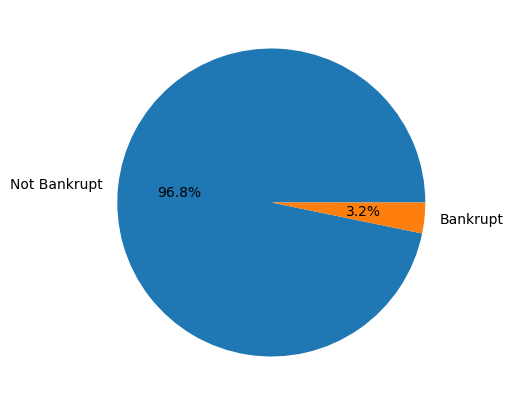

In [57]:
bankrupt_counts = df['Bankrupt?'].value_counts()
bankrupt_counts.columns = ['Not Bankrupt','Bankrupt']
plt.figure(figsize=(5,5))
plt.pie(bankrupt_counts, labels=bankrupt_counts.columns, autopct='%1.1f%%')
plt.show()

### Stripping white spaces from column names

In [4]:
df.columns = df.columns.str.strip()

In [5]:
df2 = df.drop("Bankrupt?",axis=1)
df2.columns

Index(['ROA(C) before interest and depreciation before interest',
       'ROA(A) before interest and % after tax',
       'ROA(B) before interest and depreciation after tax',
       'Operating Gross Margin', 'Realized Sales Gross Margin',
       'Operating Profit Rate', 'Pre-tax net Interest Rate',
       'After-tax net Interest Rate',
       'Non-industry income and expenditure/revenue',
       'Continuous interest rate (after tax)', 'Operating Expense Rate',
       'Research and development expense rate', 'Cash flow rate',
       'Interest-bearing debt interest rate', 'Tax rate (A)',
       'Net Value Per Share (B)', 'Net Value Per Share (A)',
       'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons',
       'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)',
       'Operating Profit Per Share (Yuan ¥)',
       'Per Share Net profit before tax (Yuan ¥)',
       'Realized Sales Gross Profit Growth Rate',
       'Operating Profit Growth Rate', 'After-tax Net Profit G

In [6]:
columns = df2.columns

### Visualising how spread out the data is and how centrally distributed it is, we use Violin and Box Plot for it

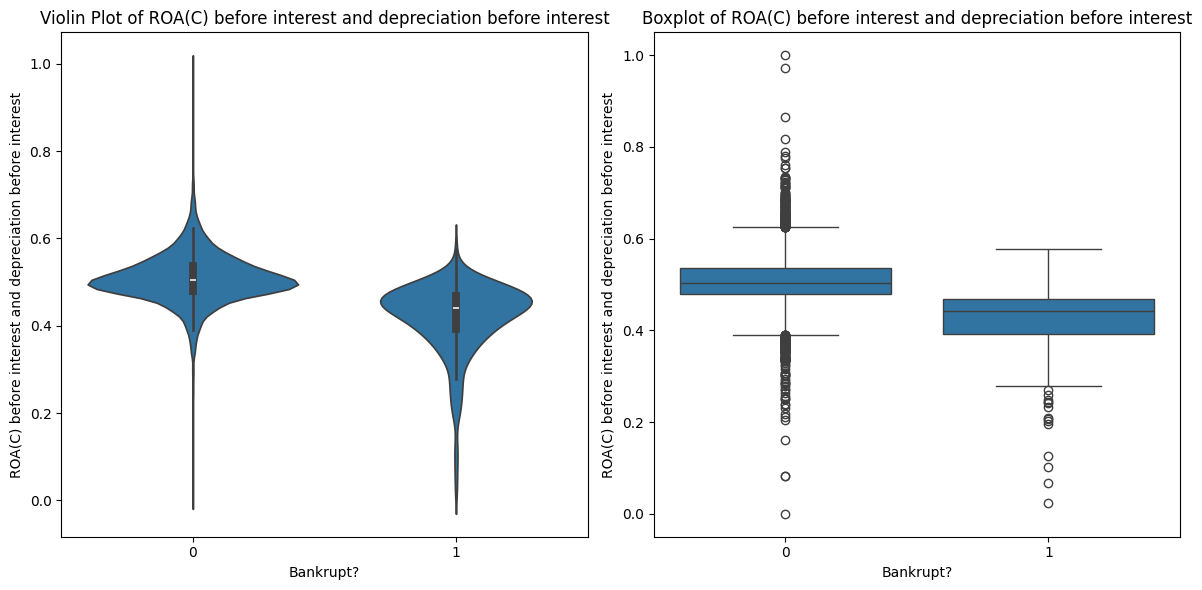

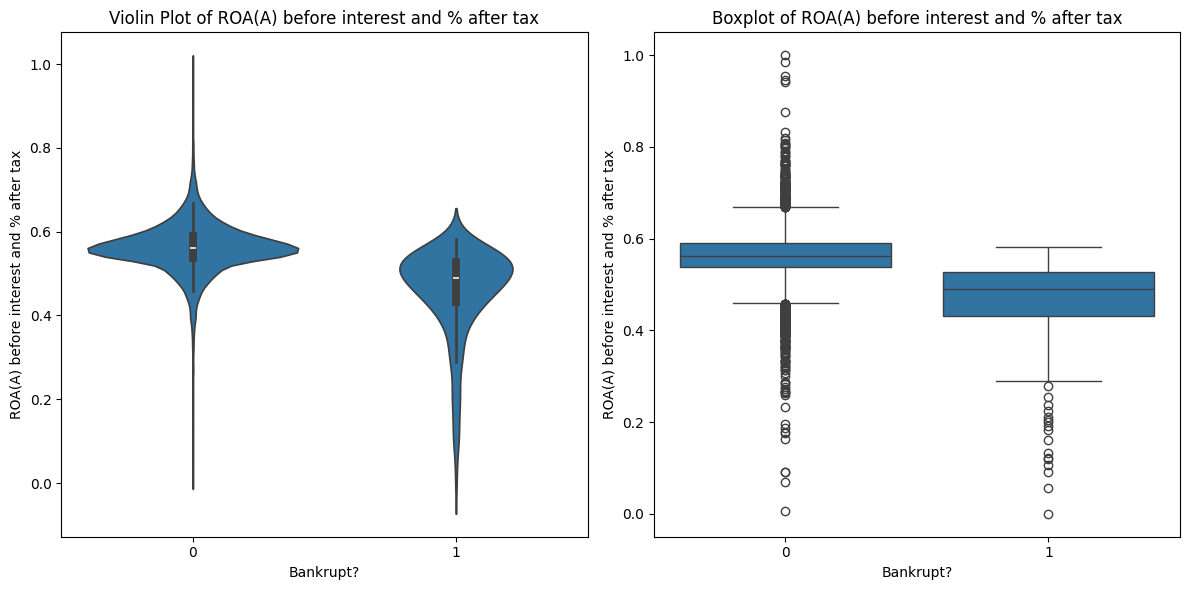

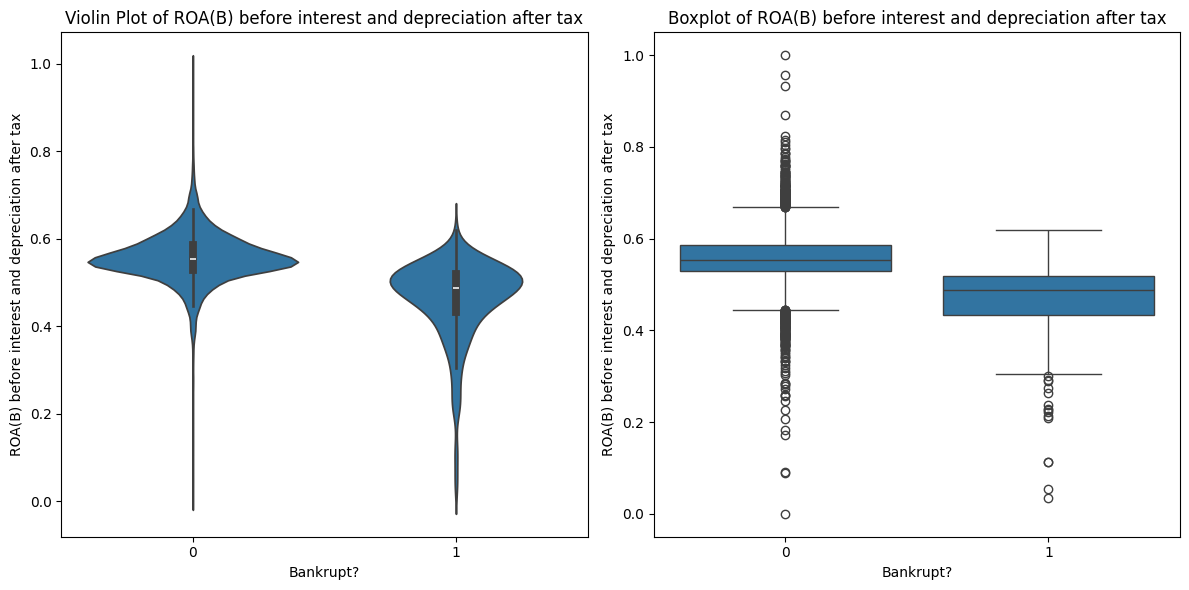

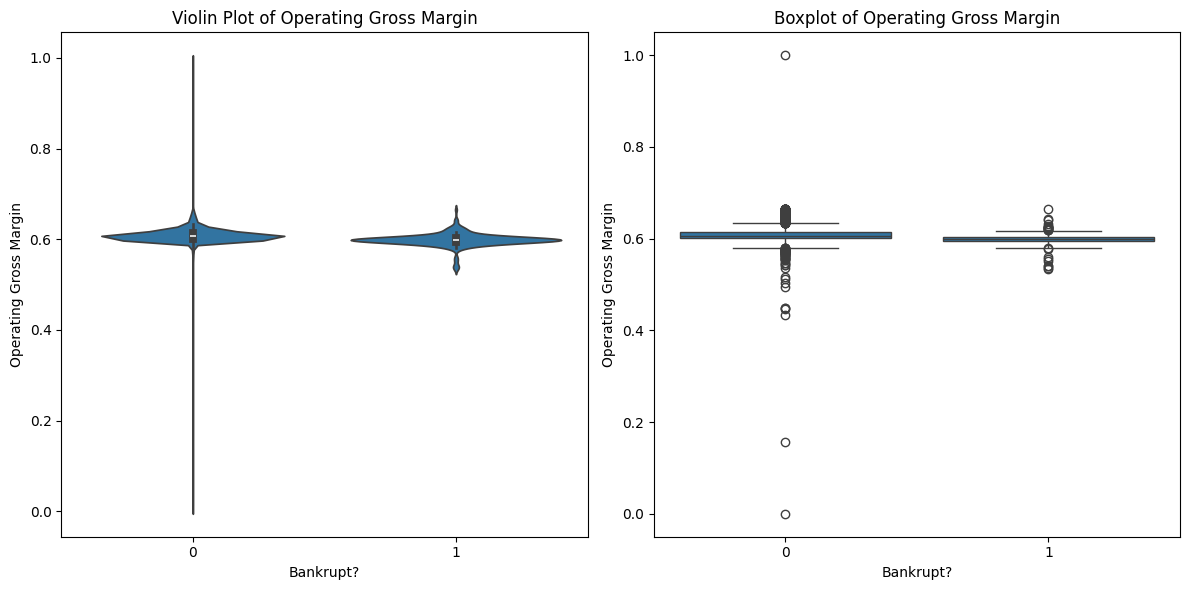

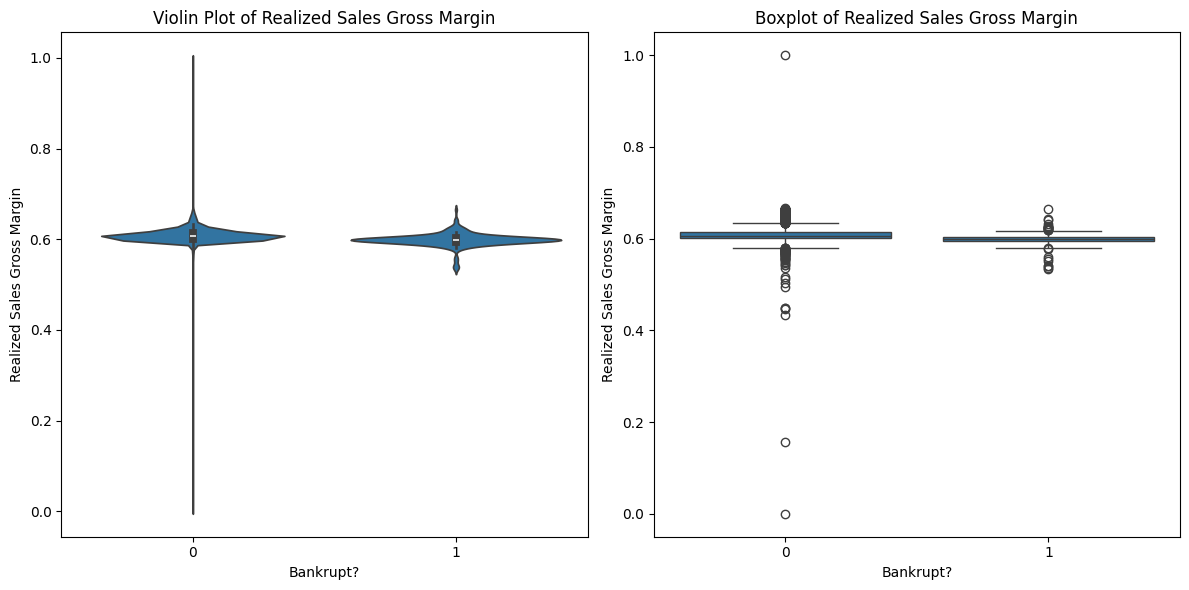

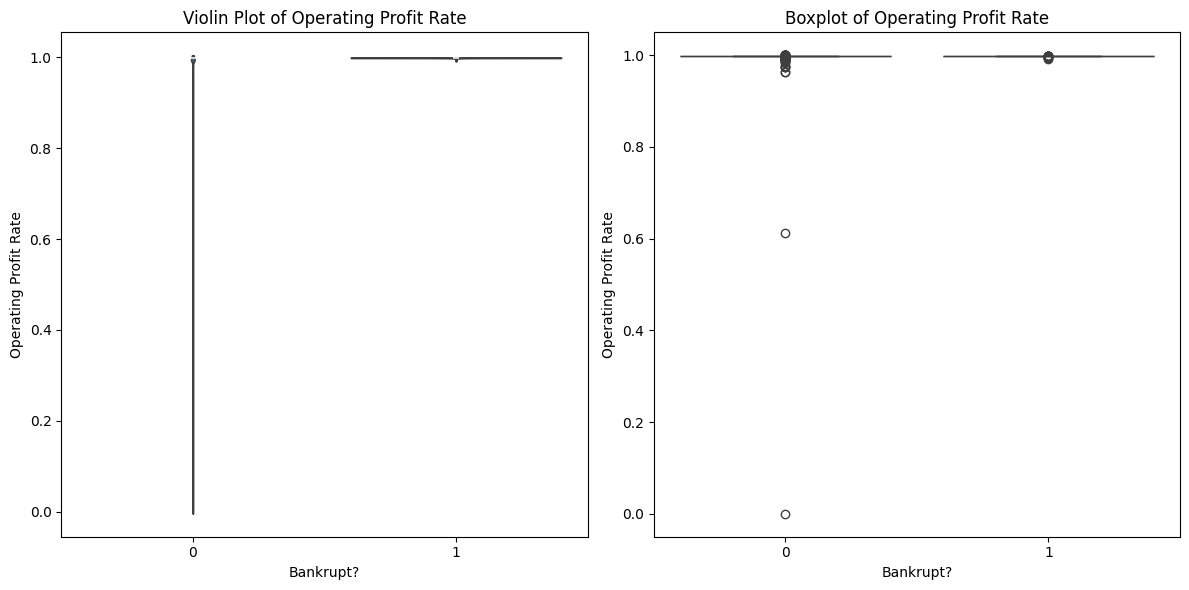

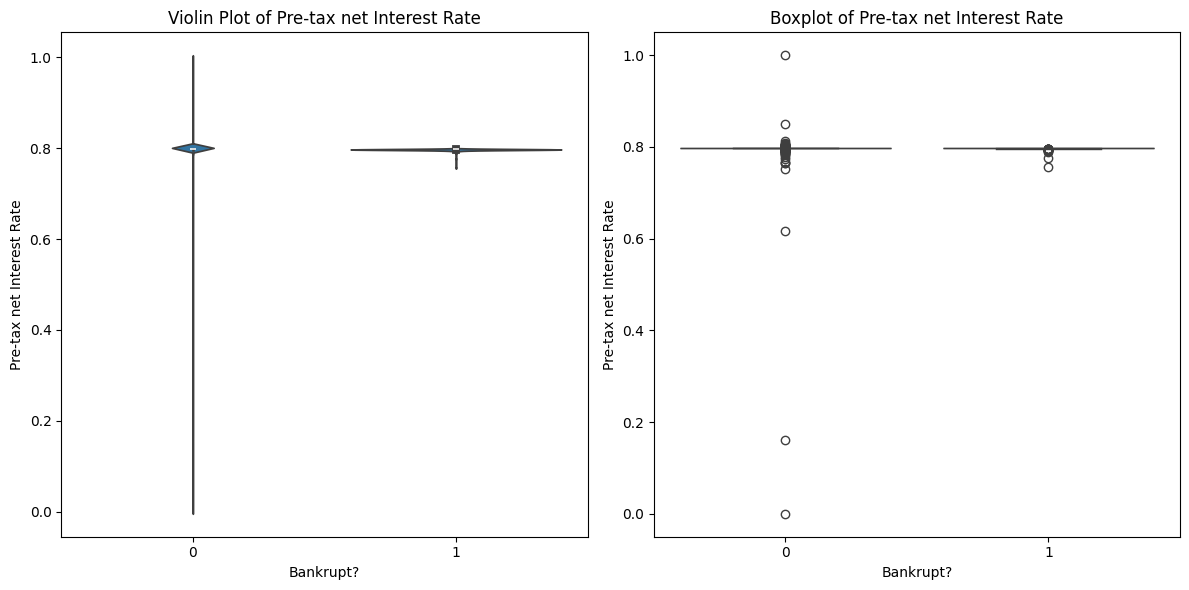

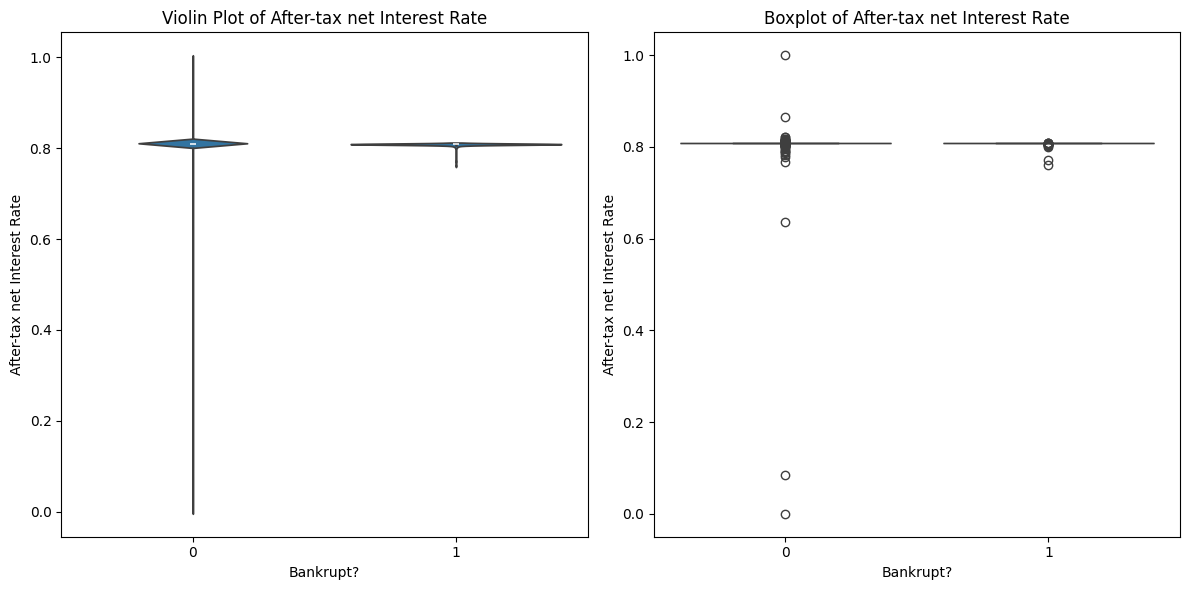

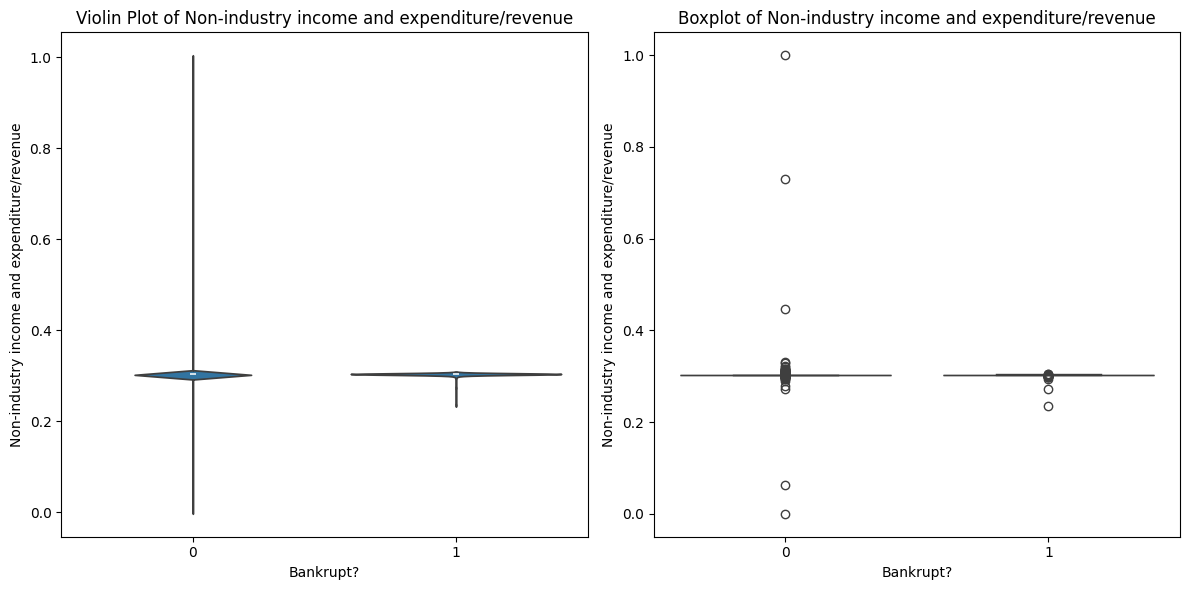

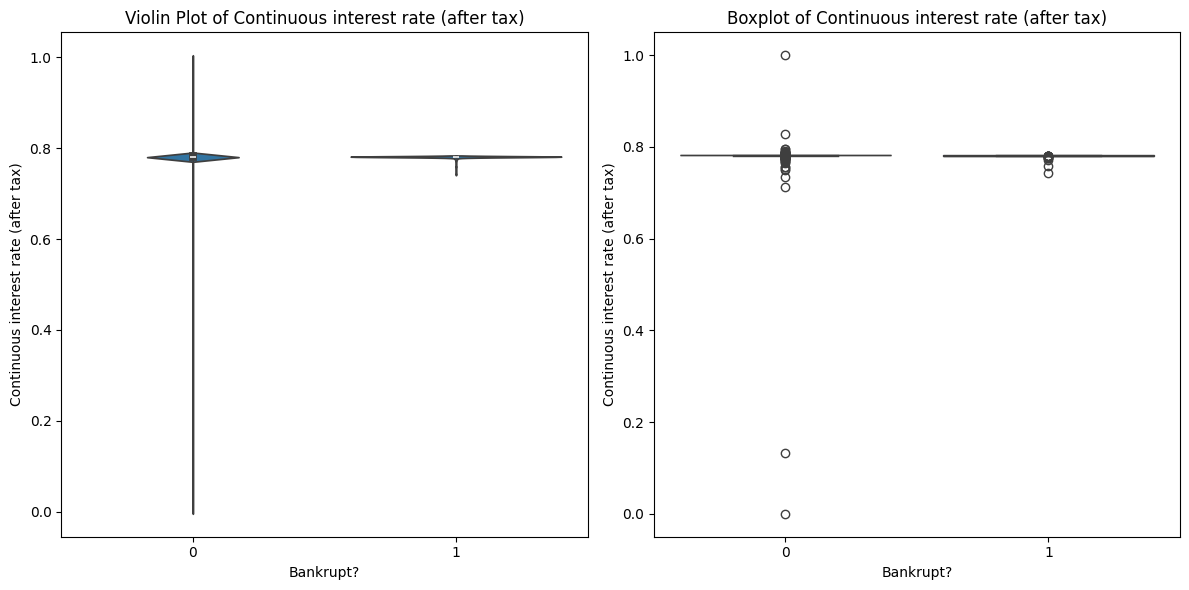

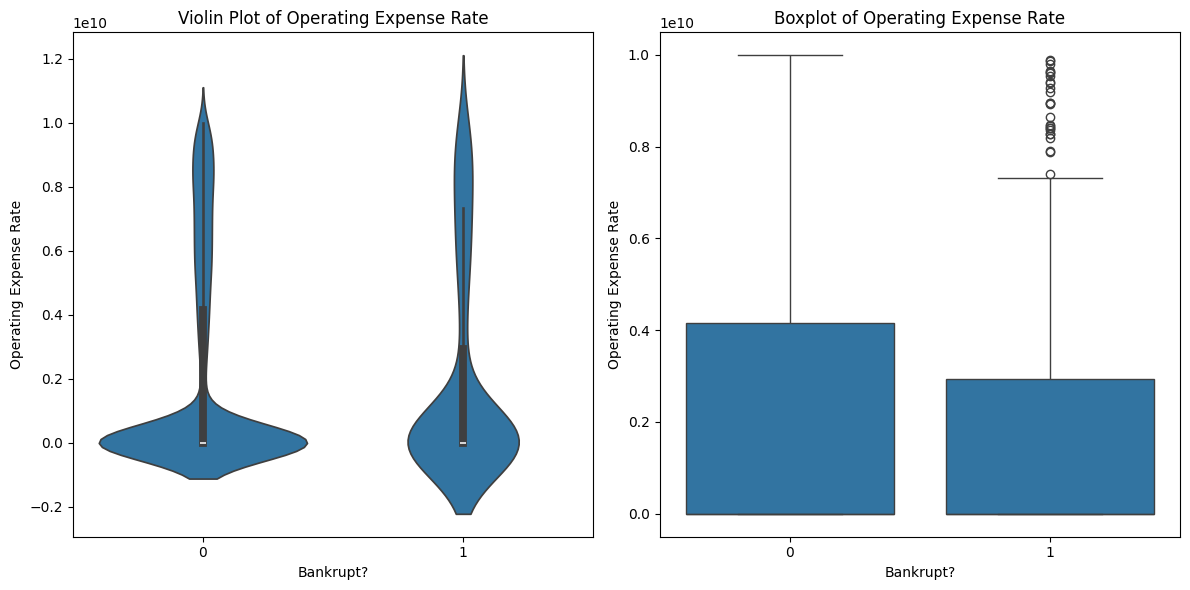

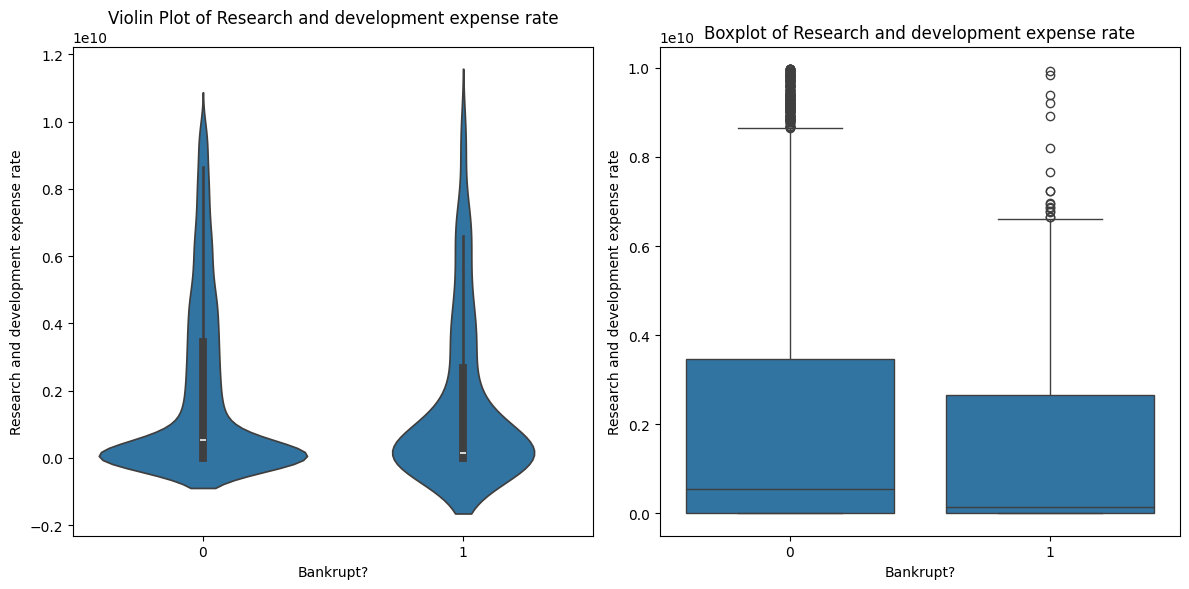

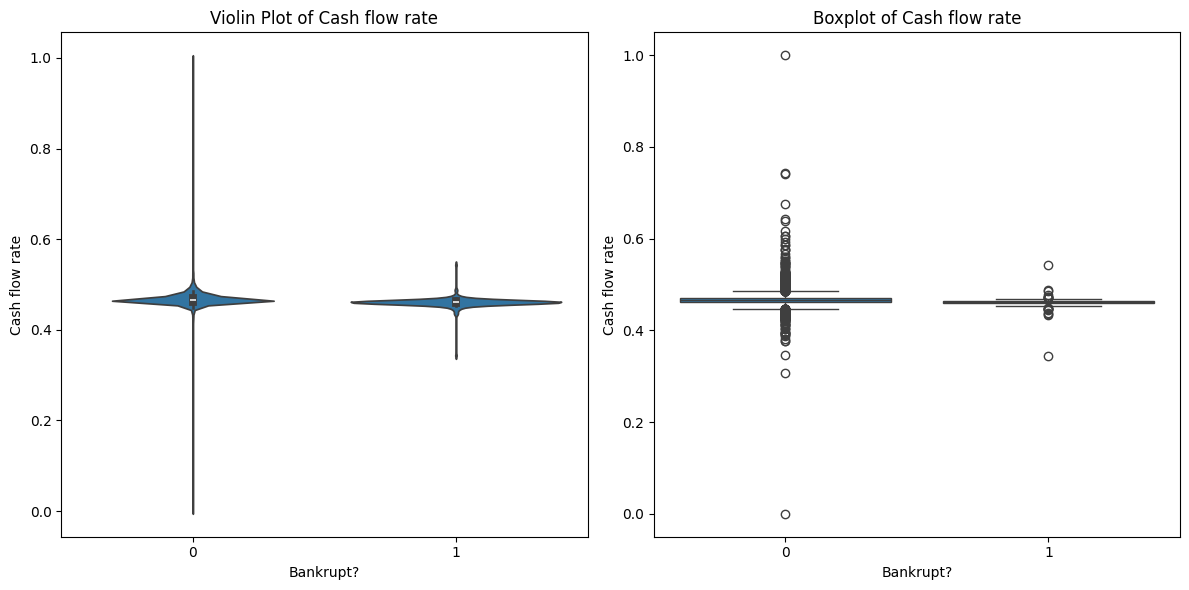

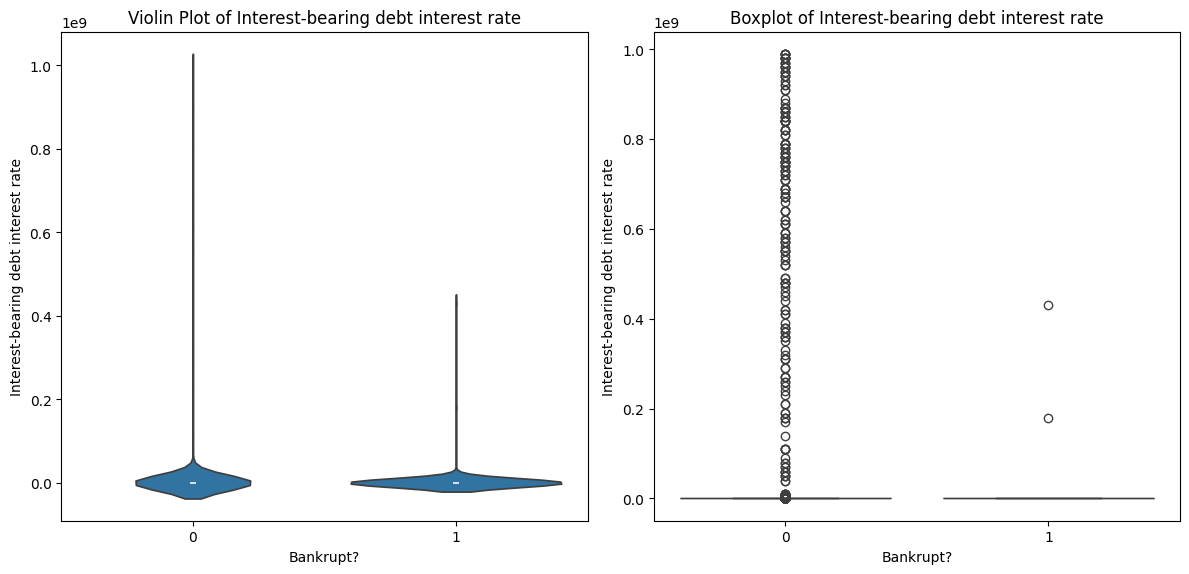

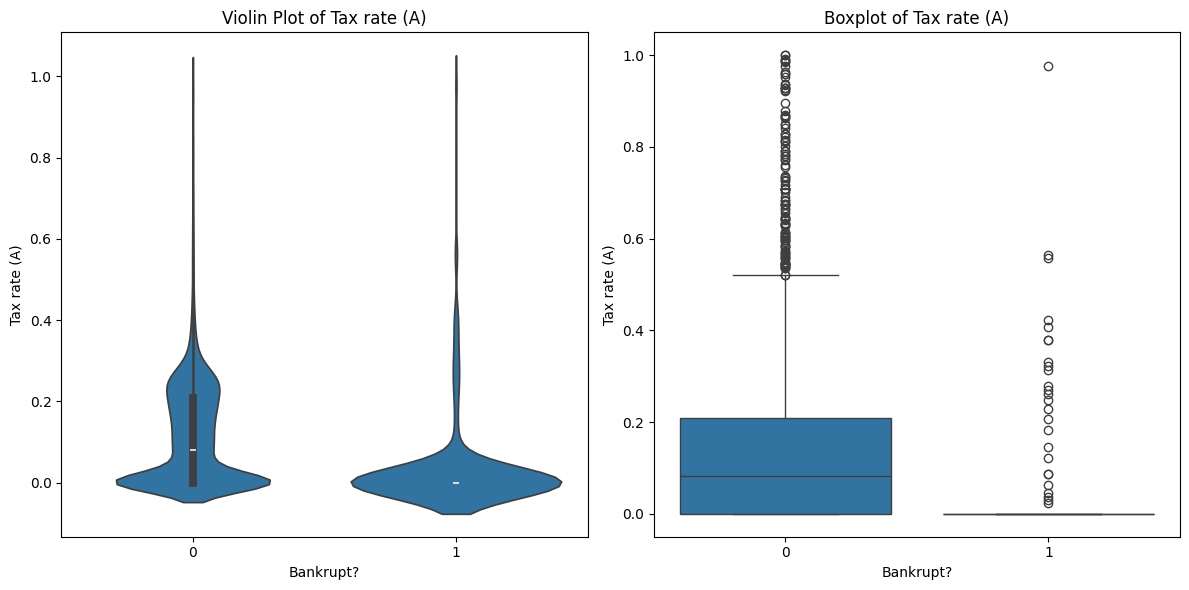

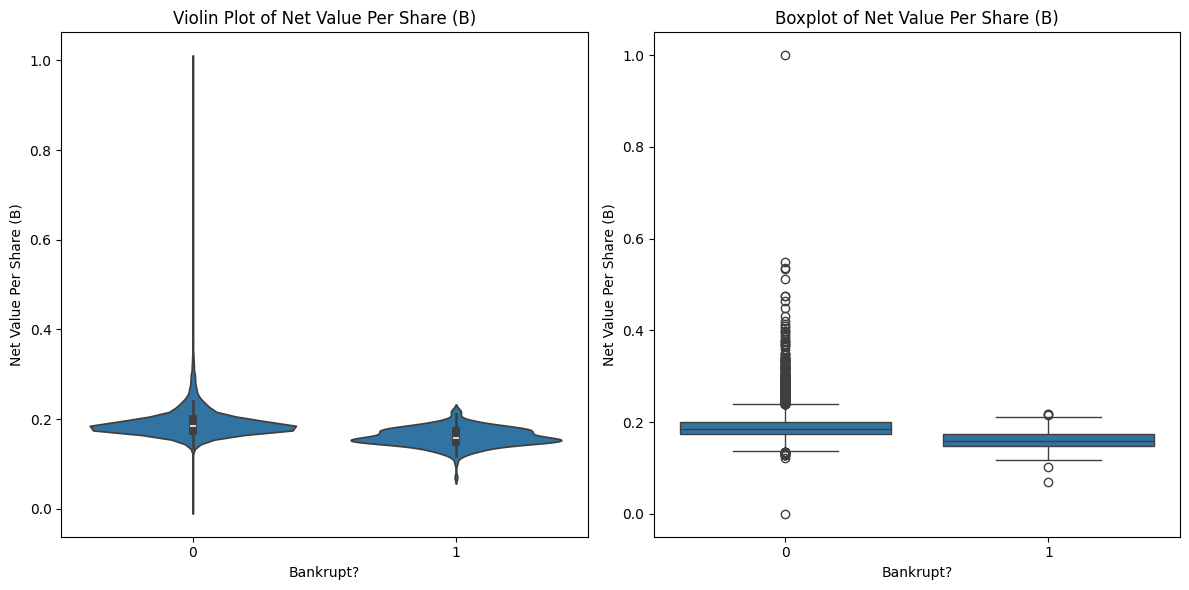

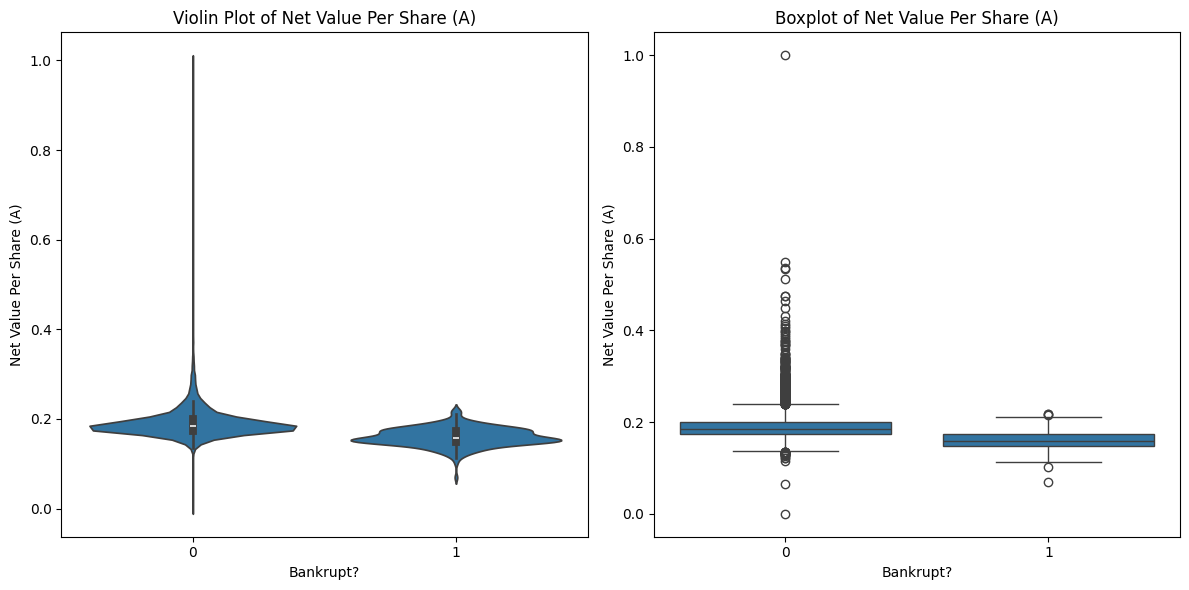

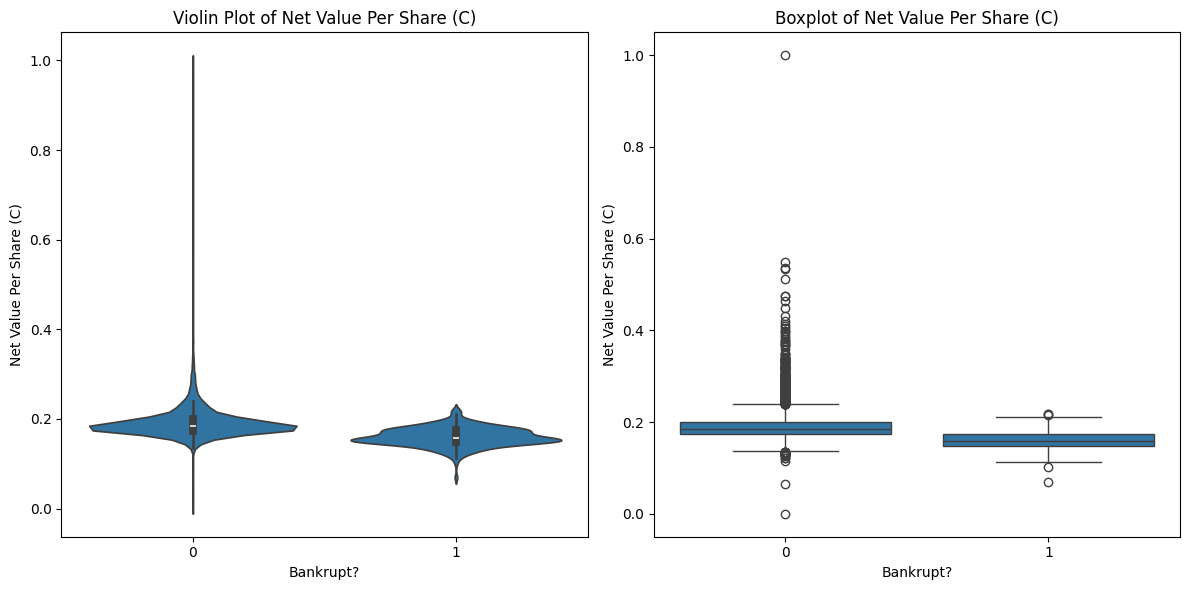

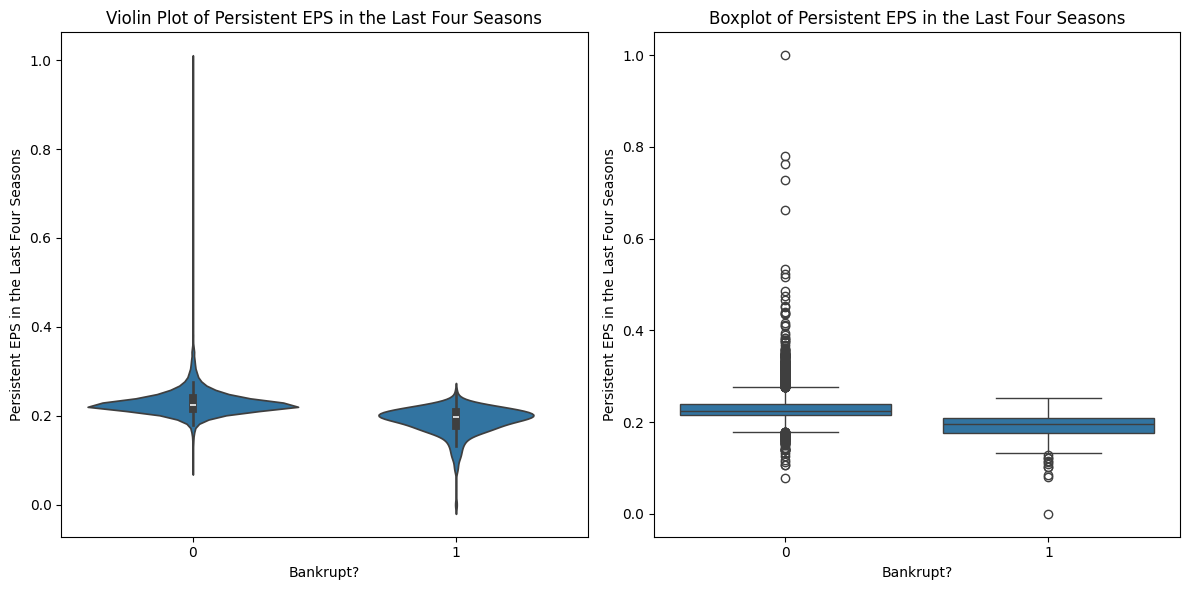

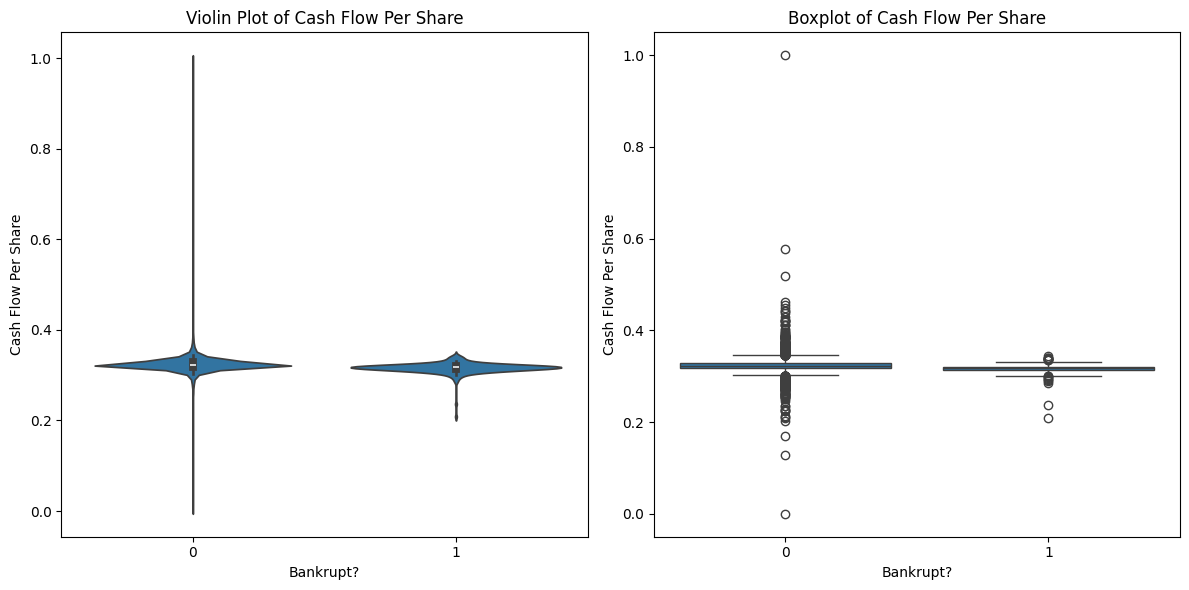

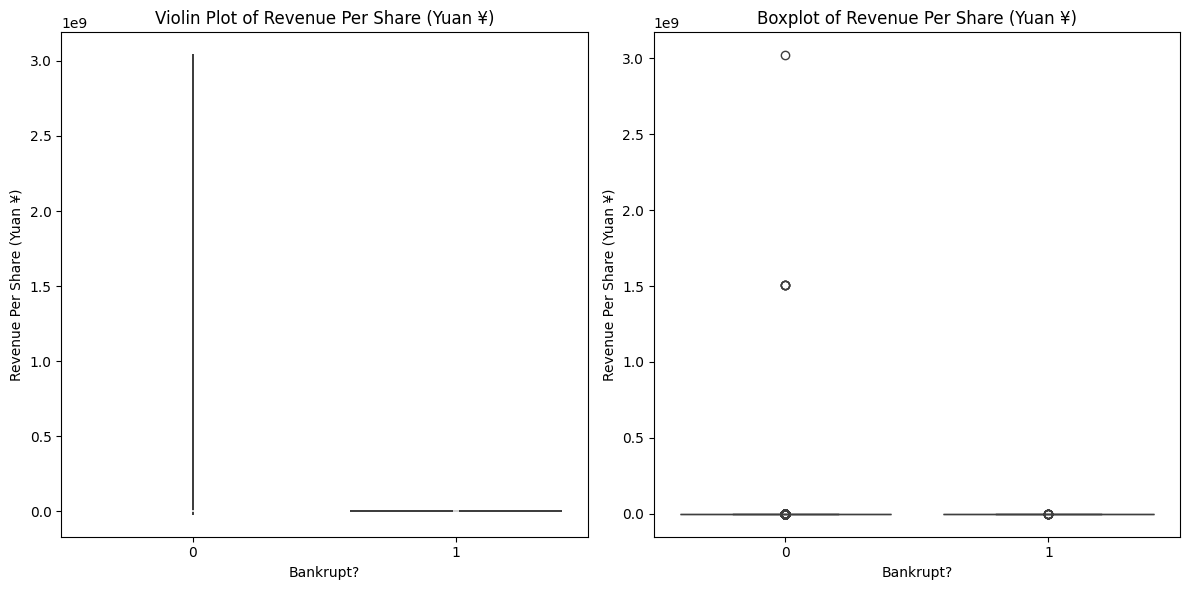

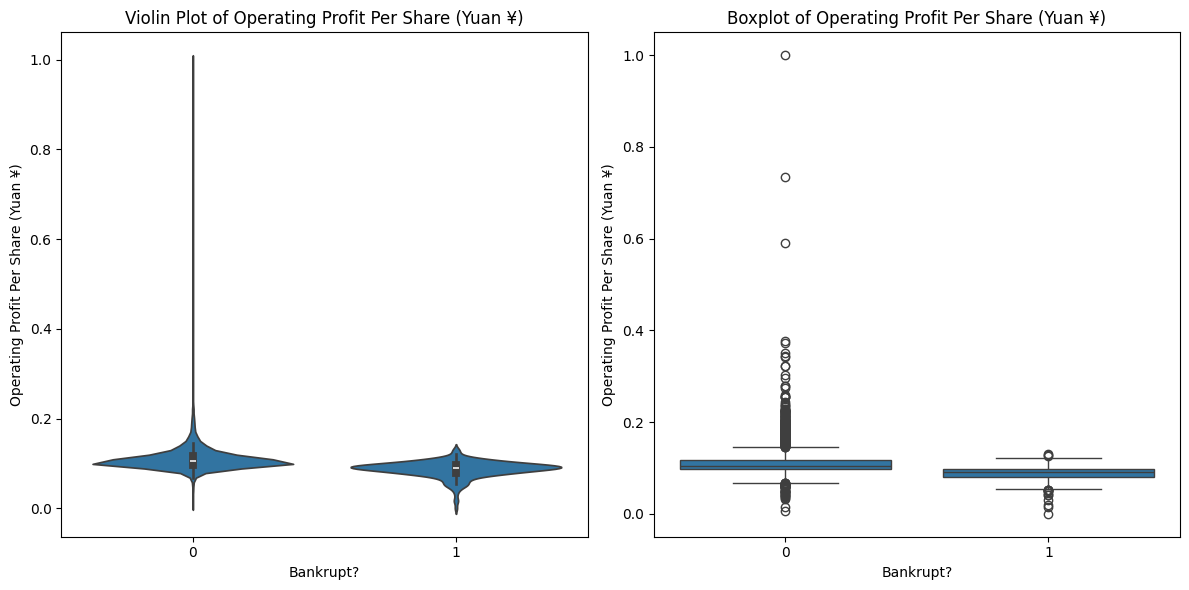

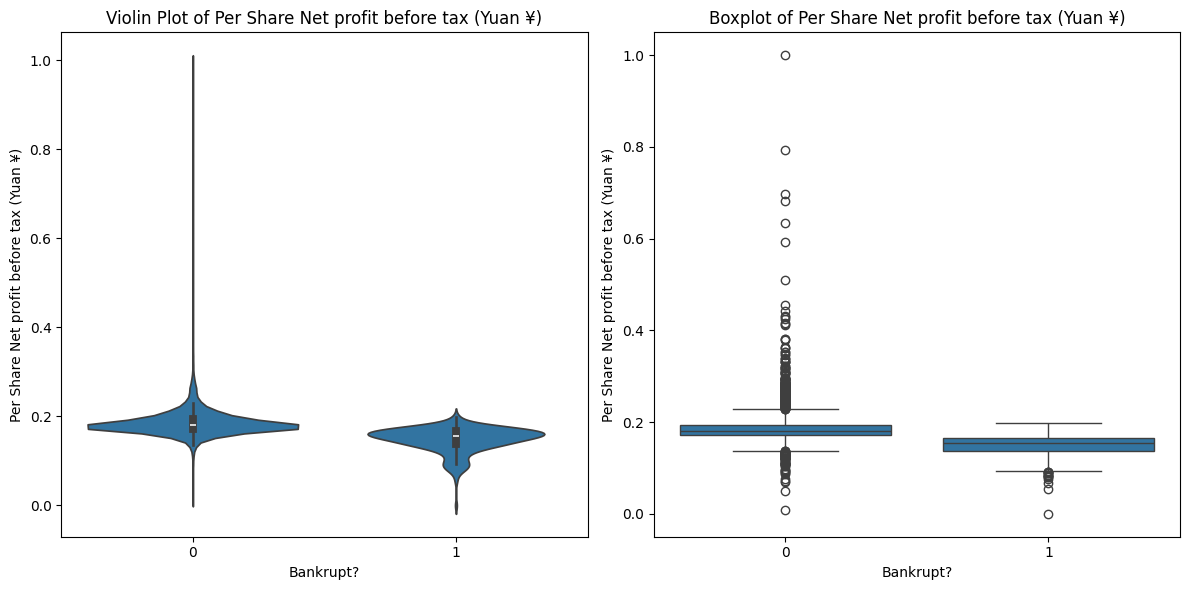

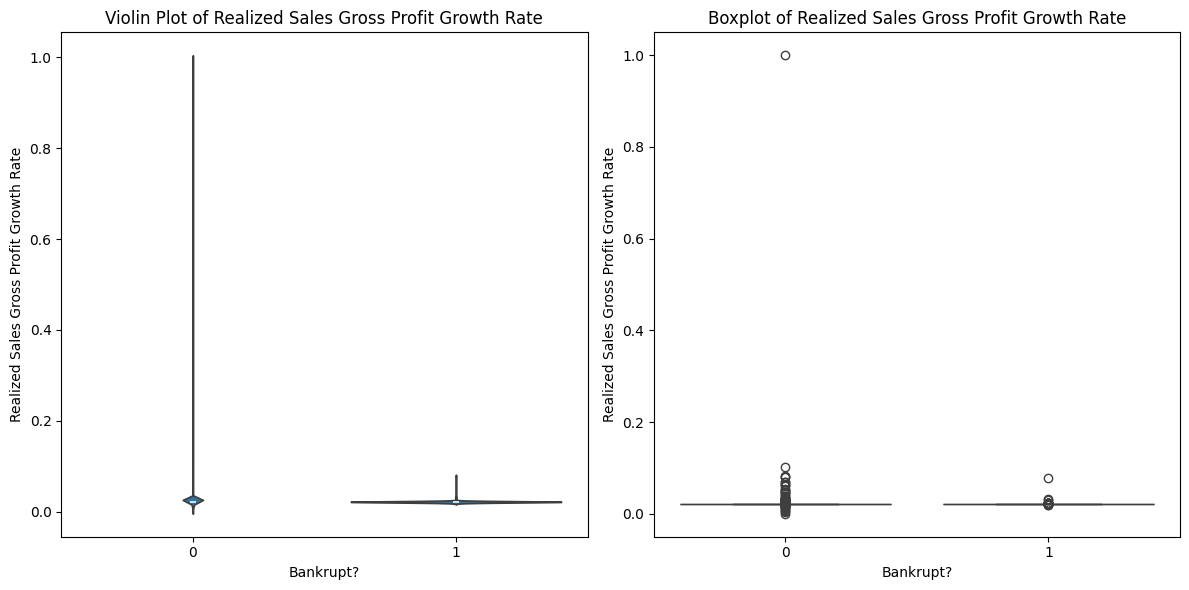

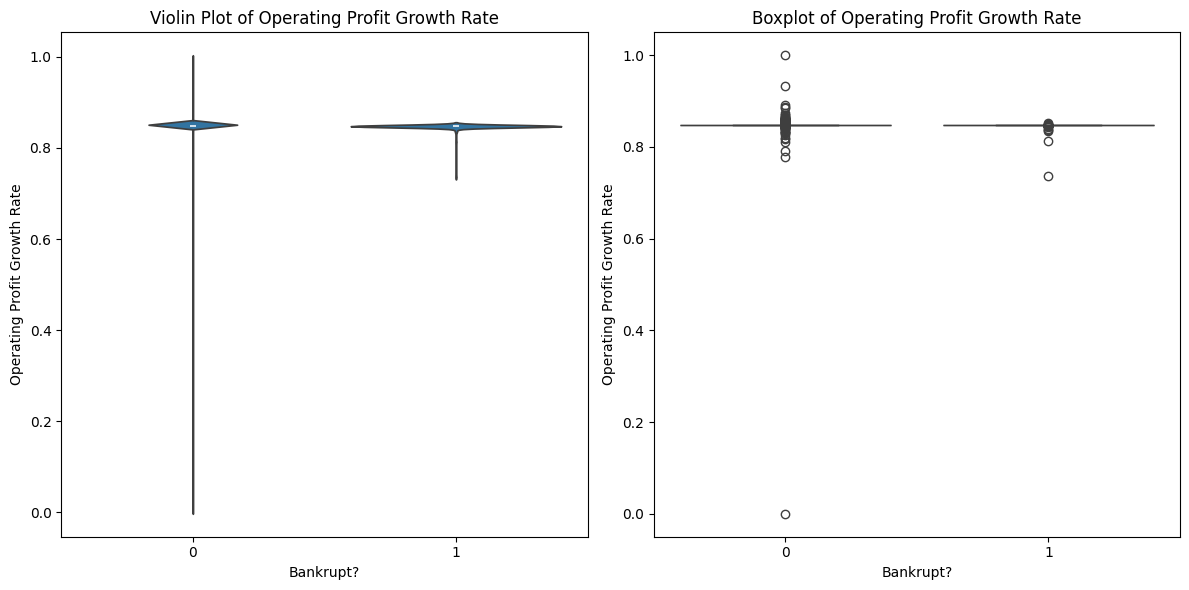

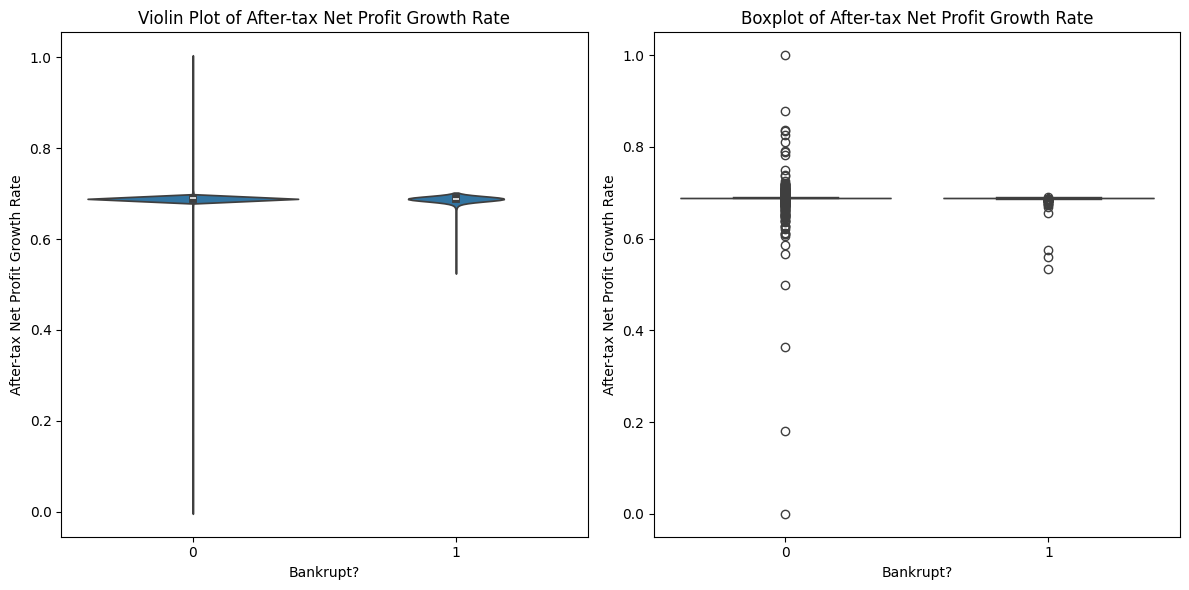

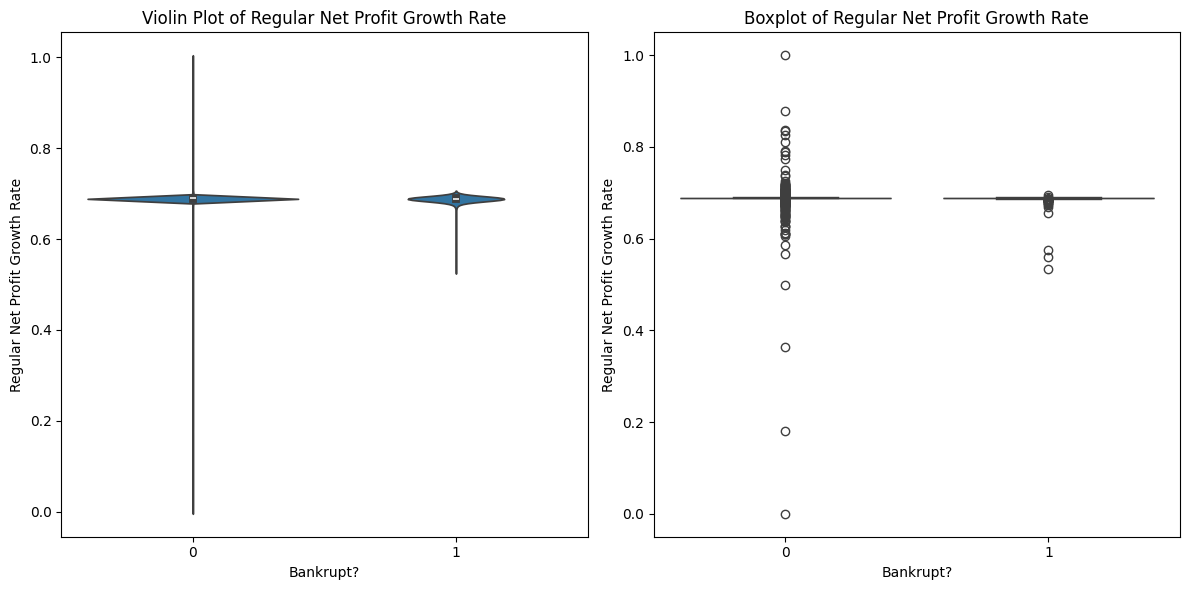

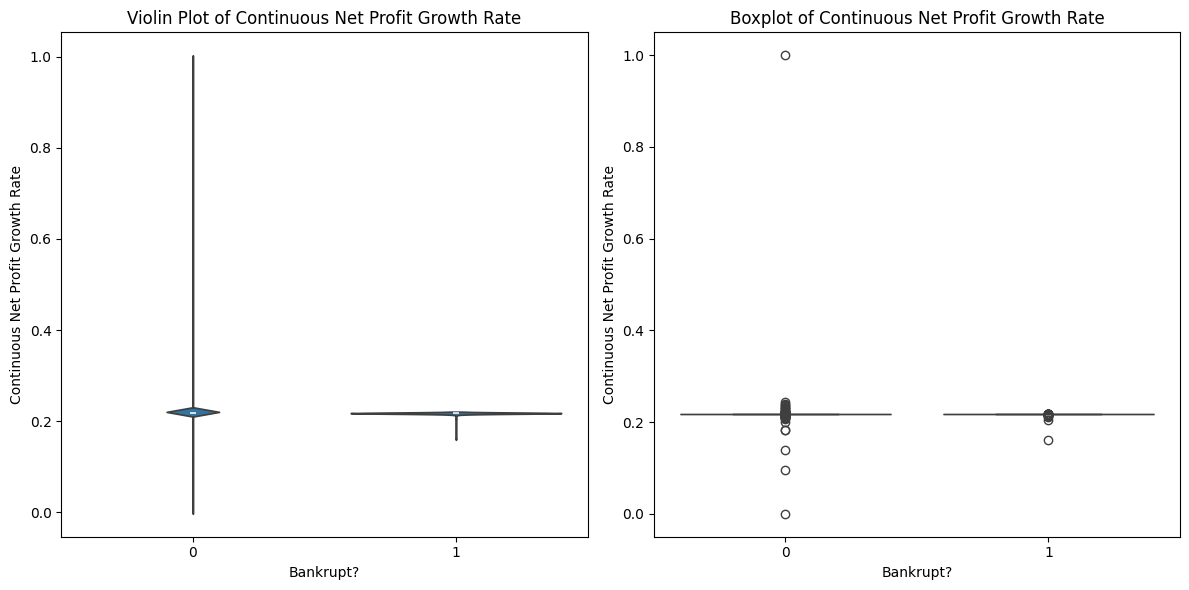

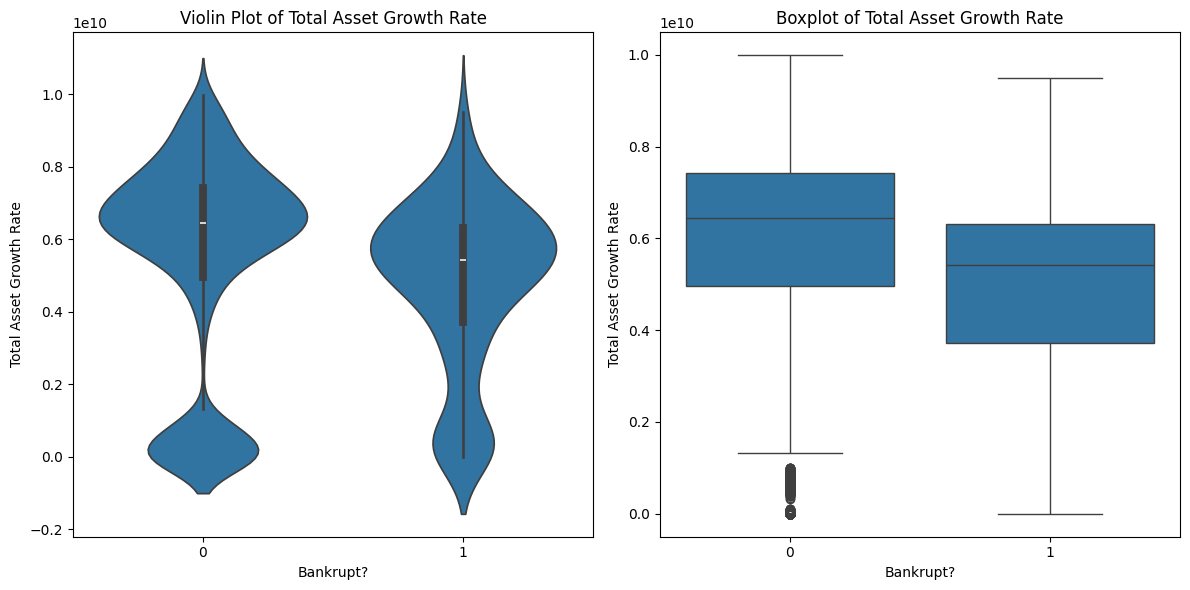

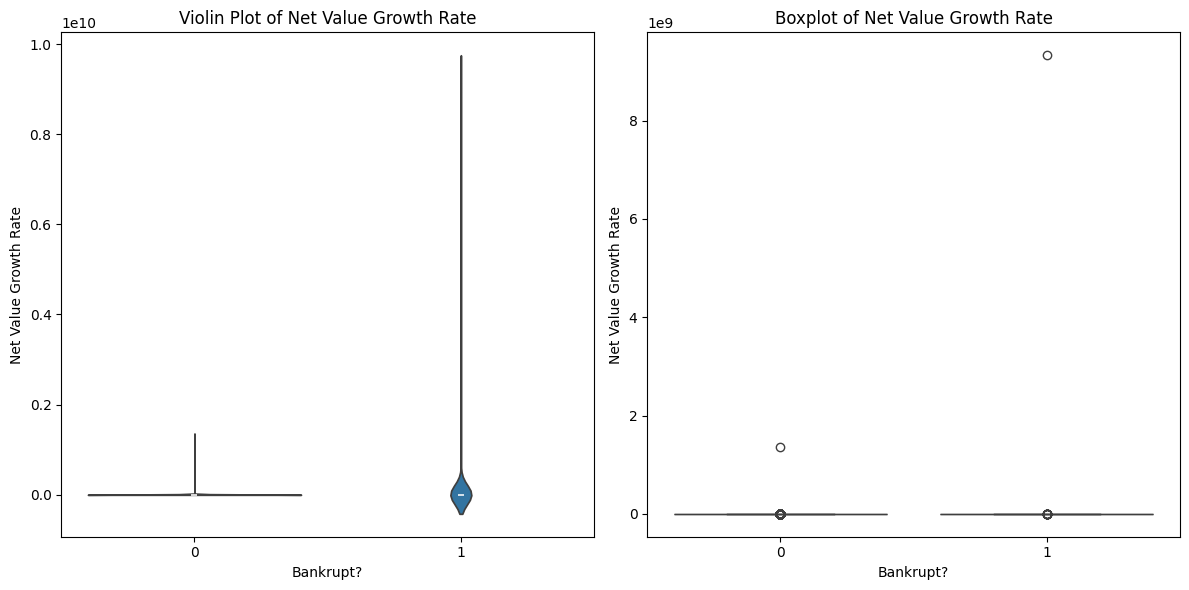

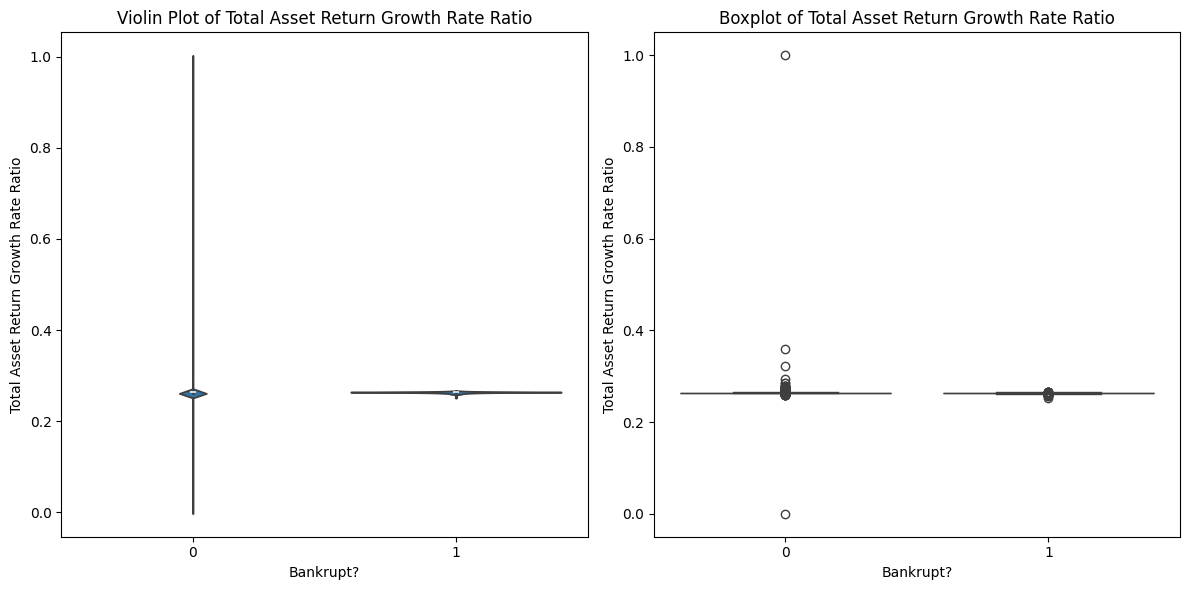

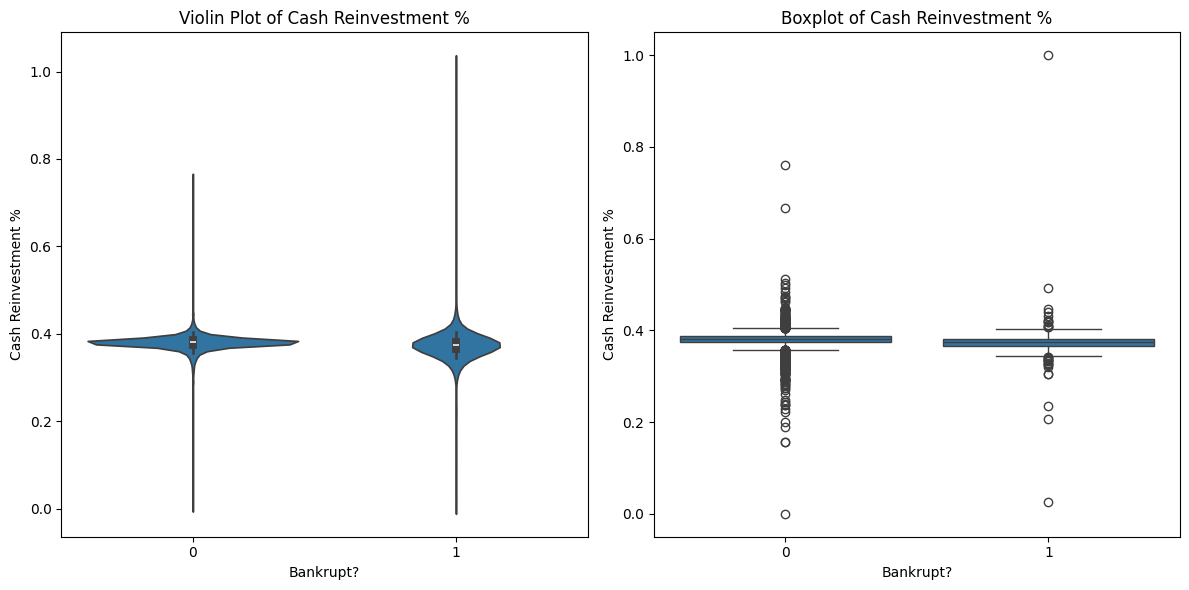

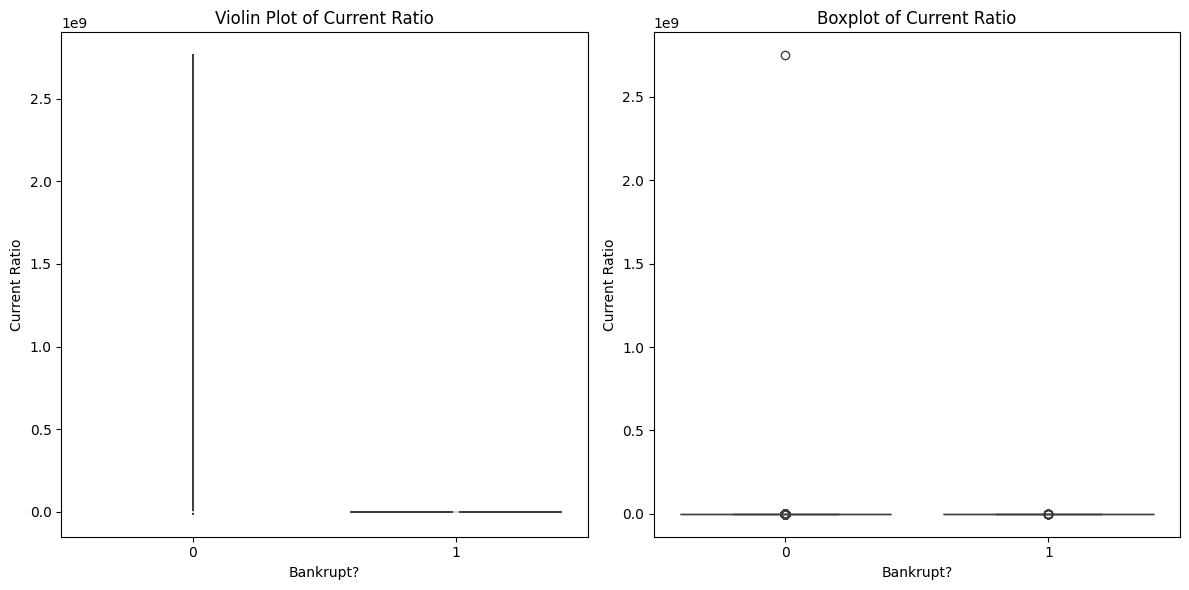

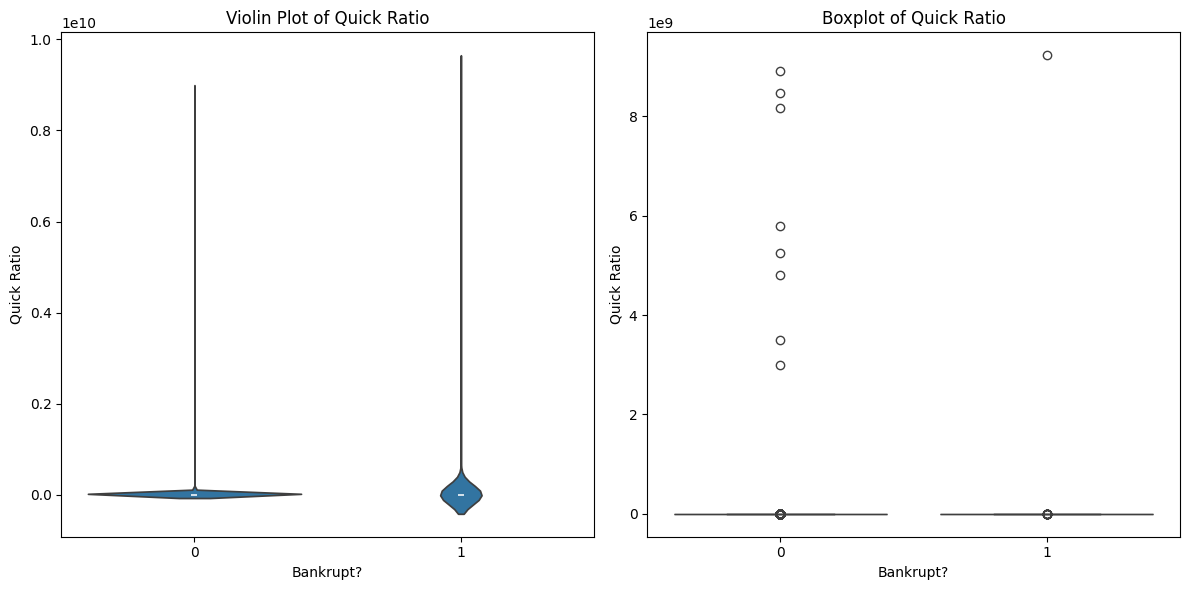

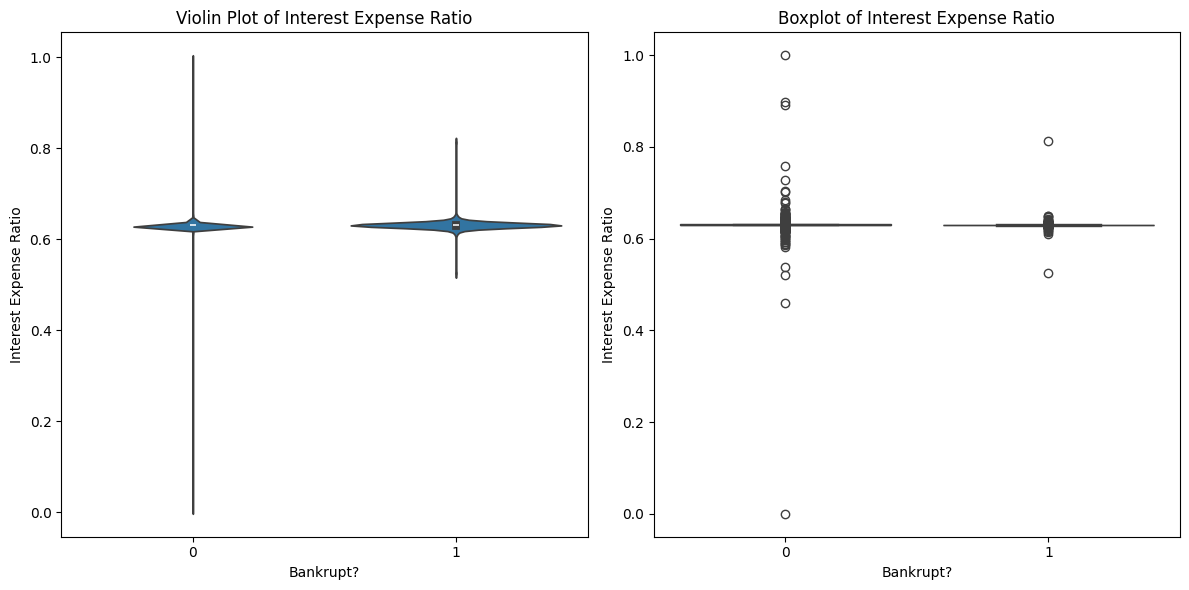

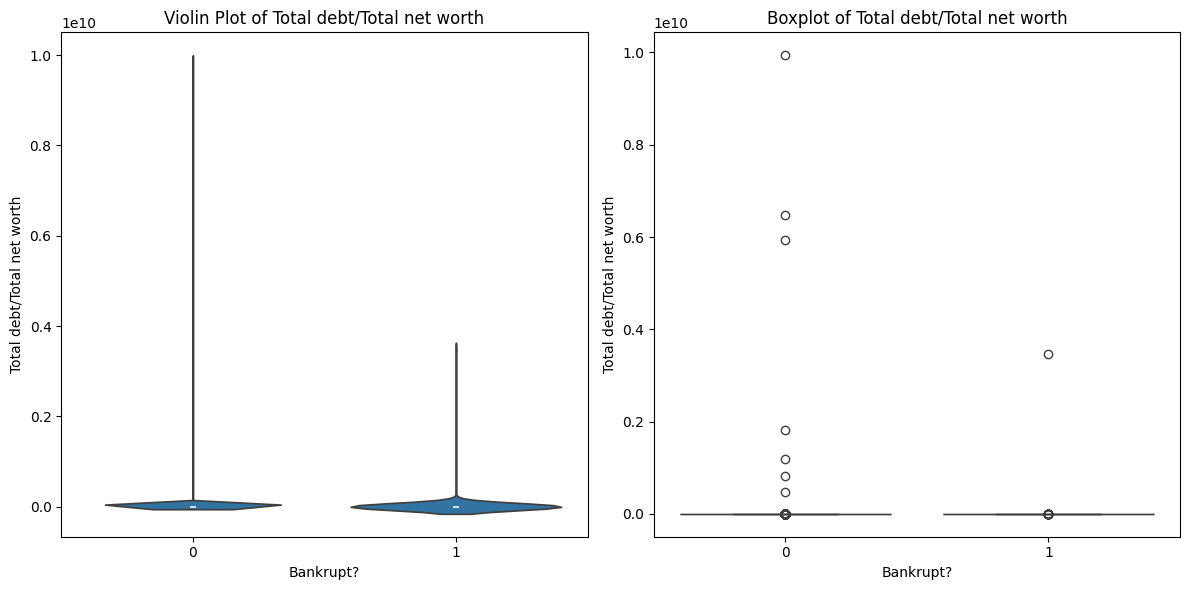

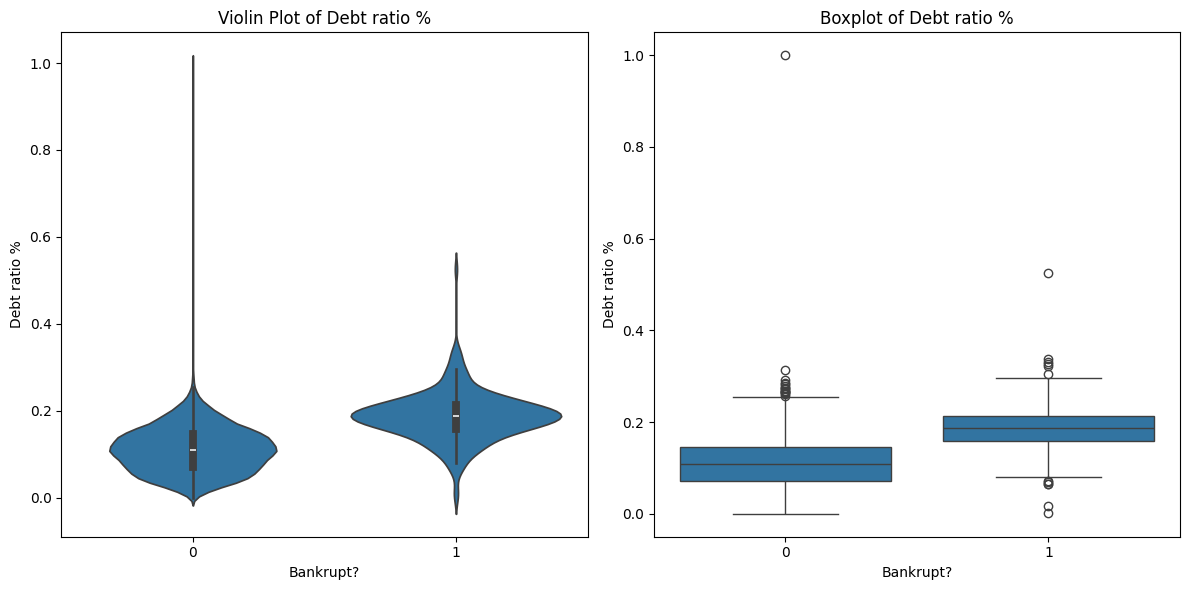

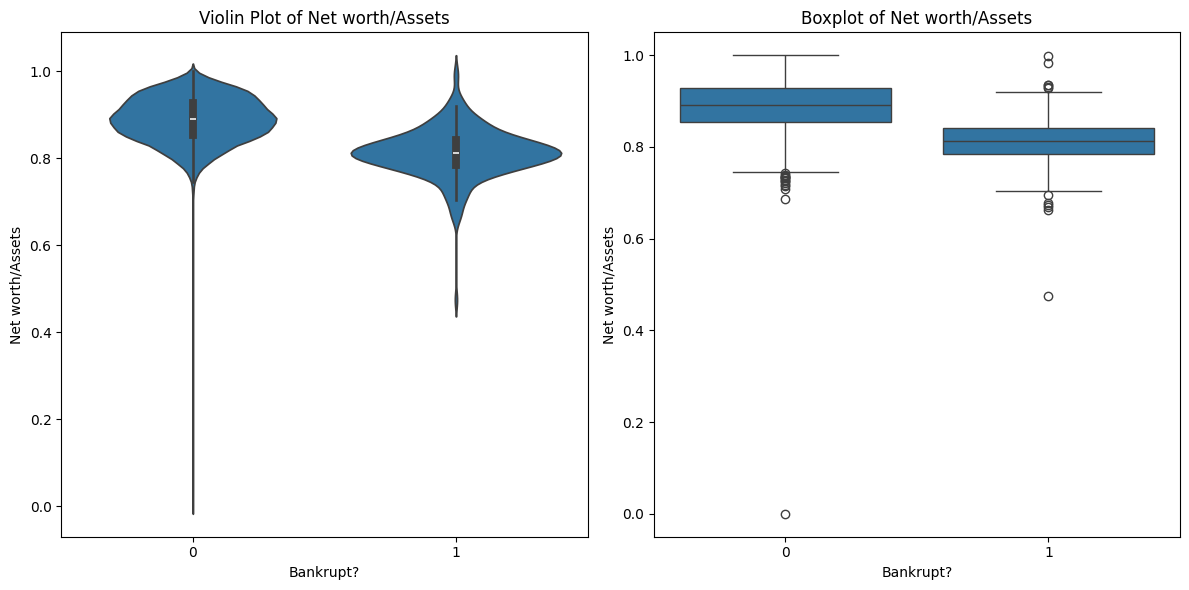

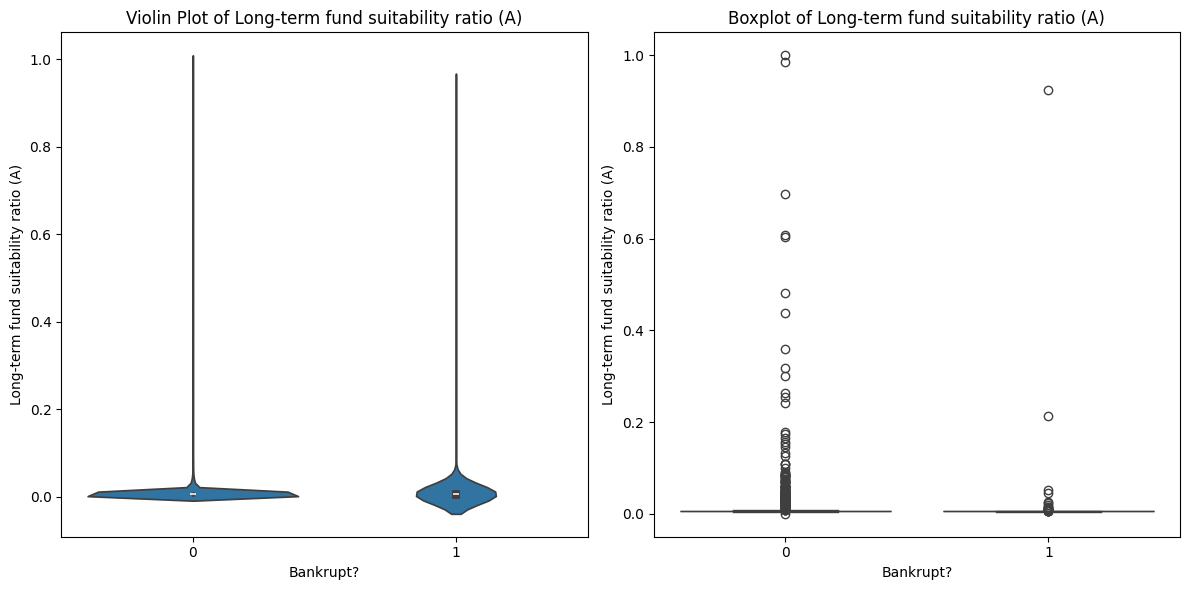

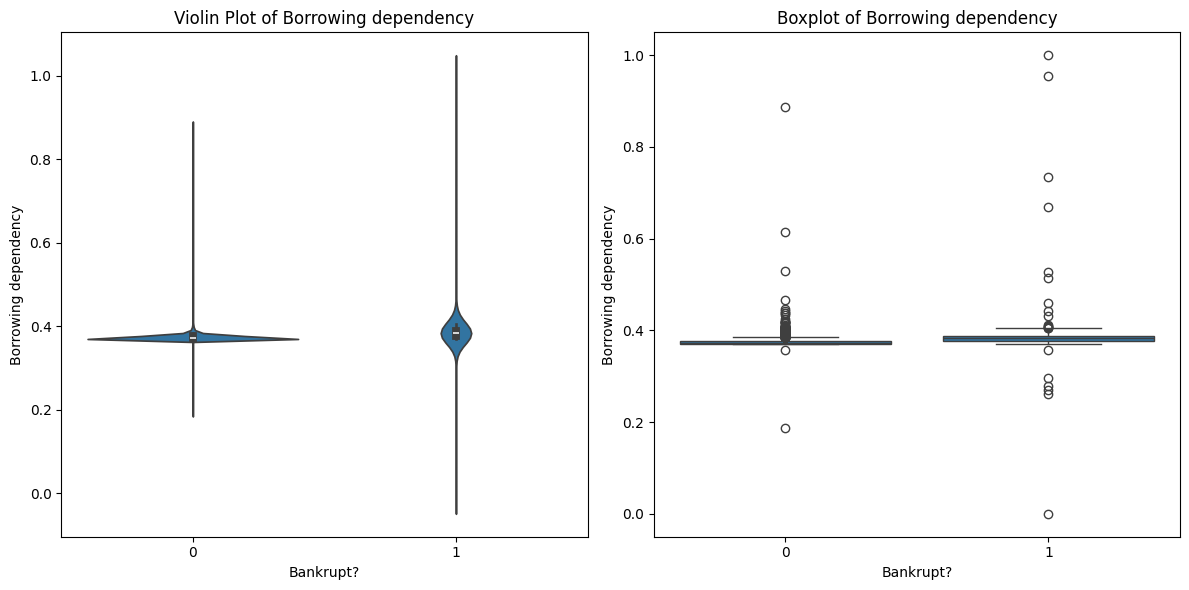

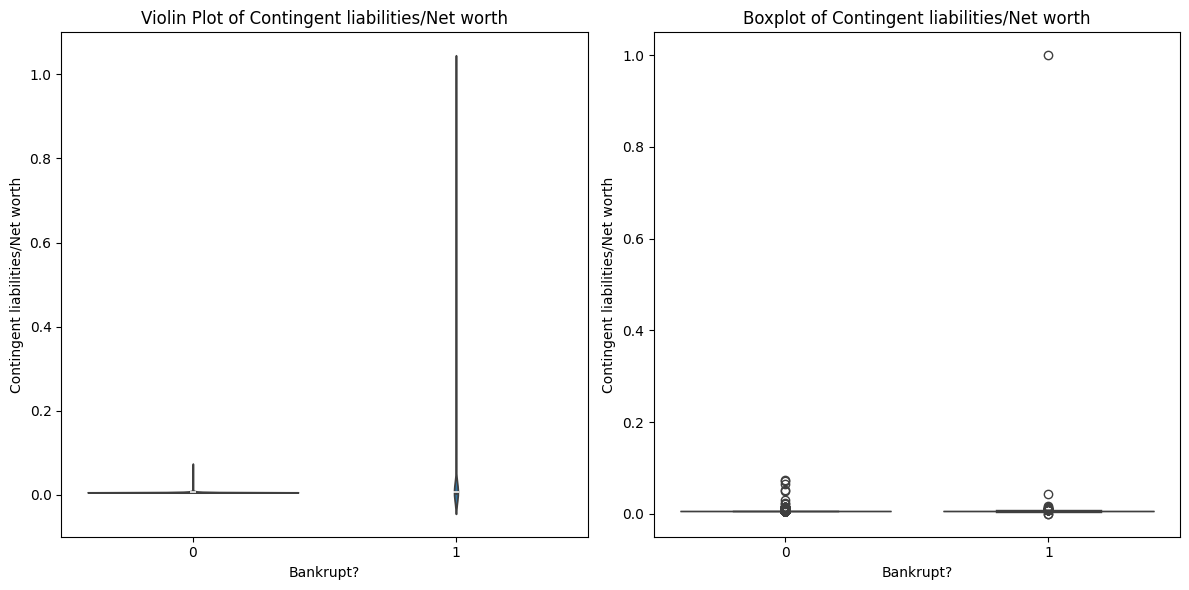

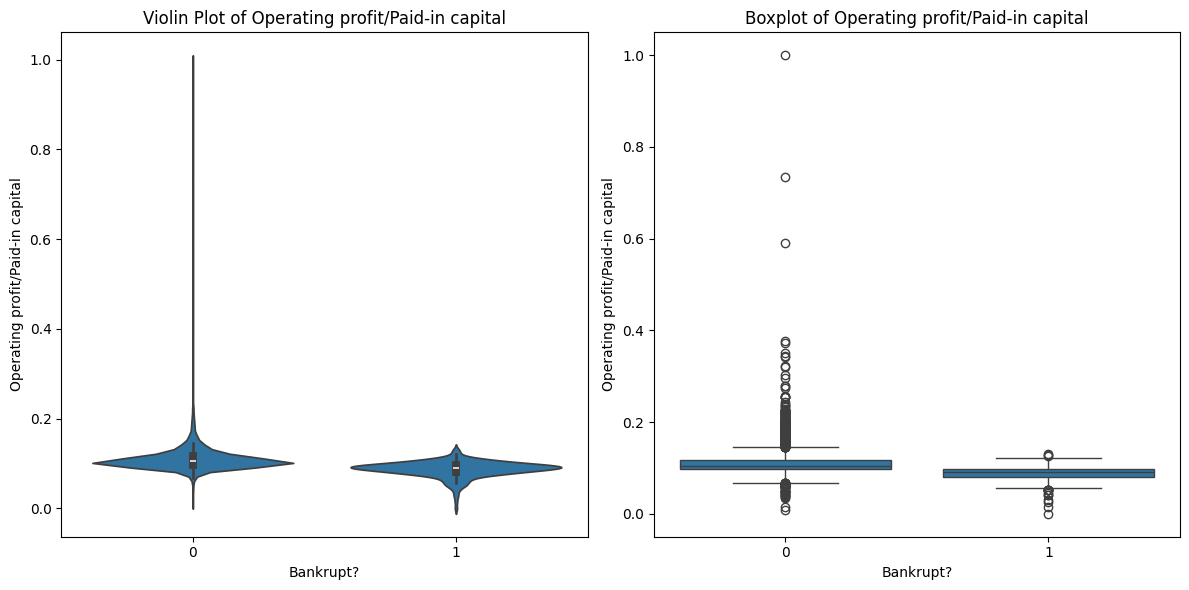

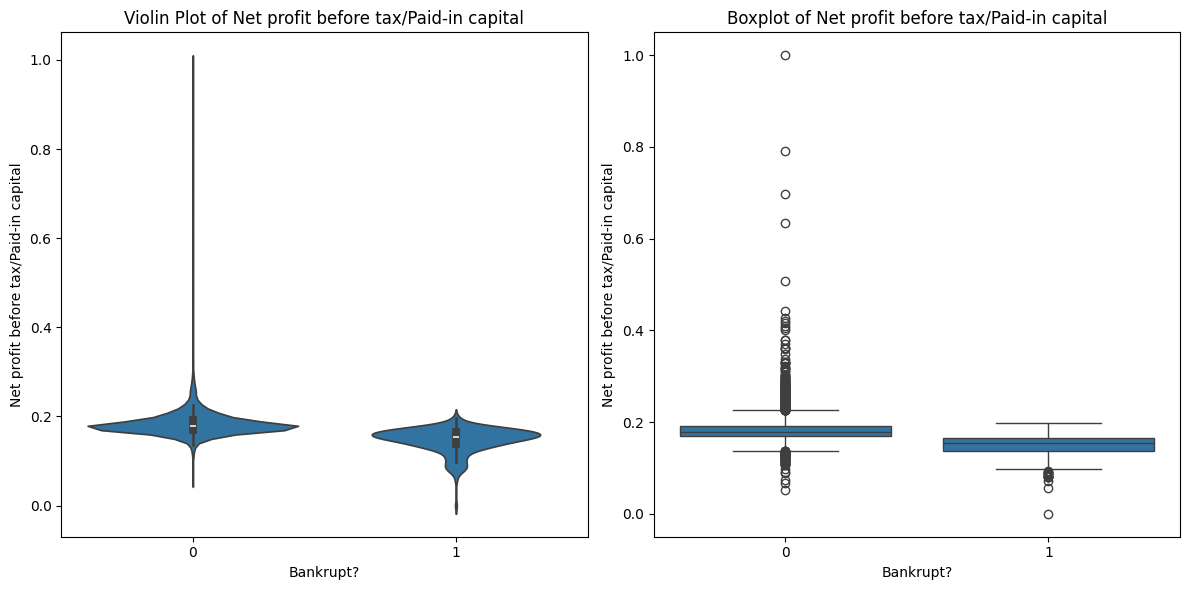

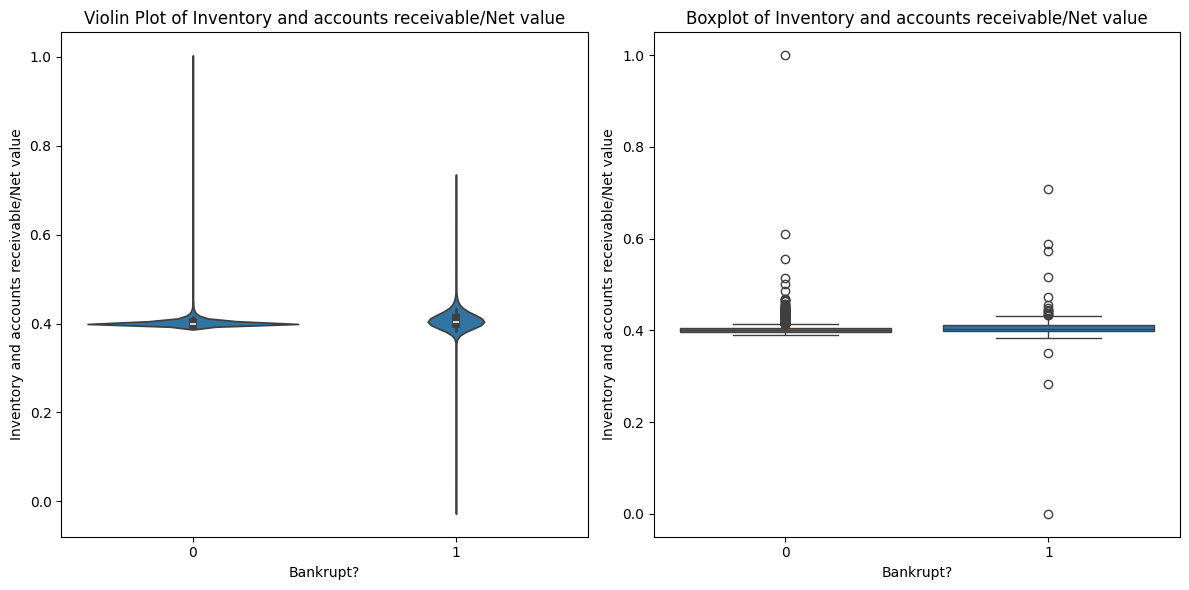

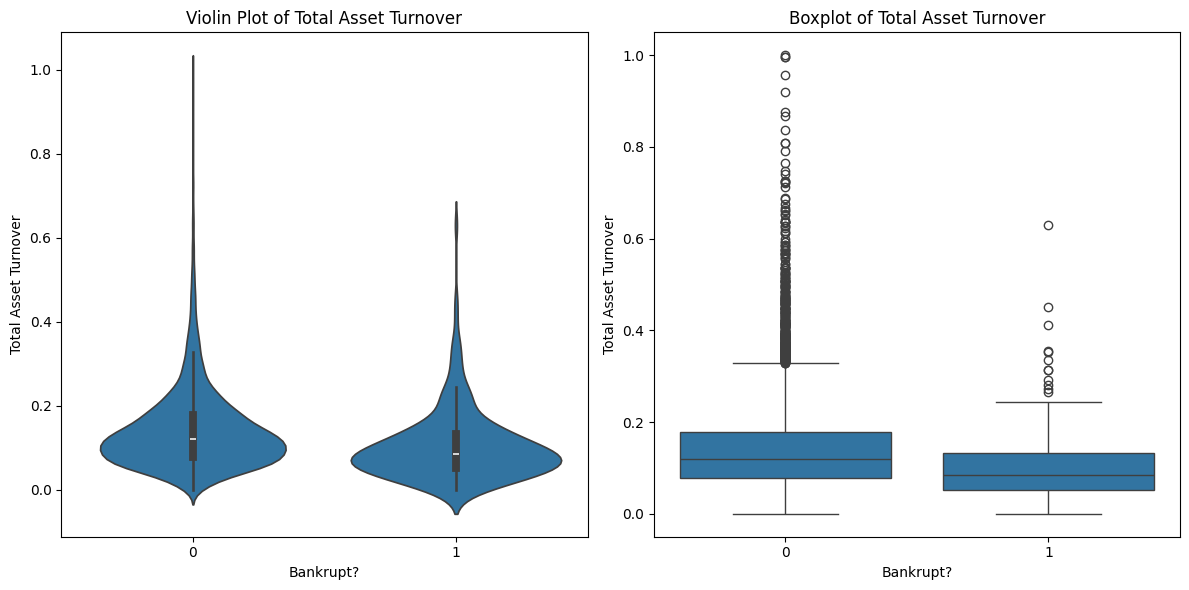

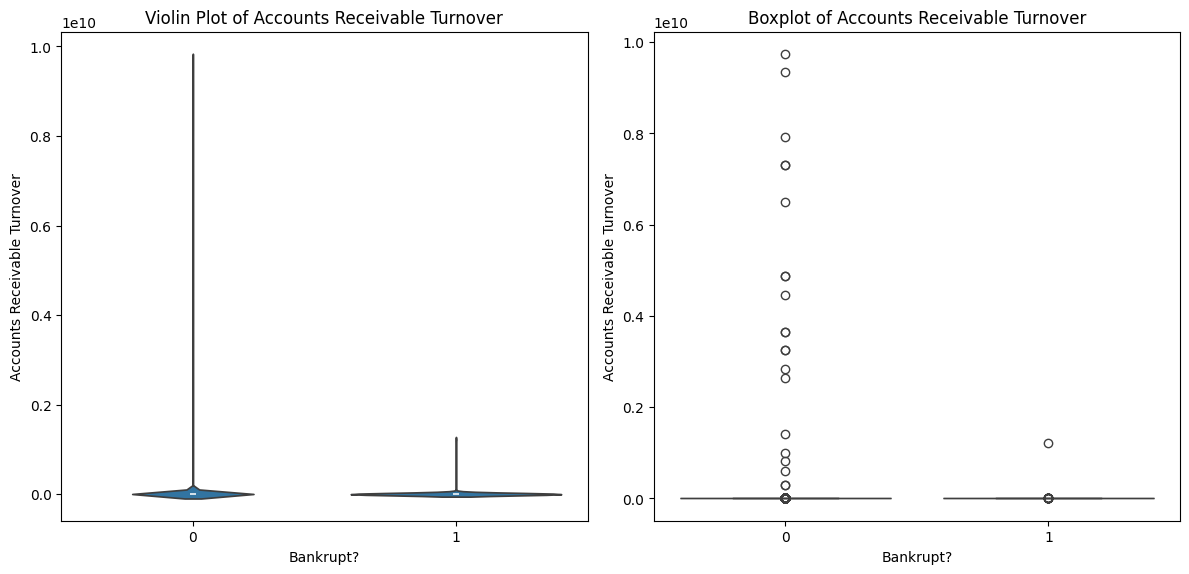

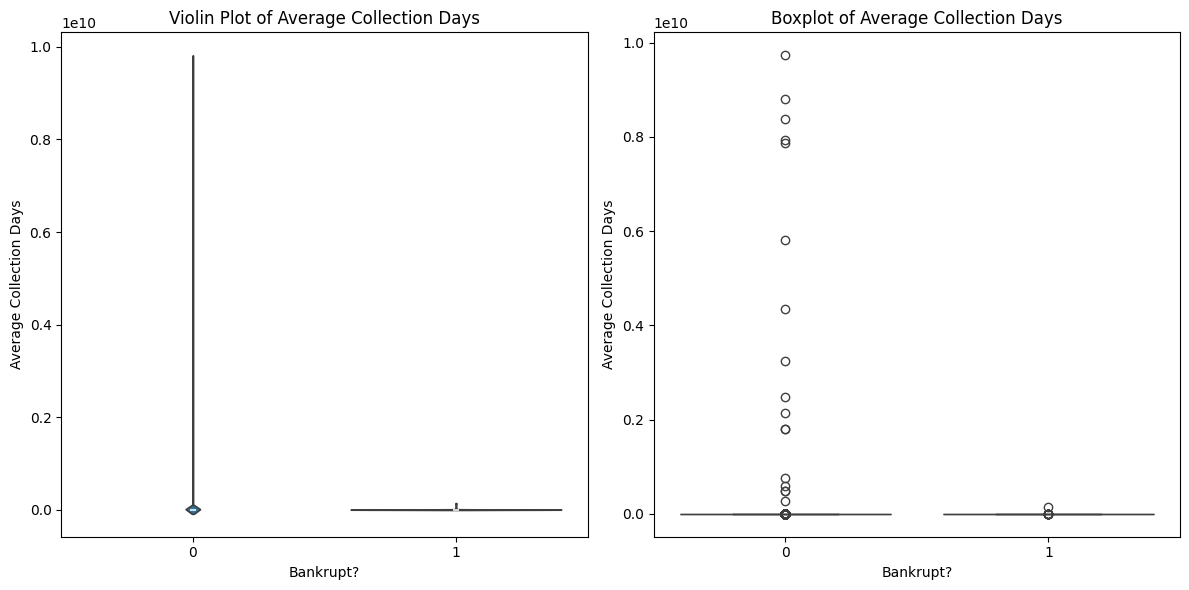

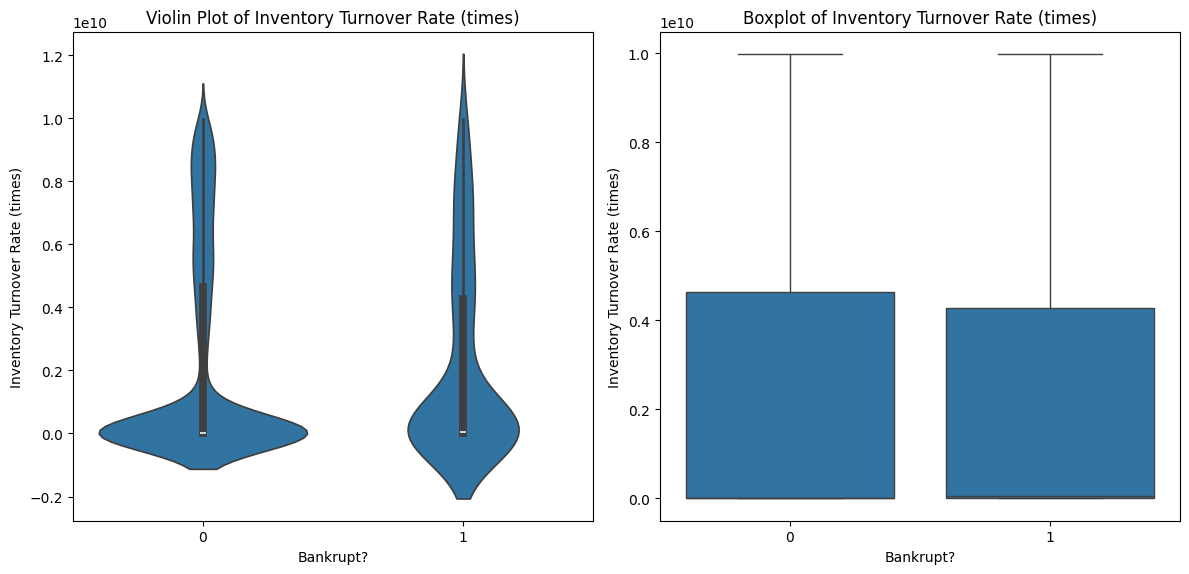

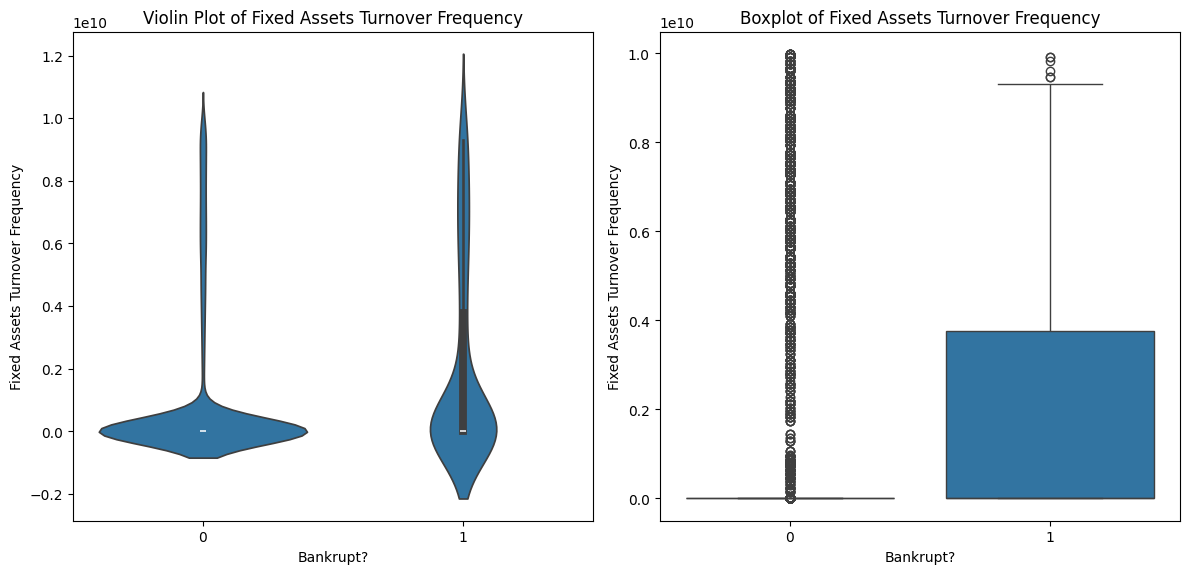

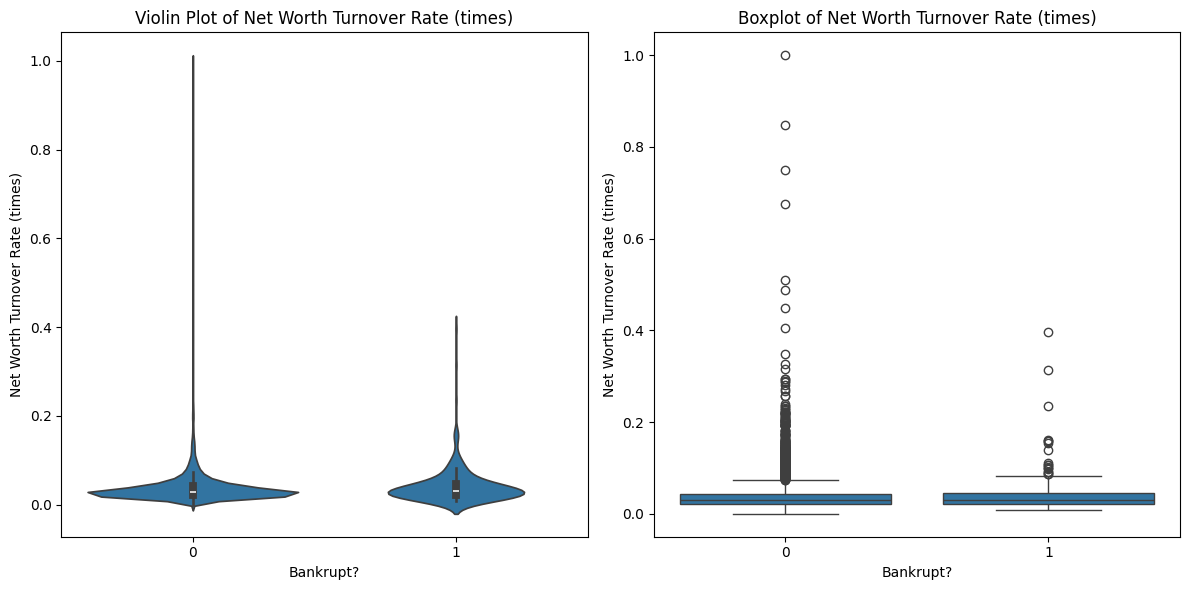

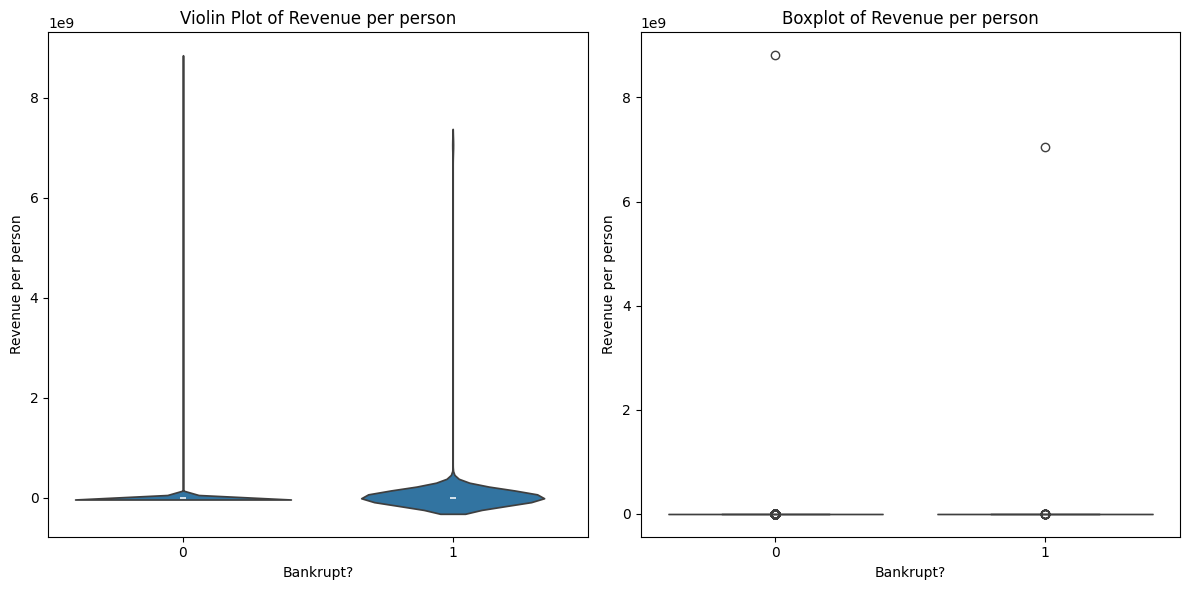

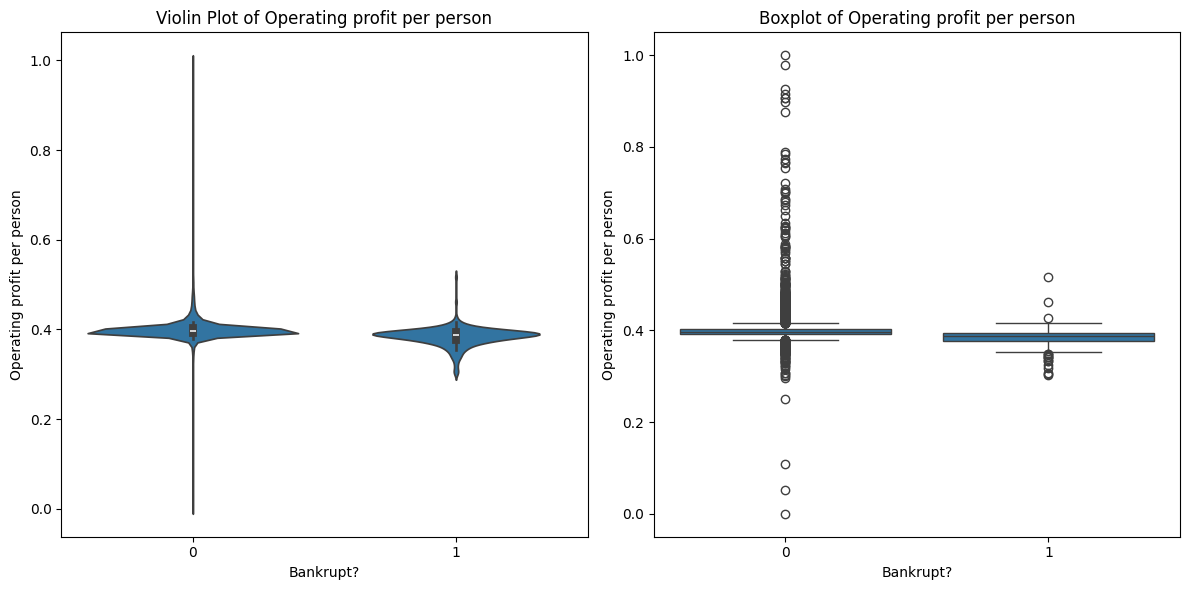

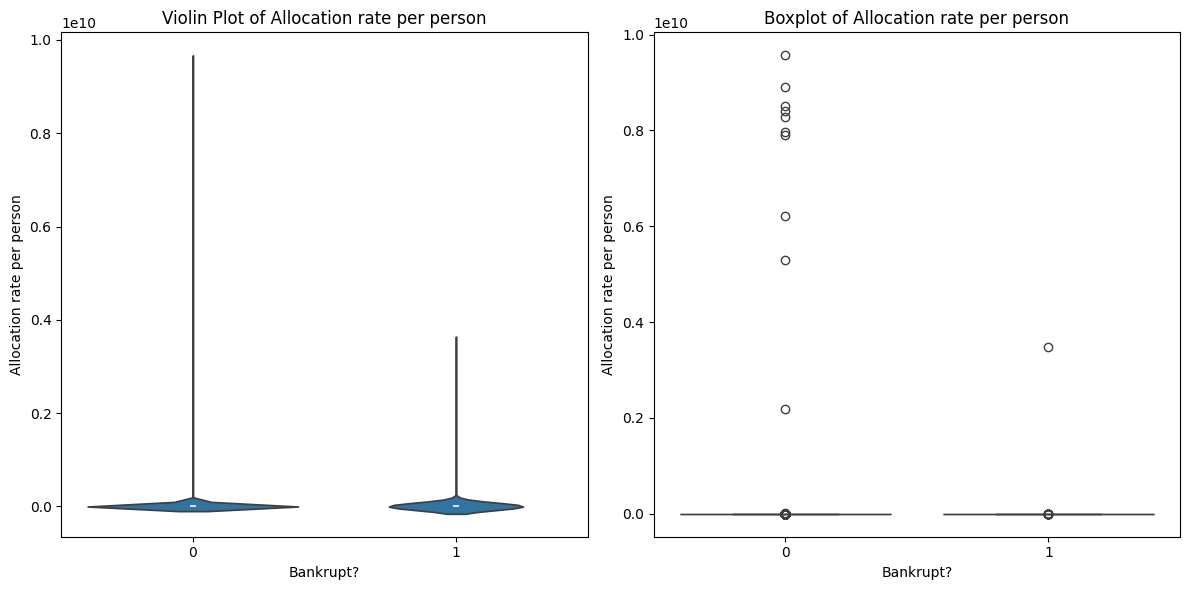

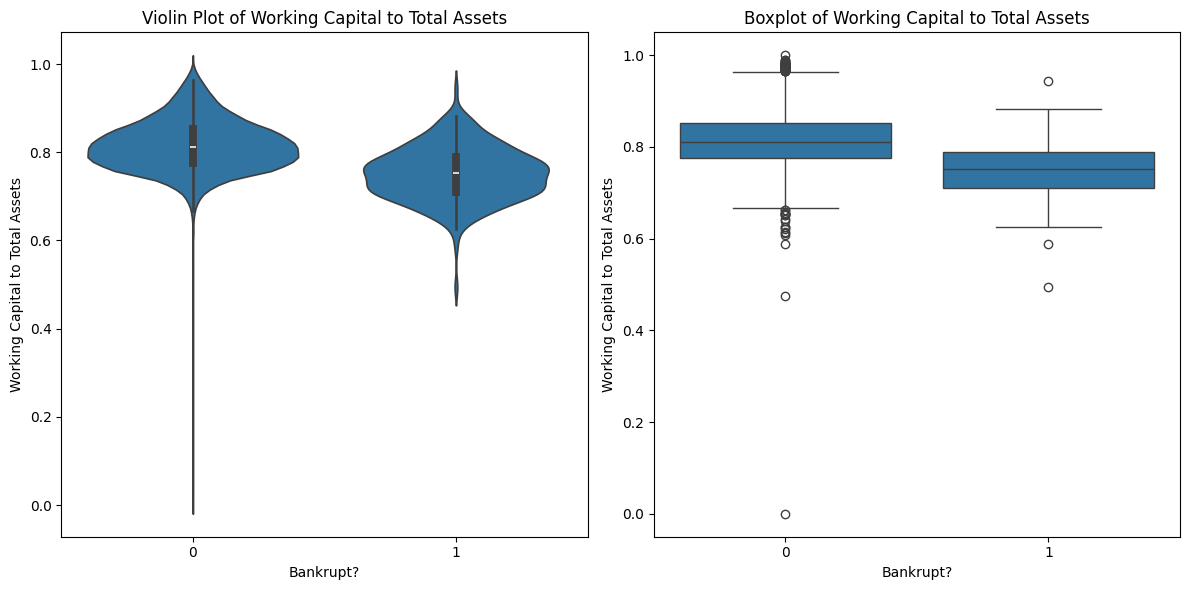

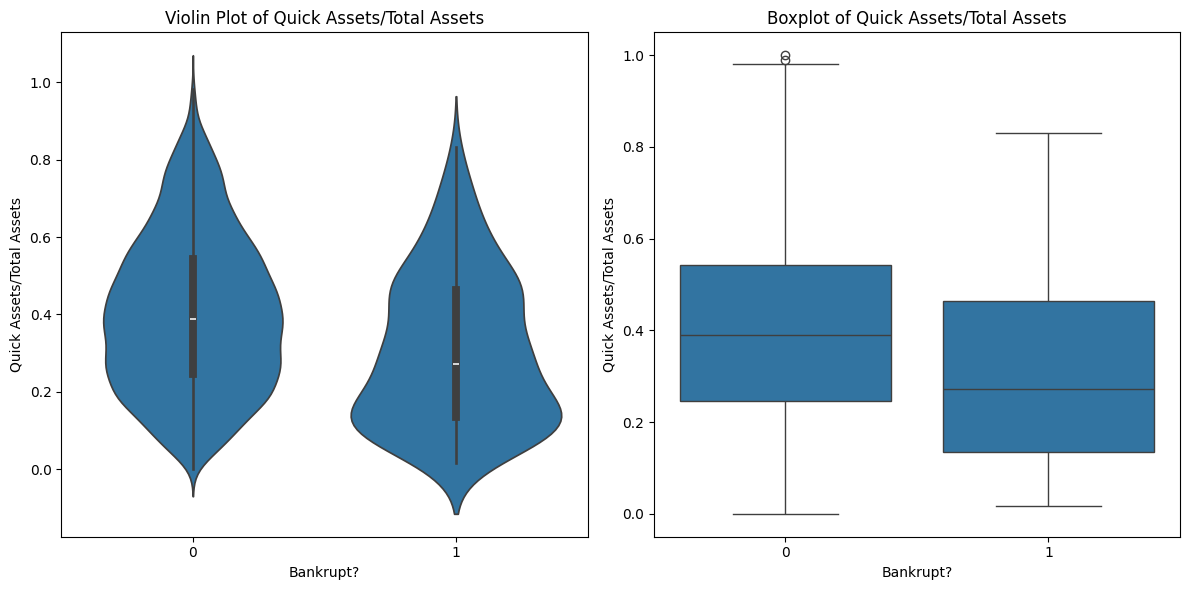

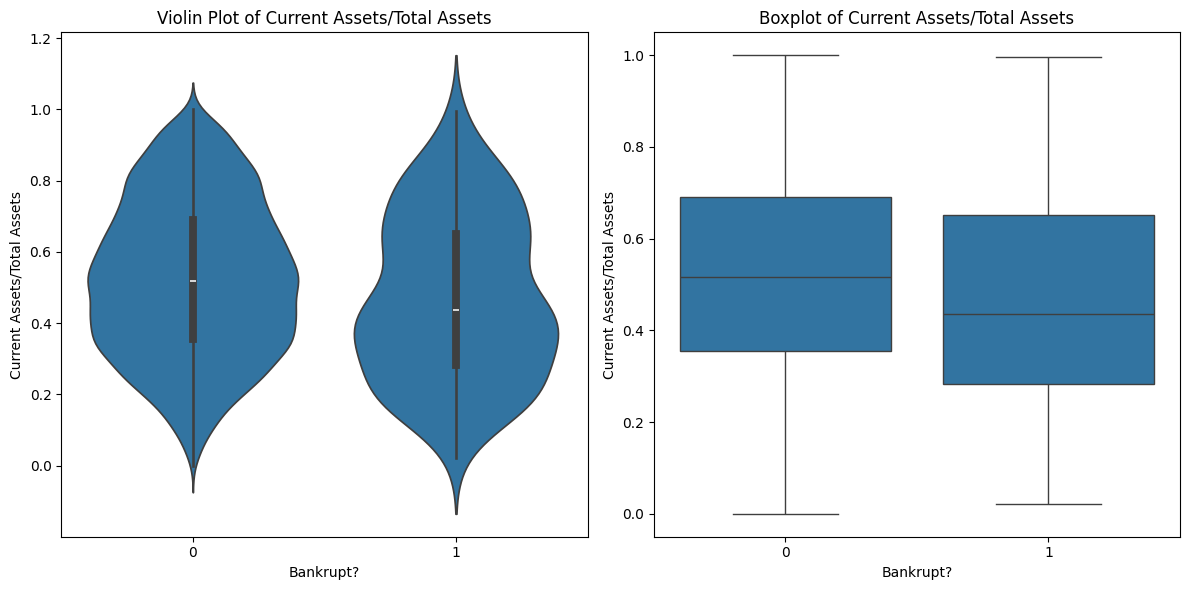

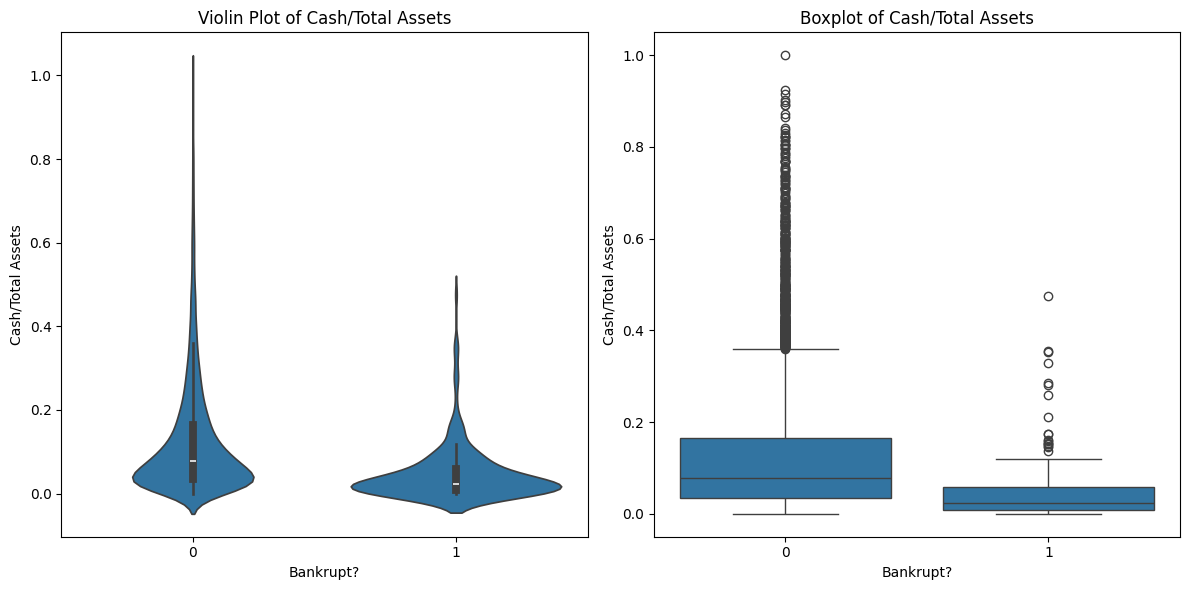

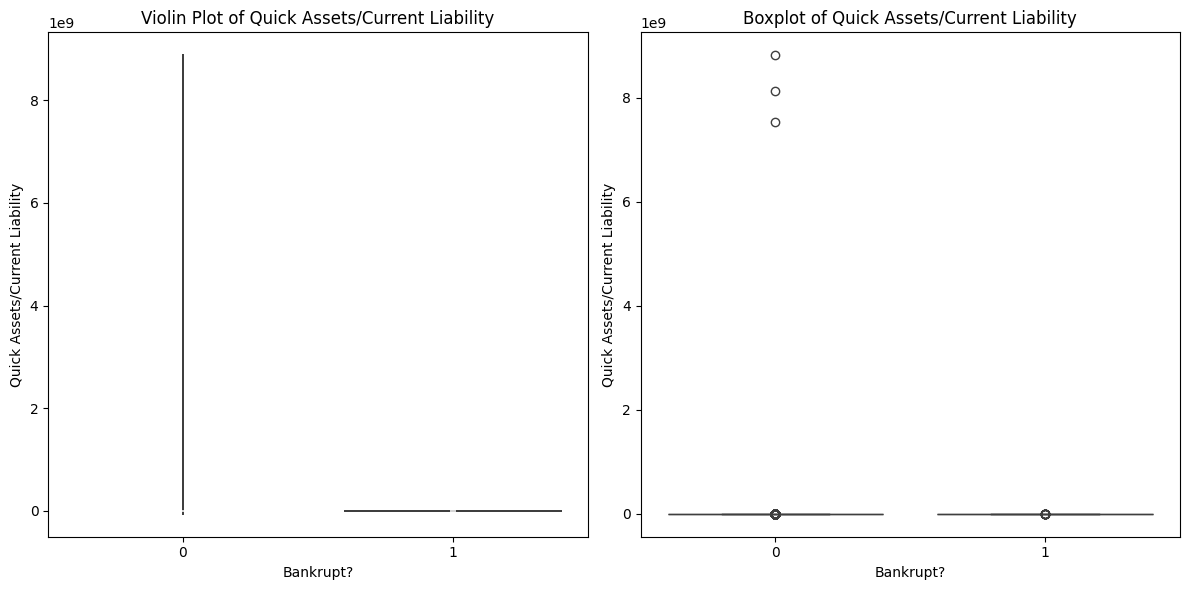

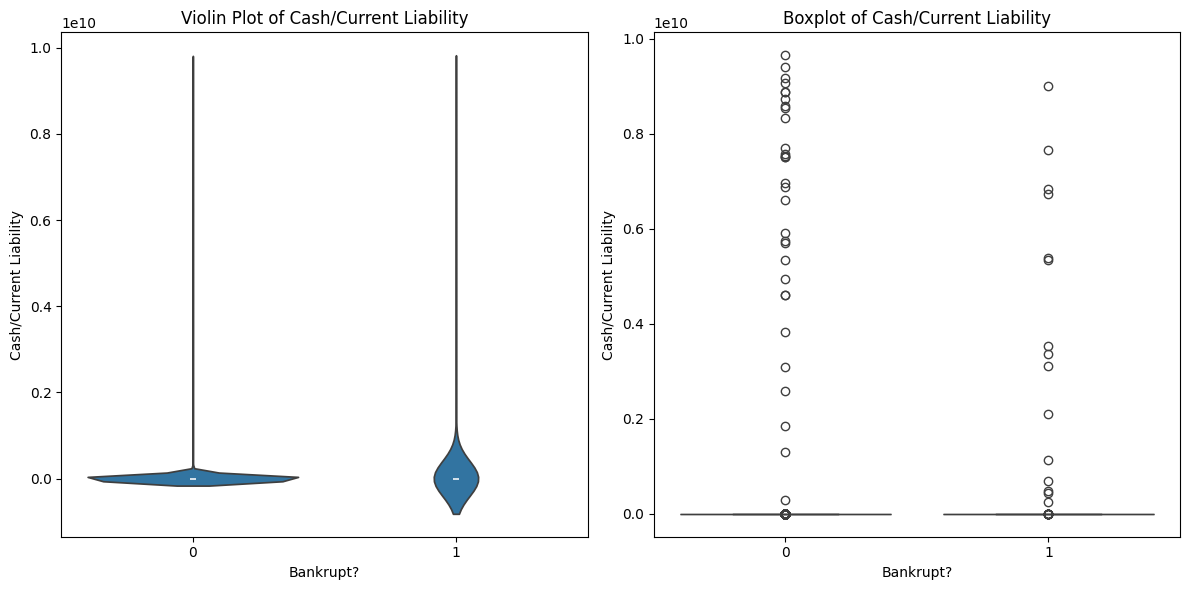

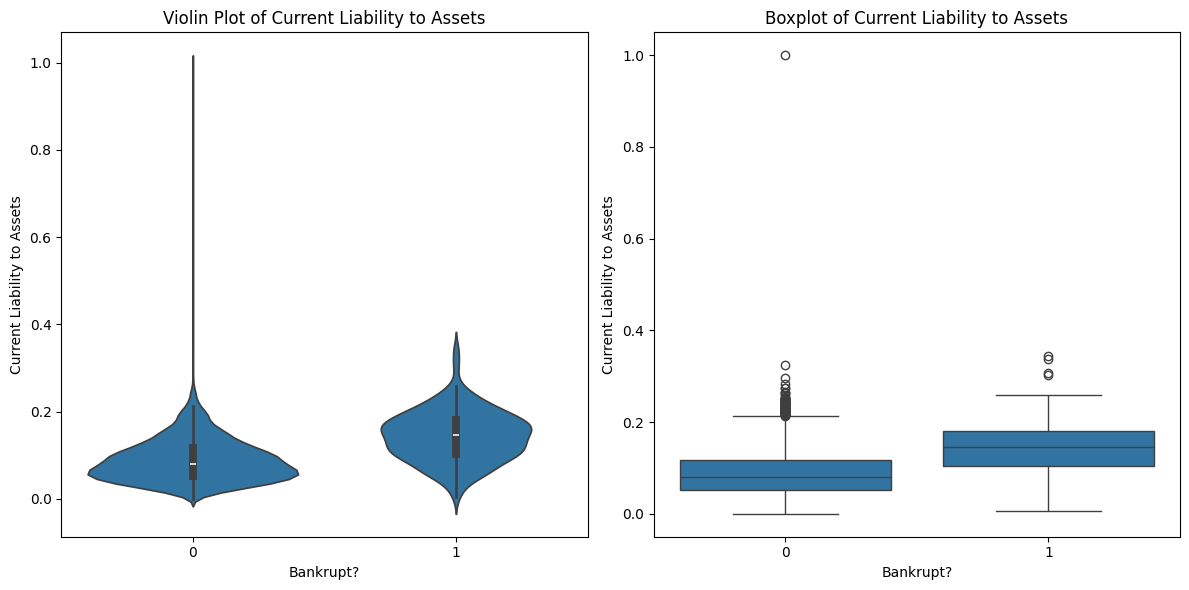

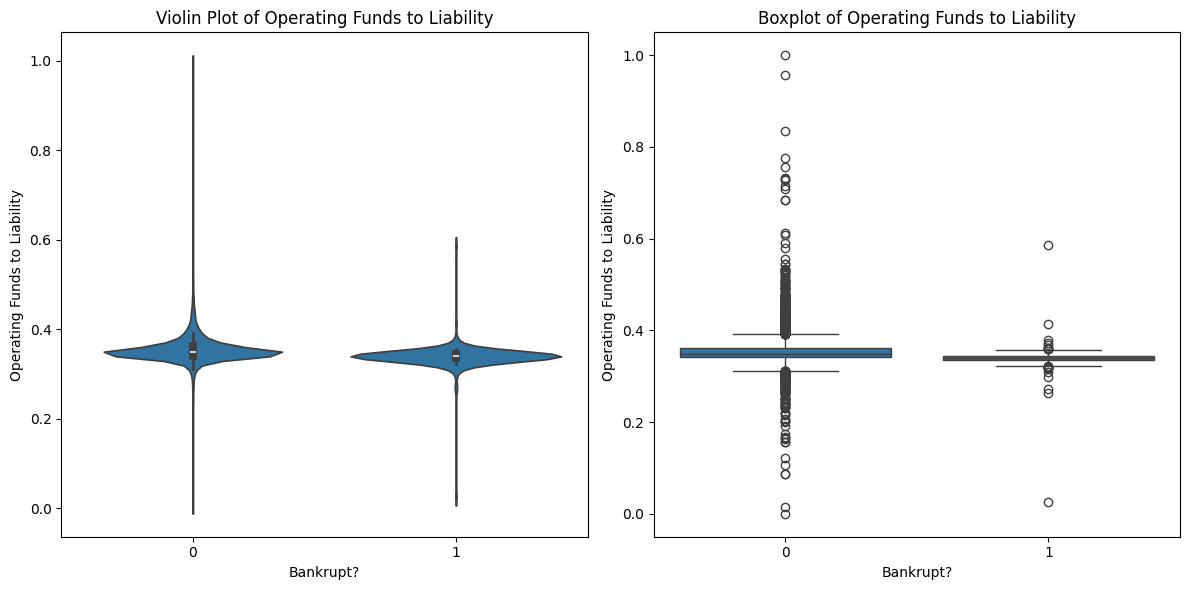

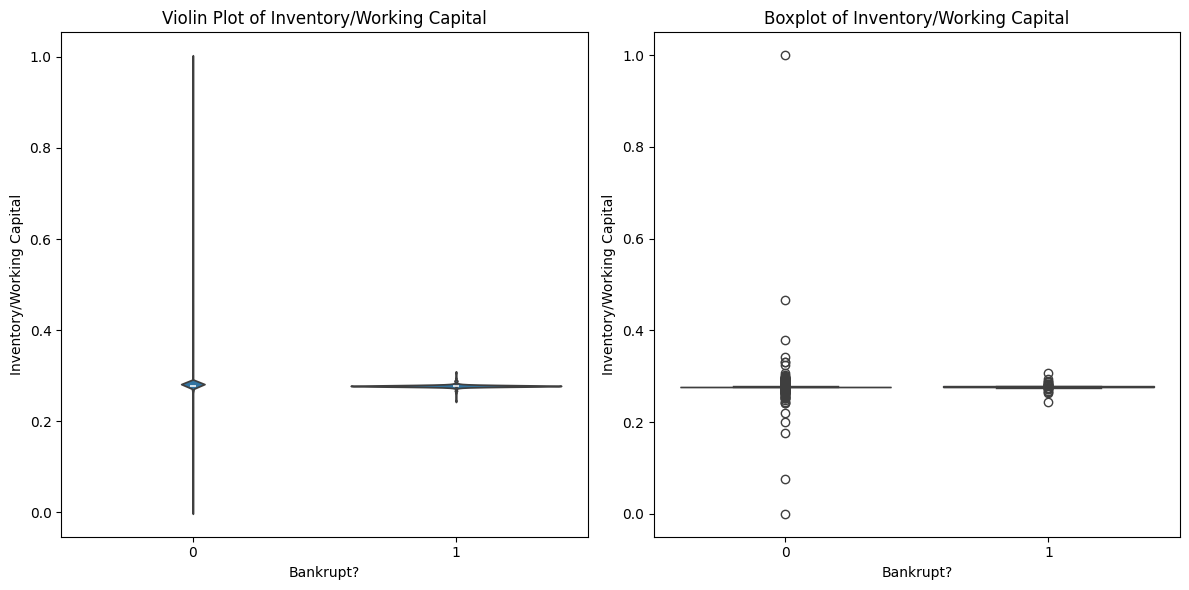

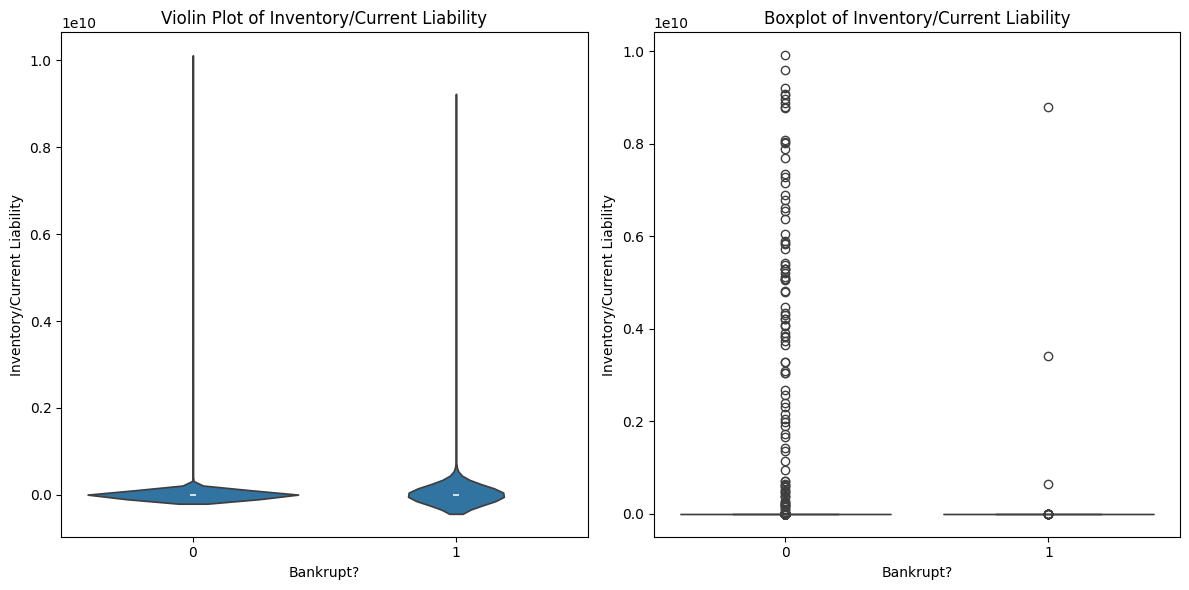

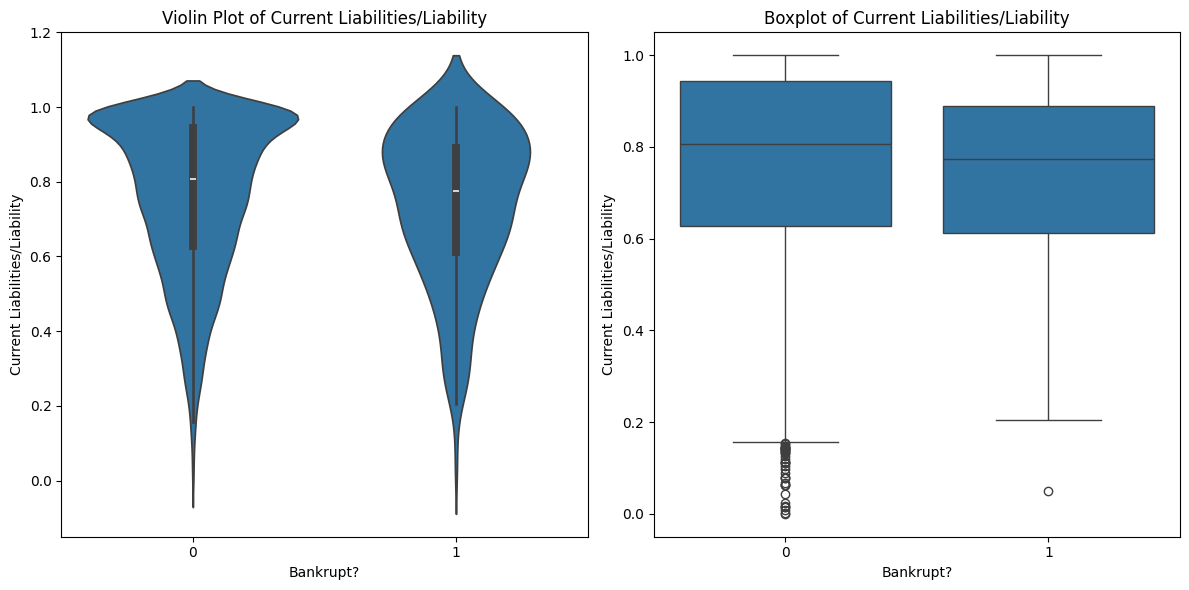

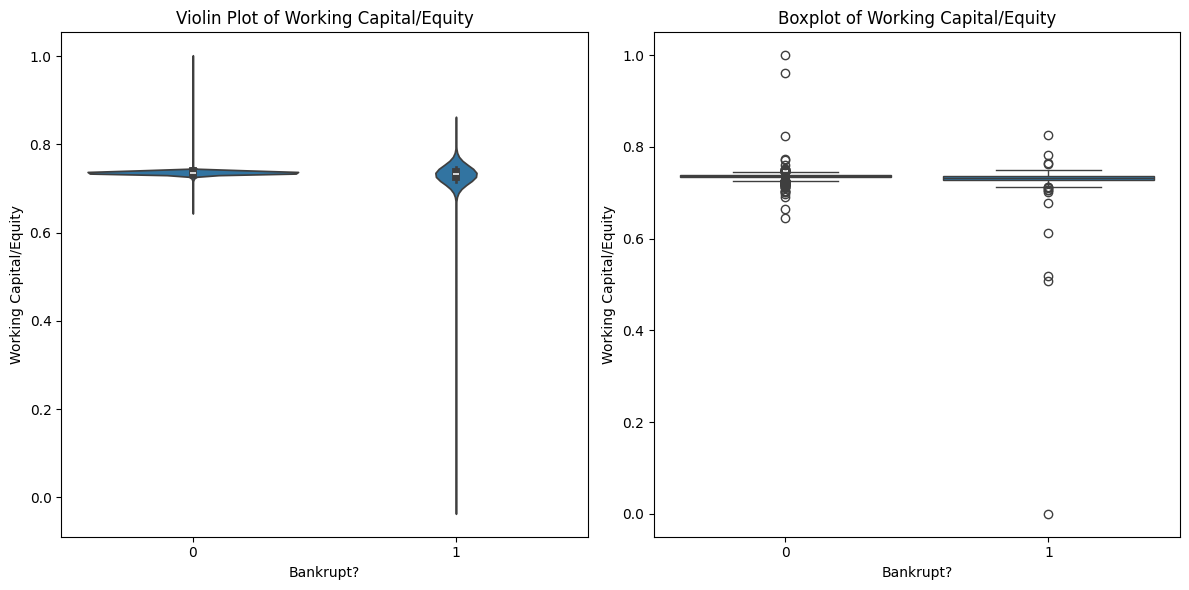

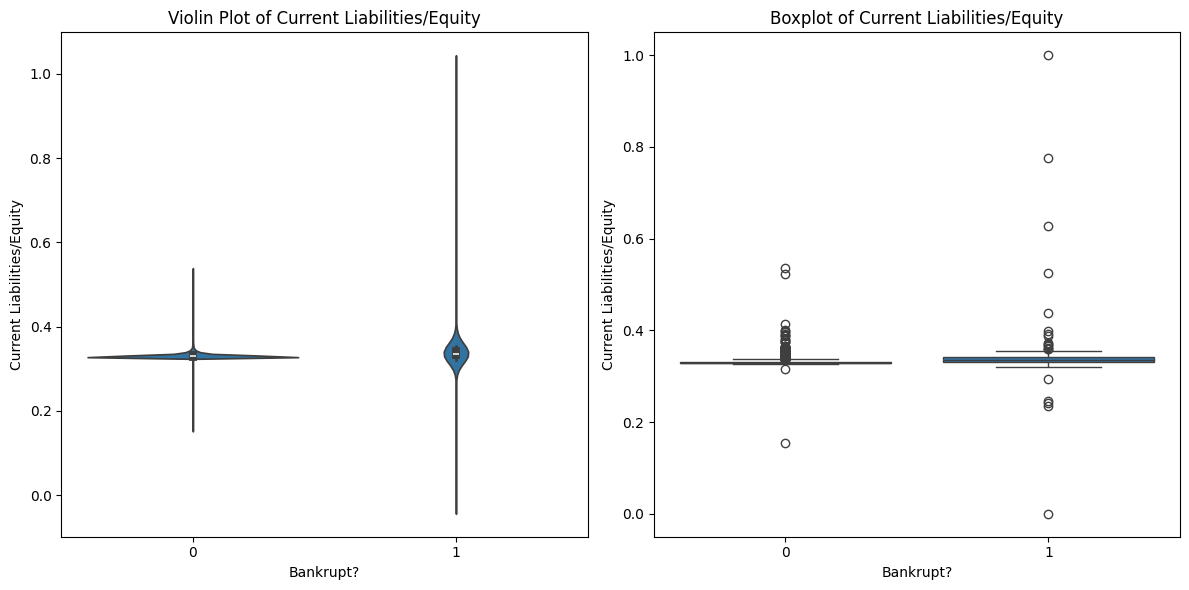

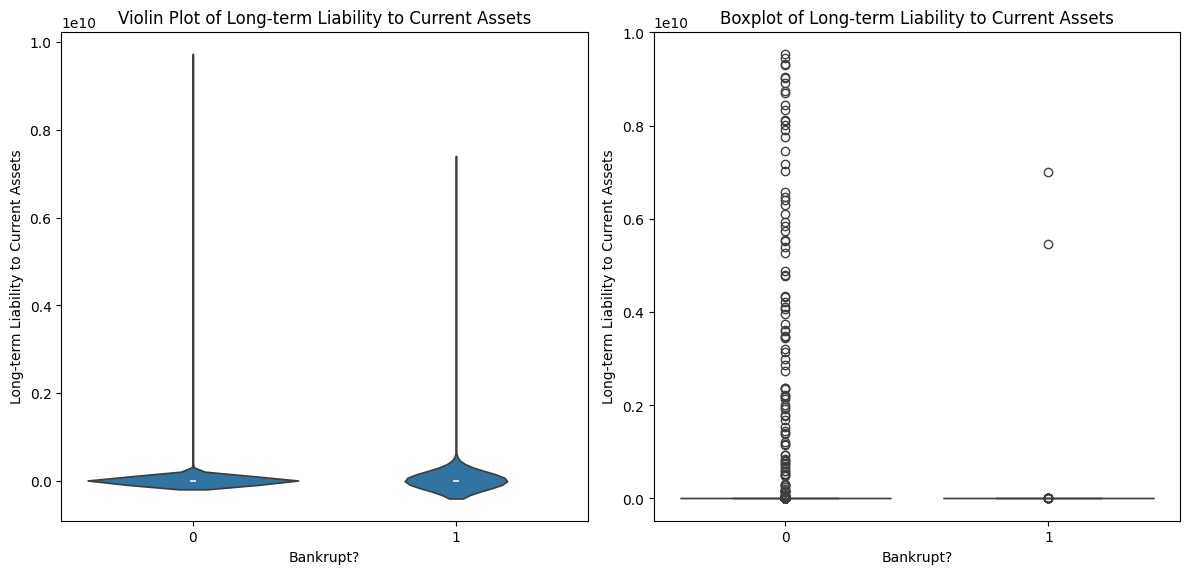

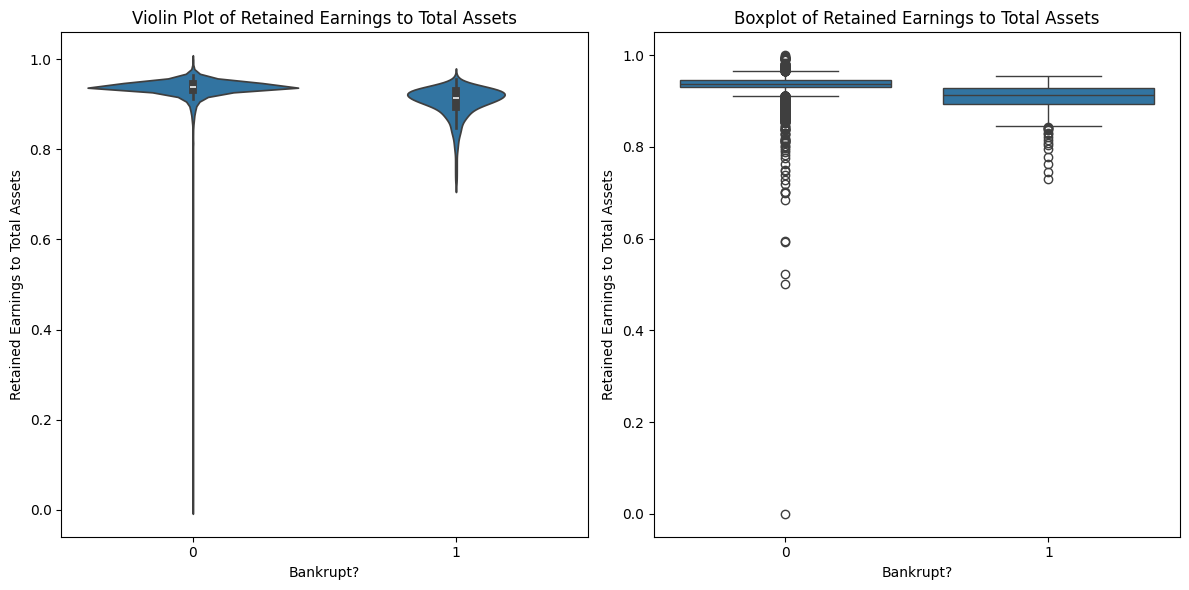

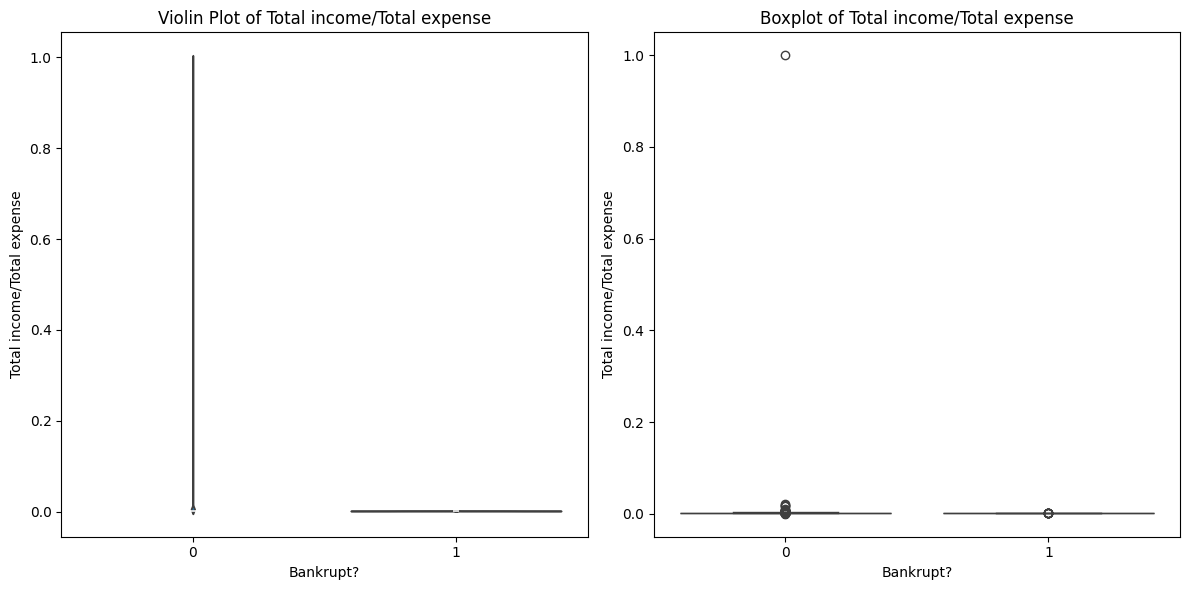

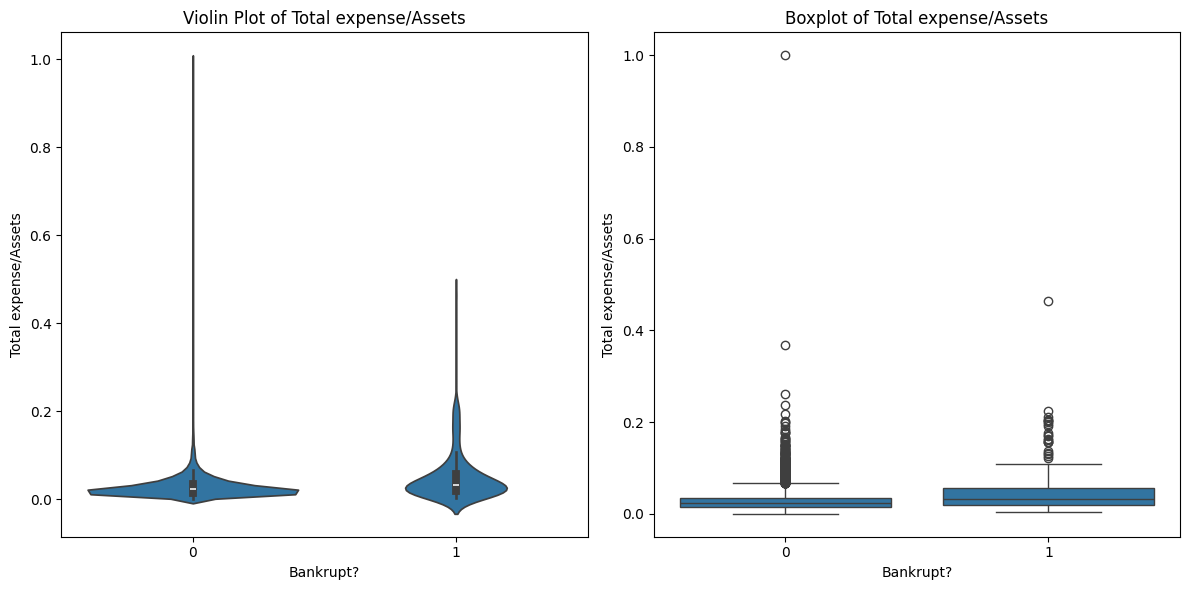

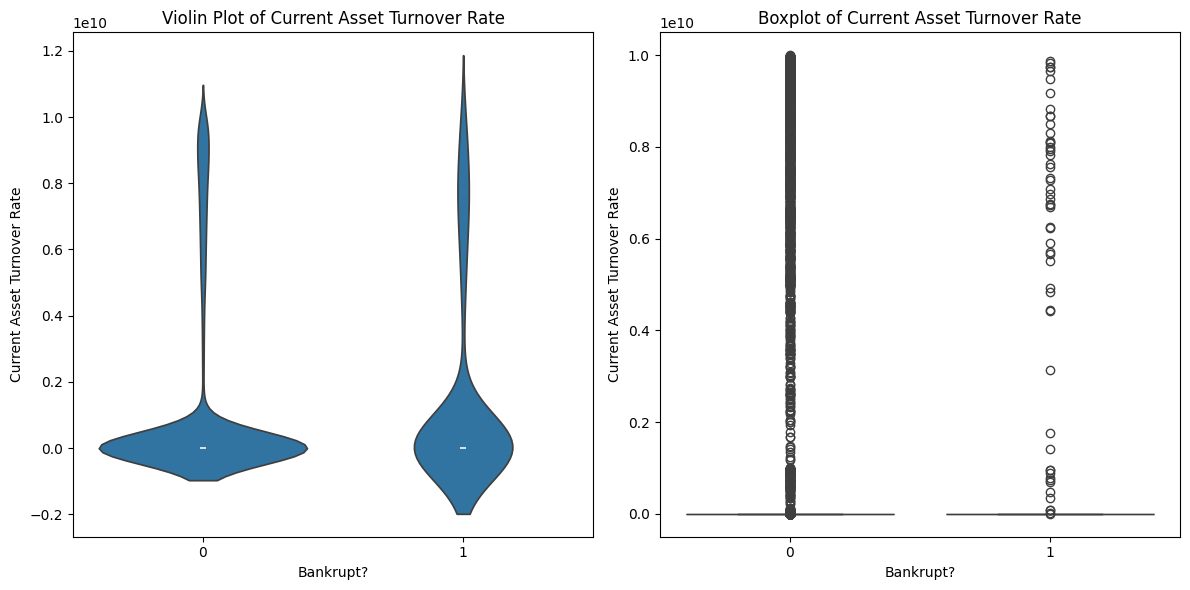

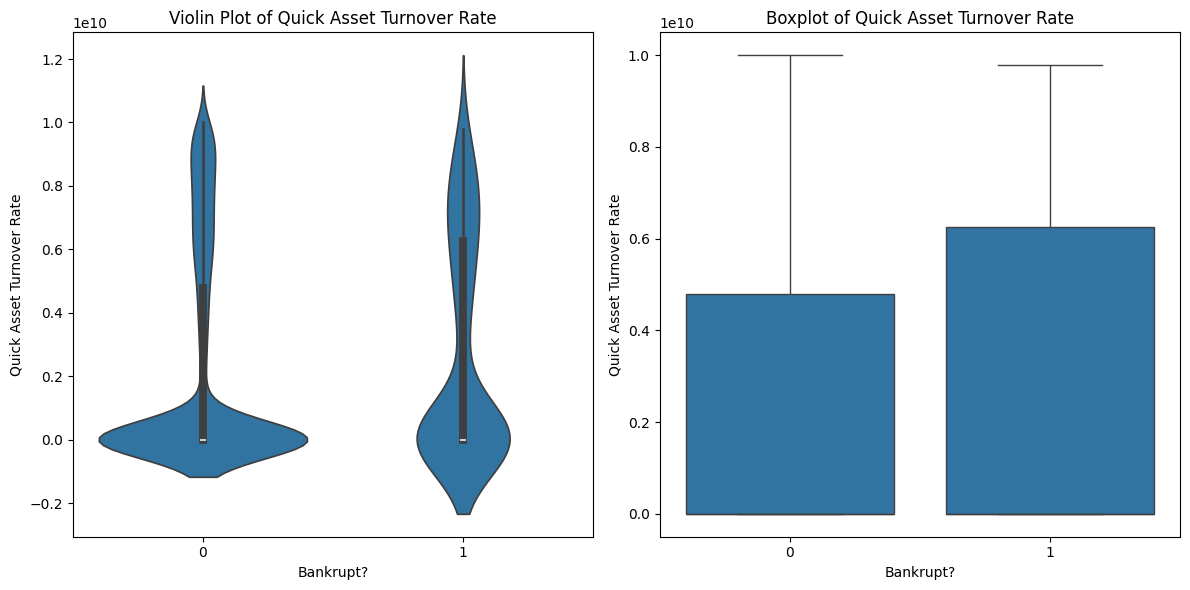

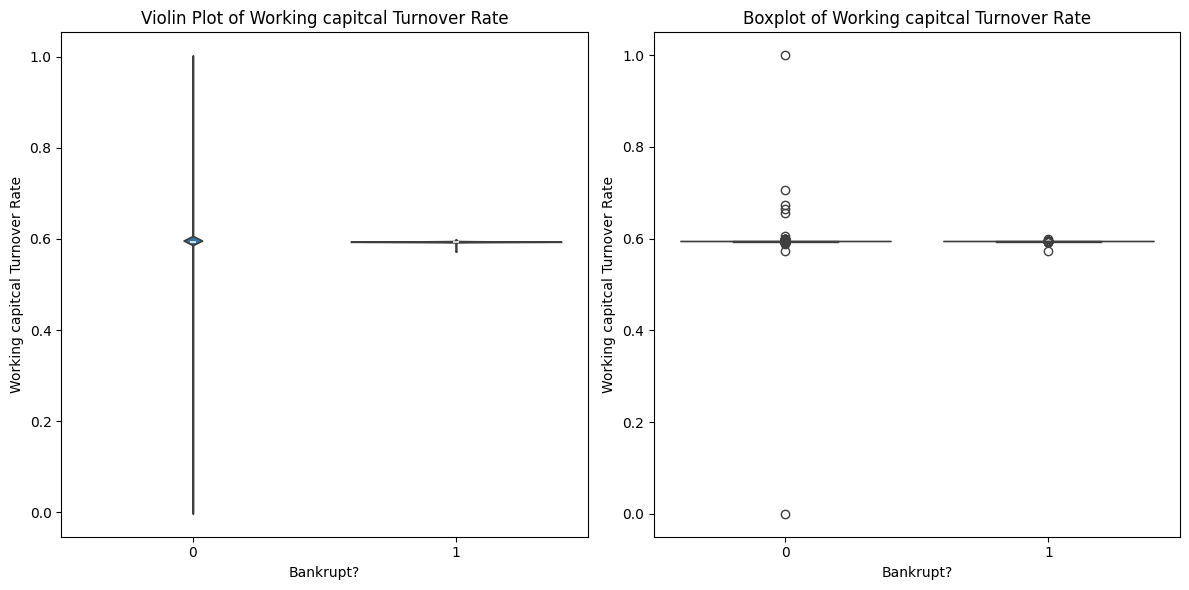

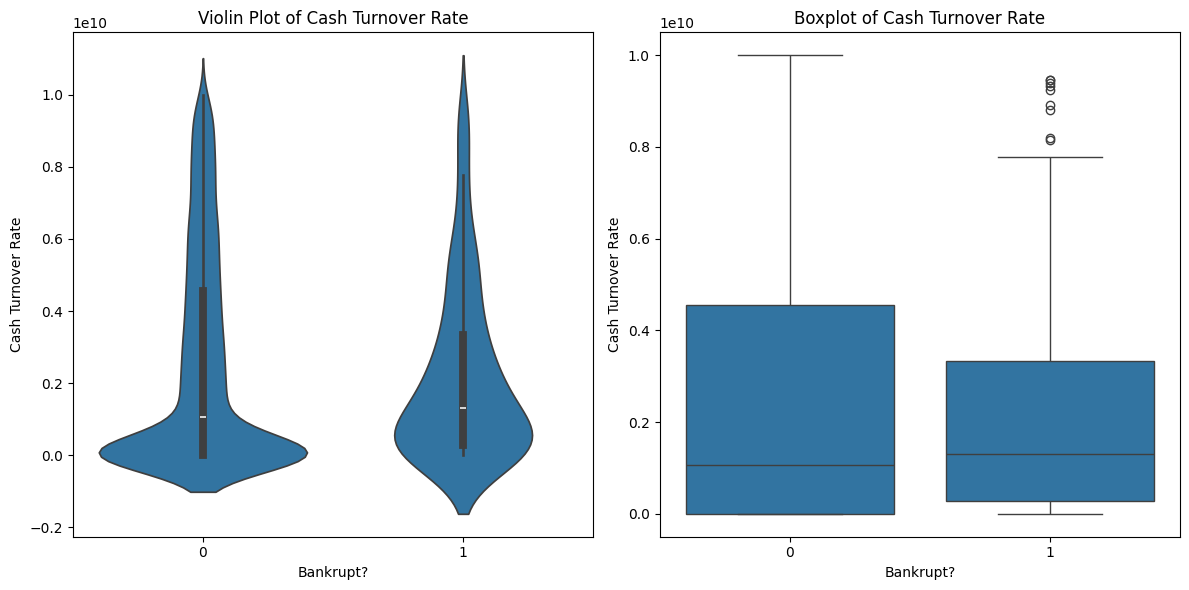

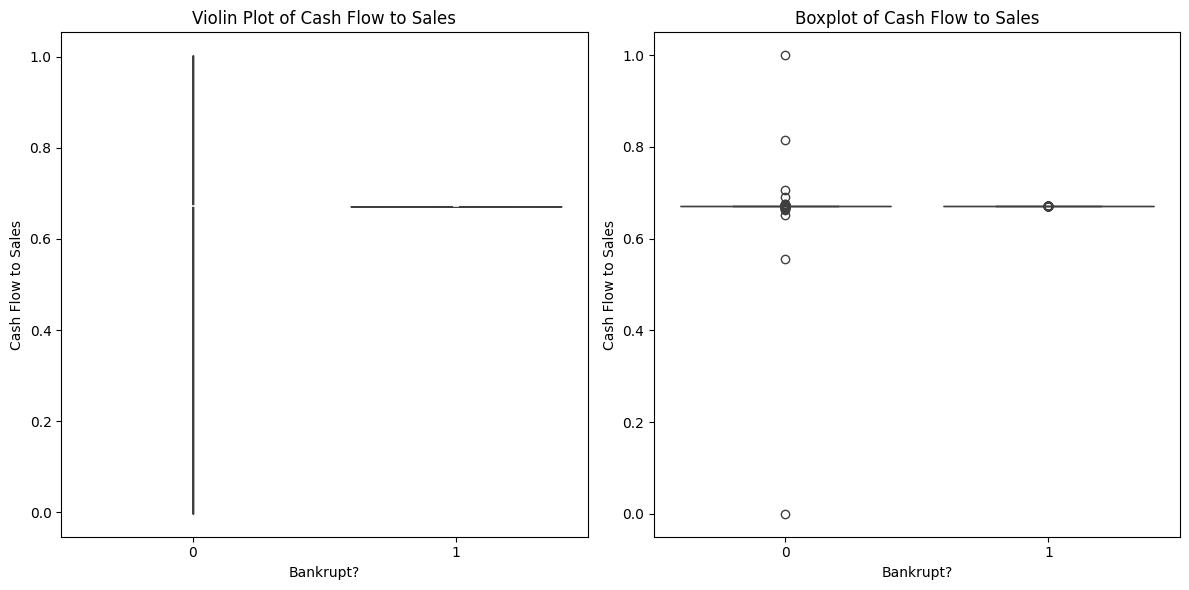

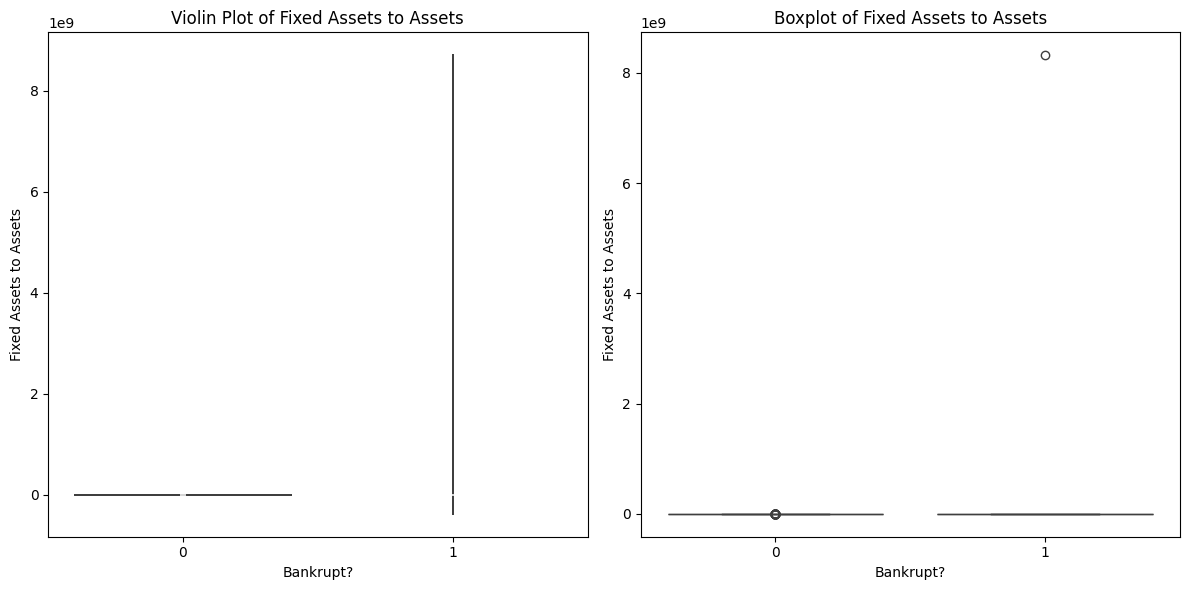

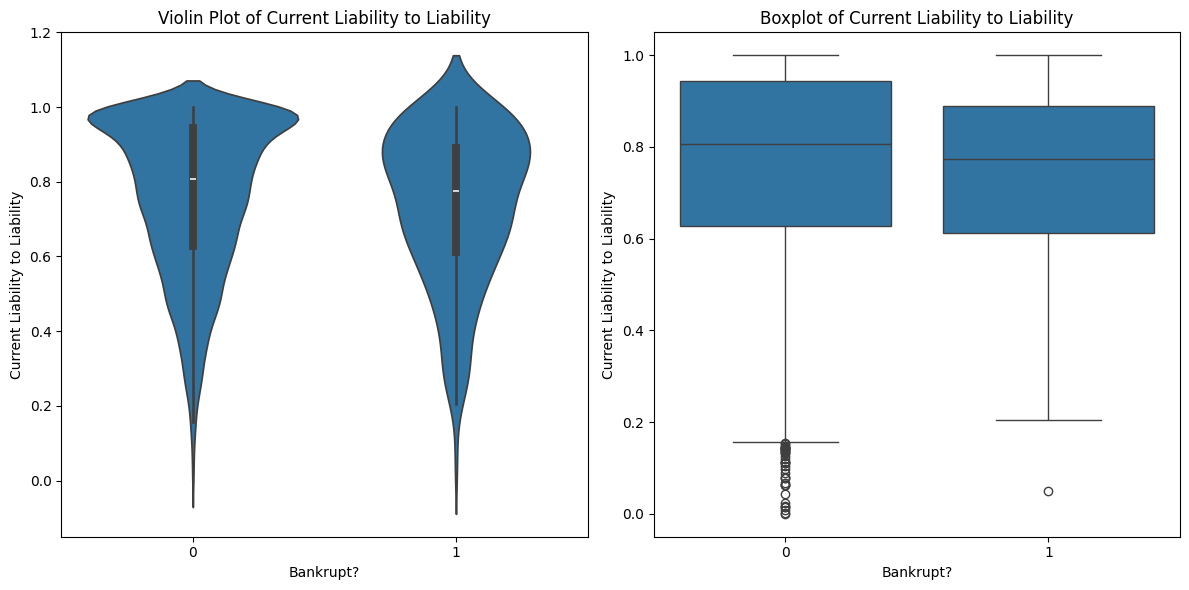

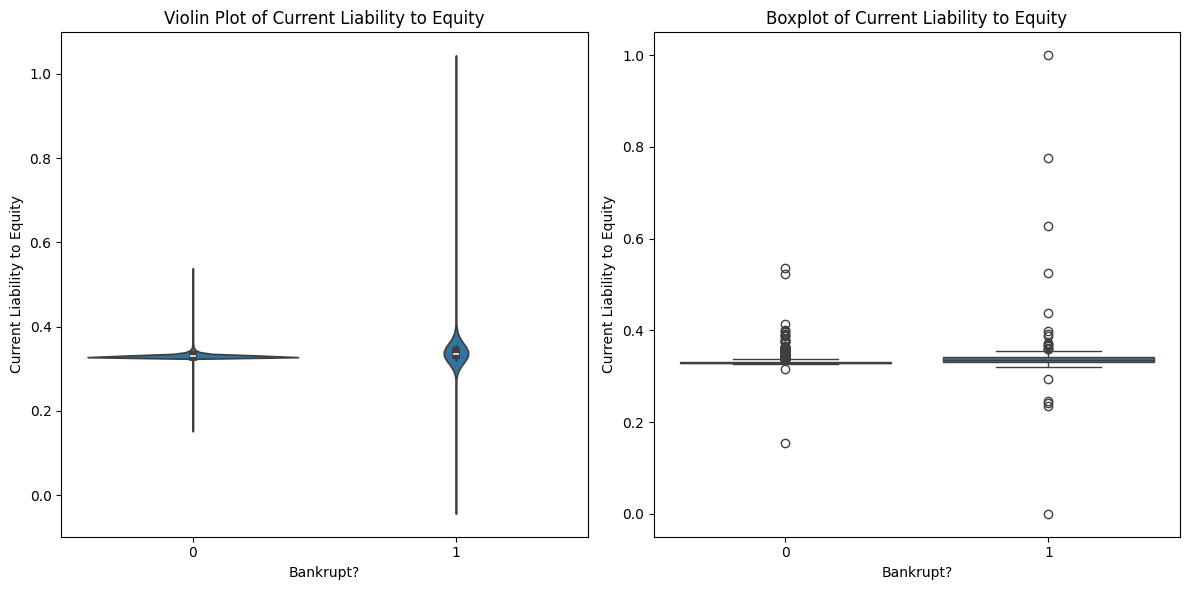

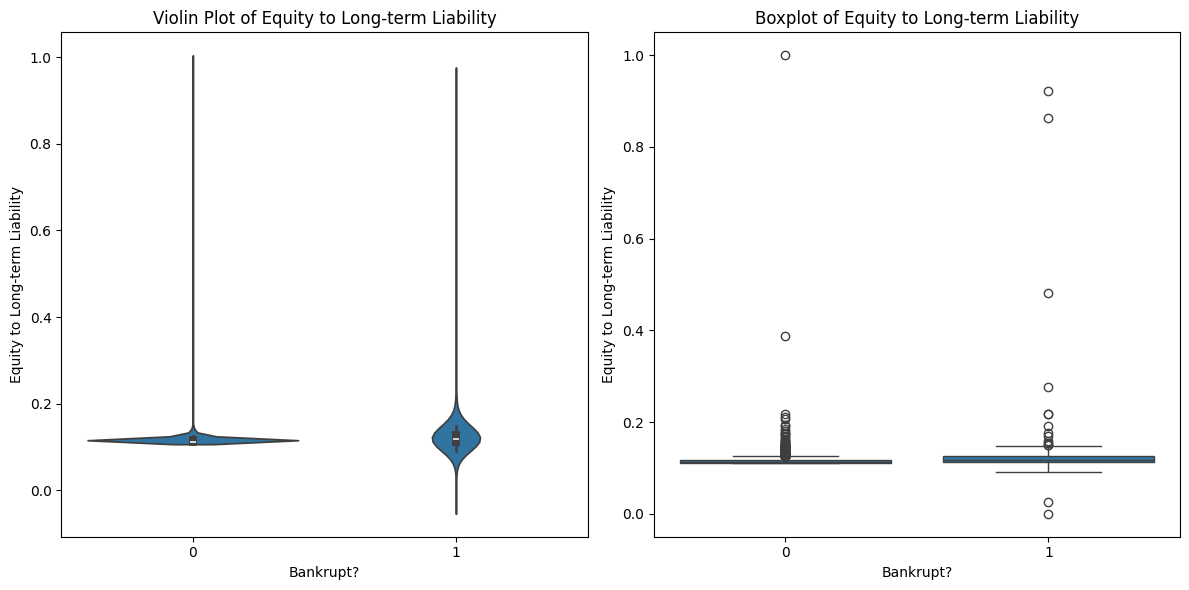

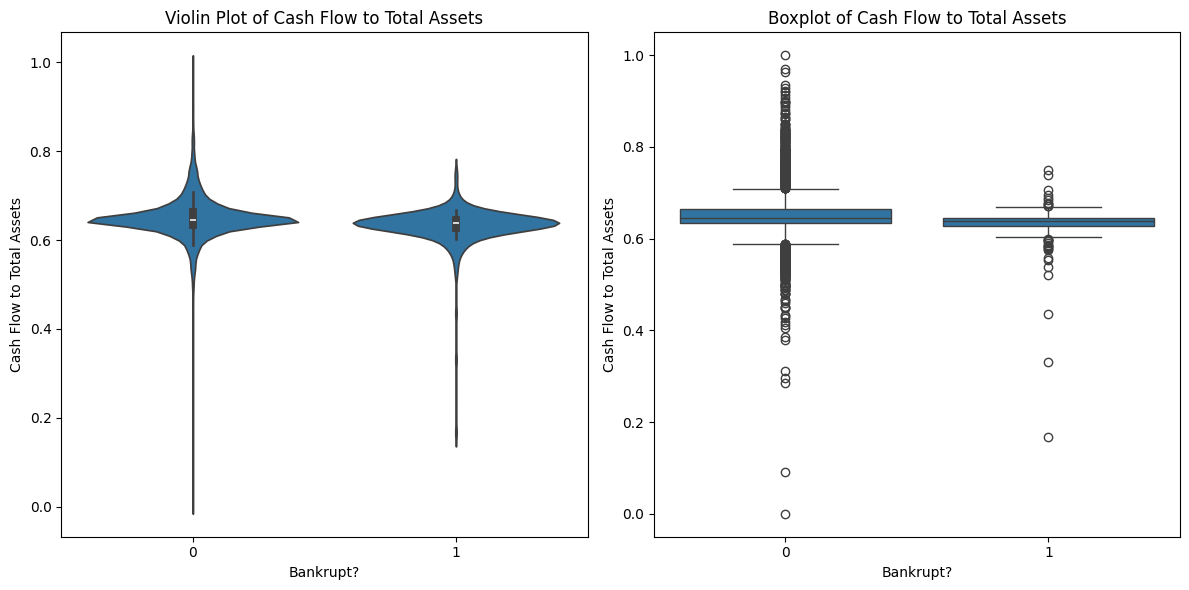

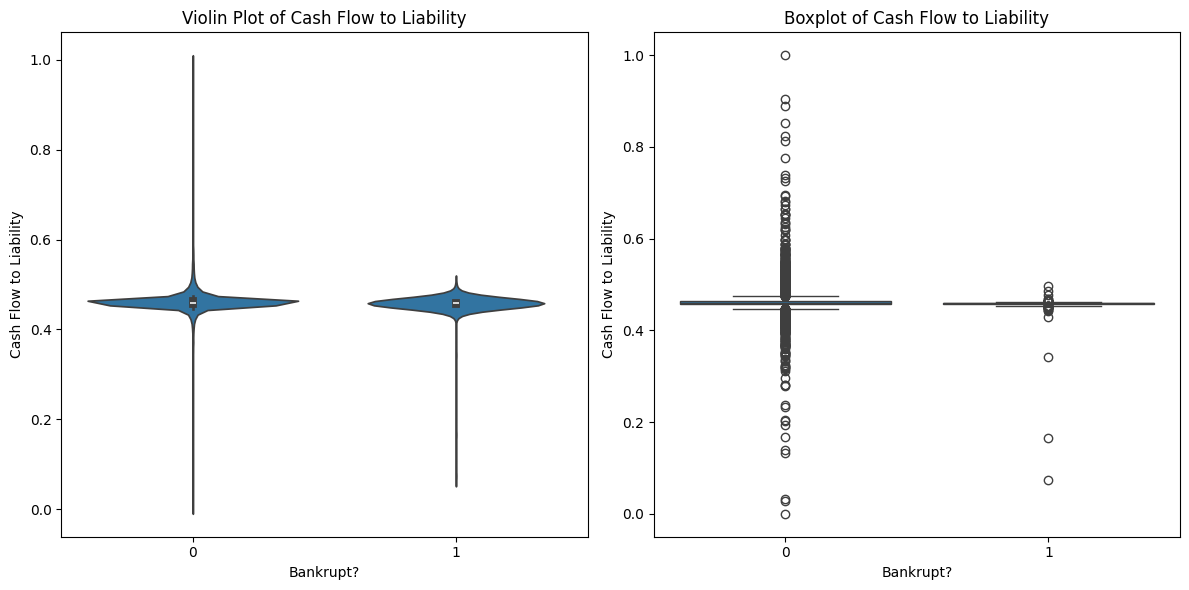

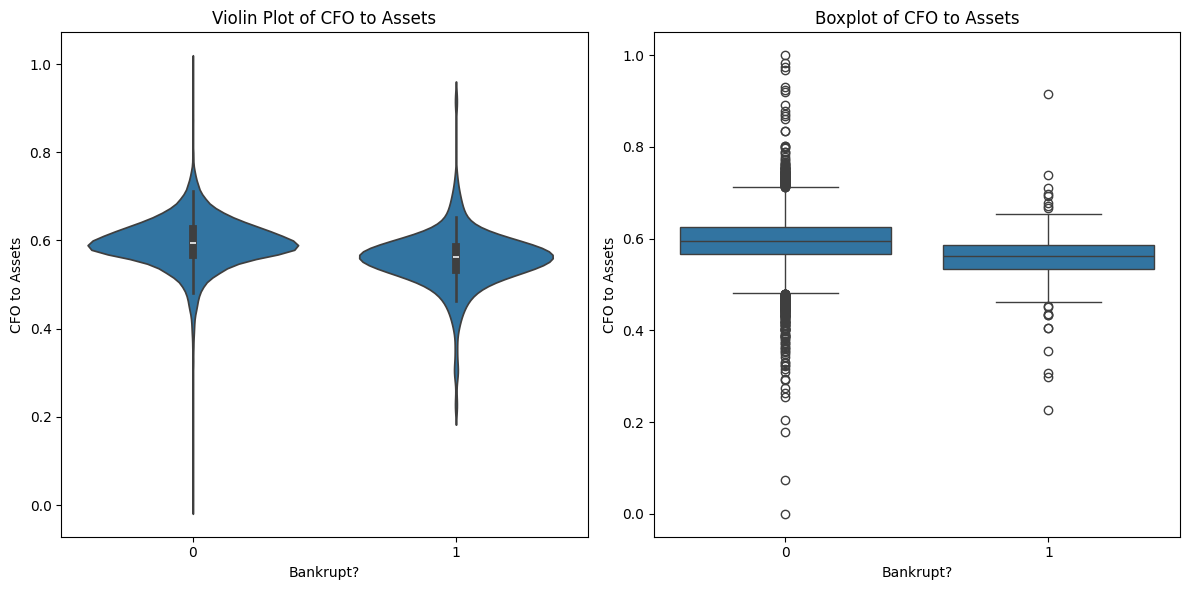

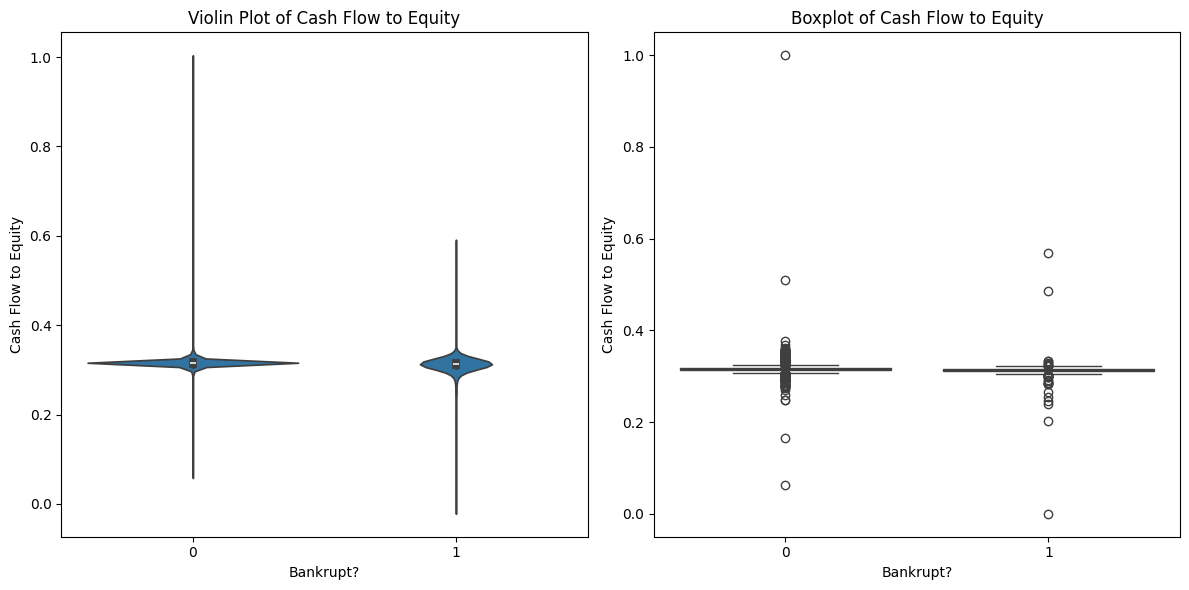

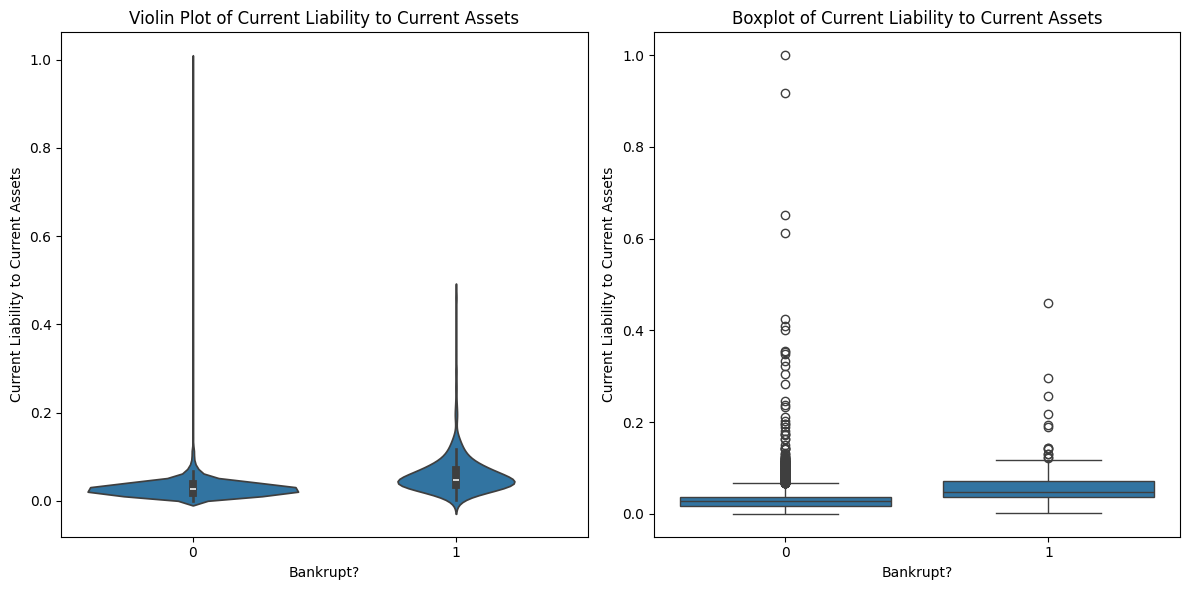

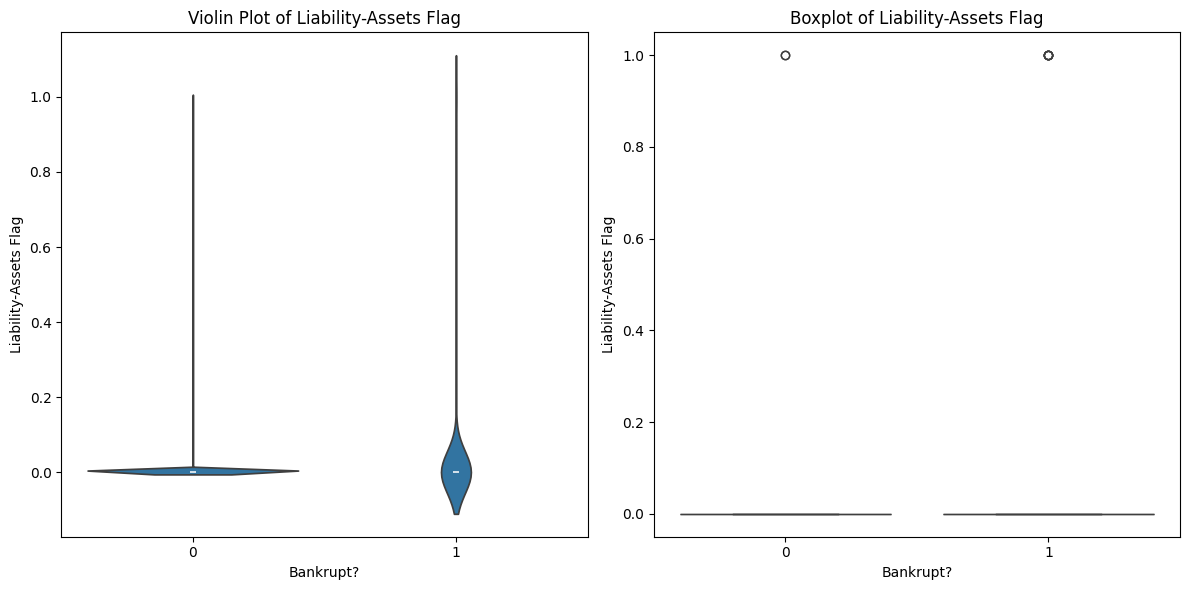

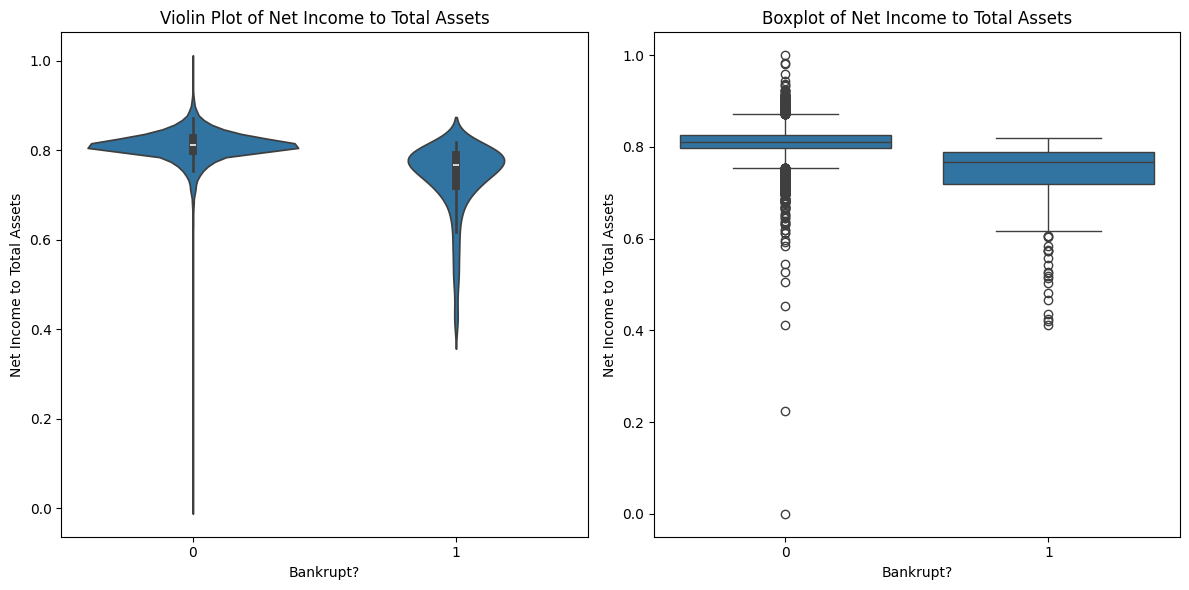

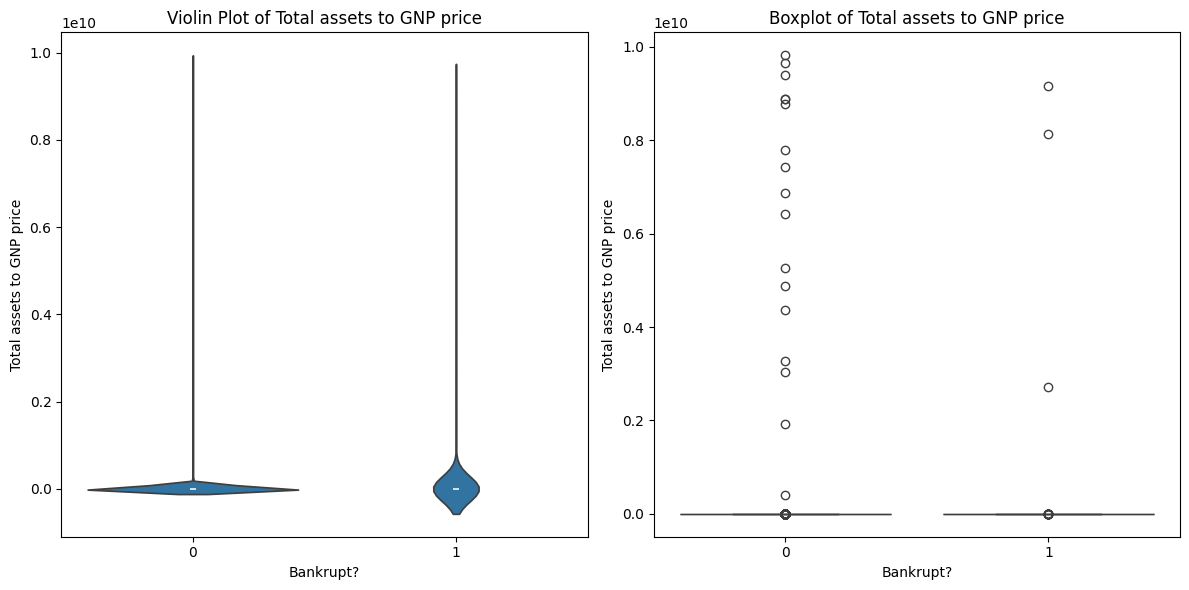

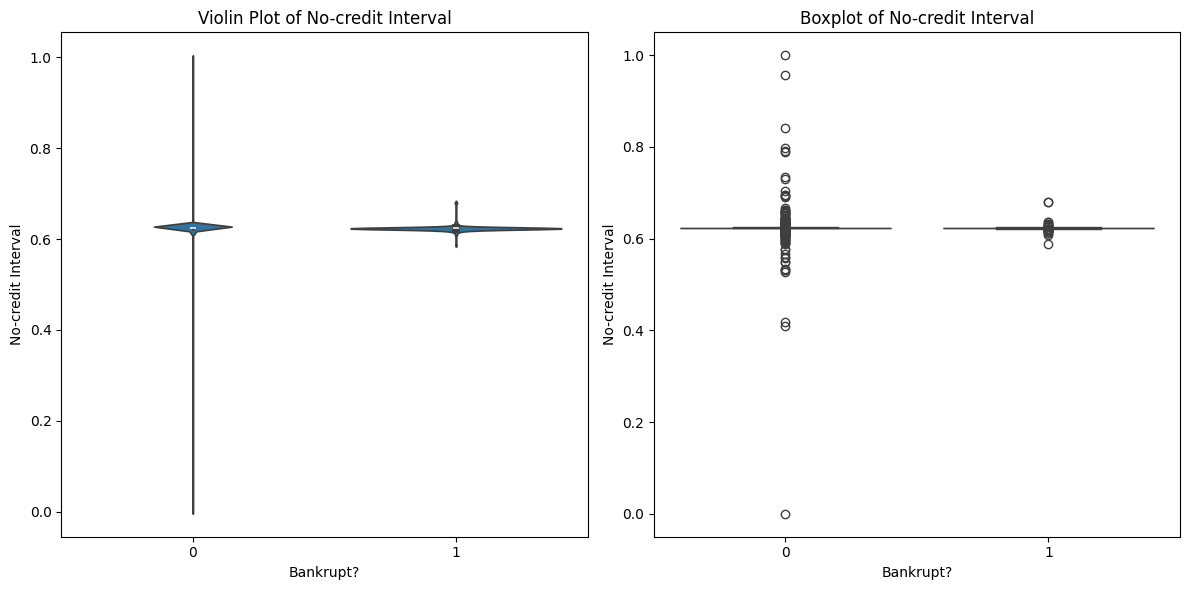

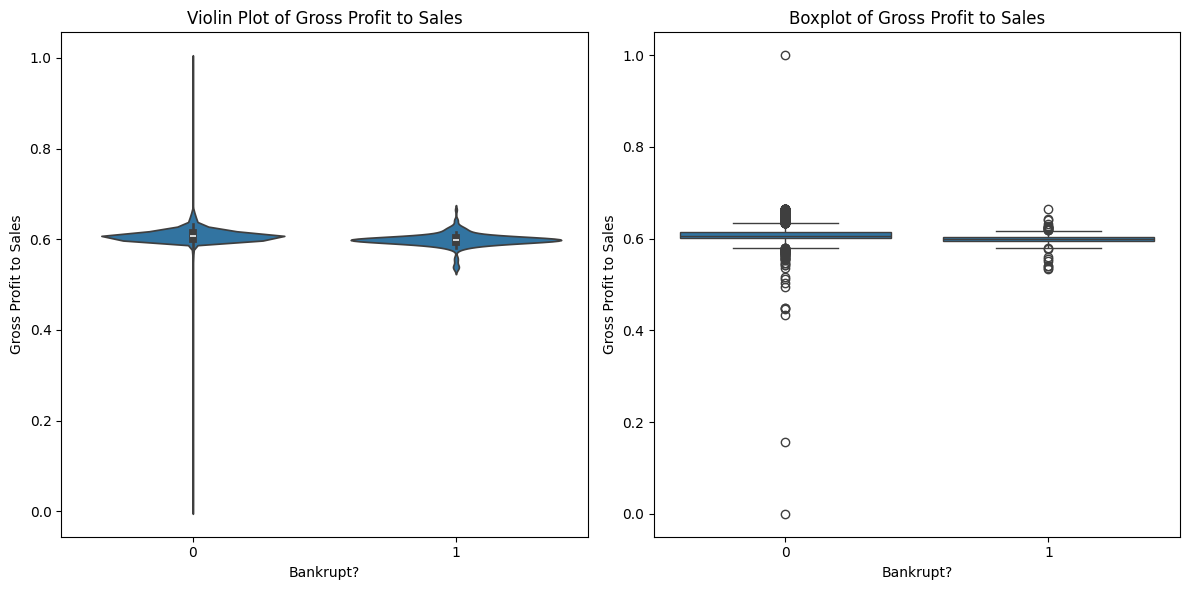

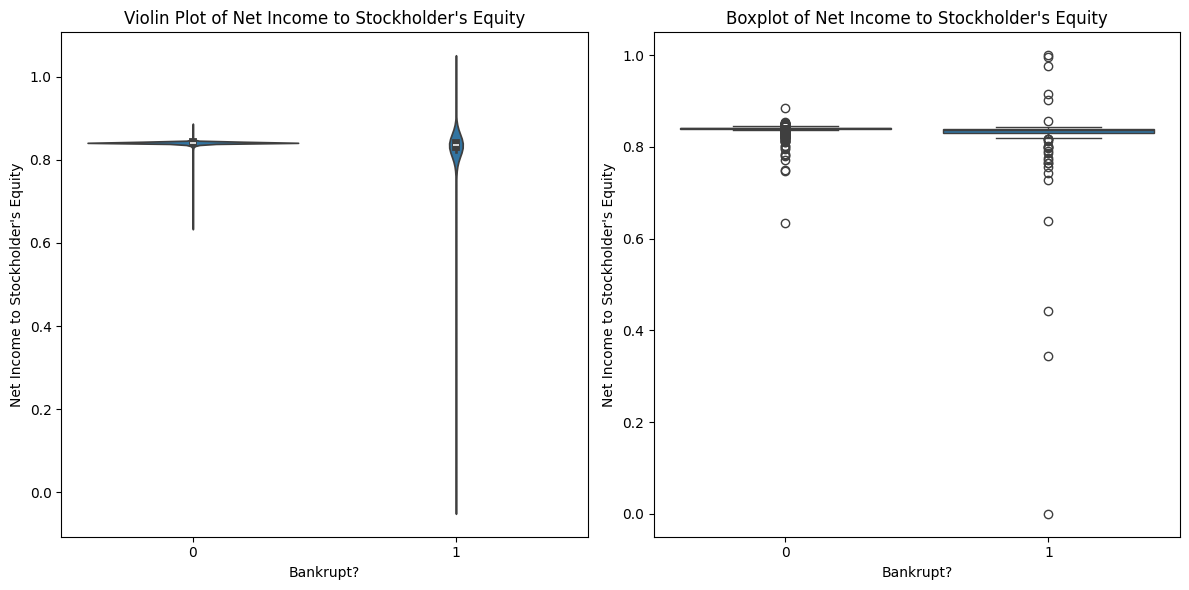

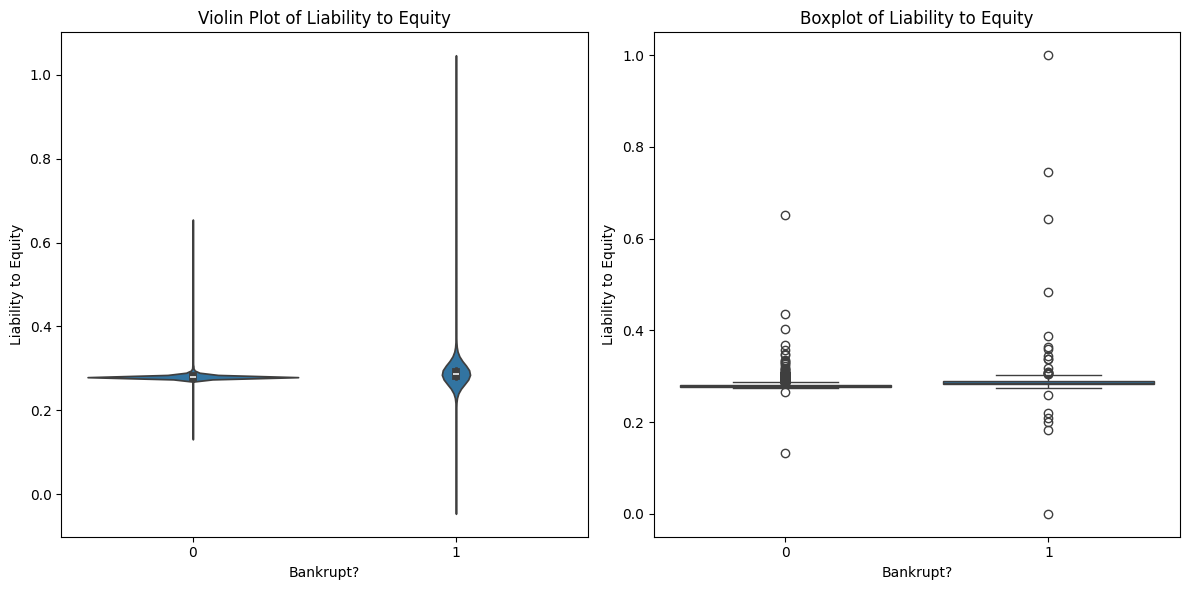

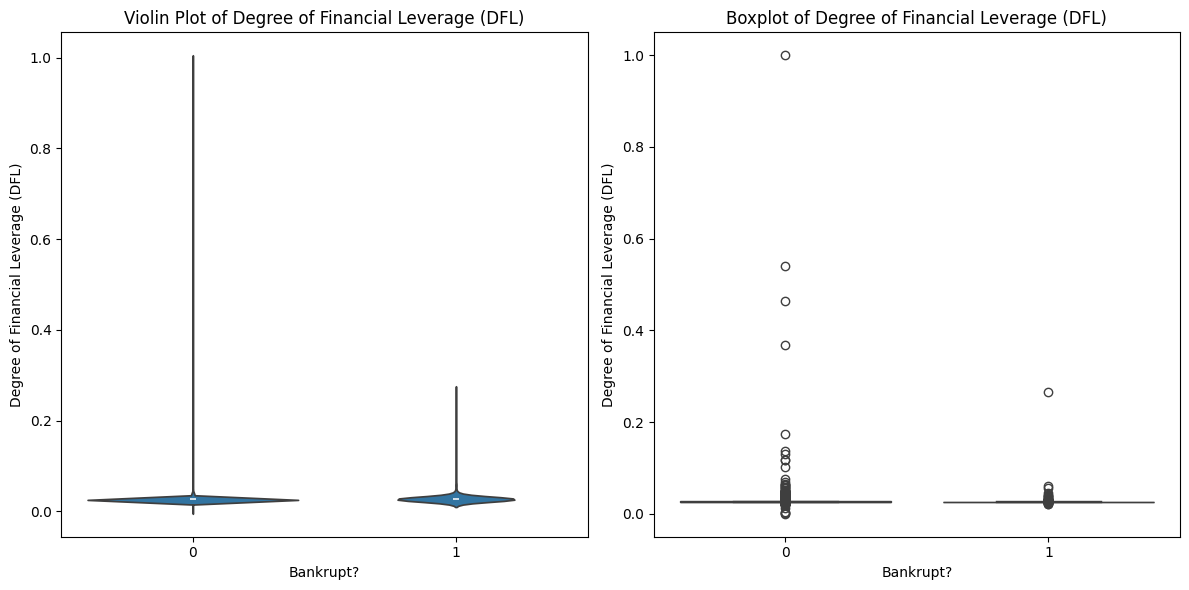

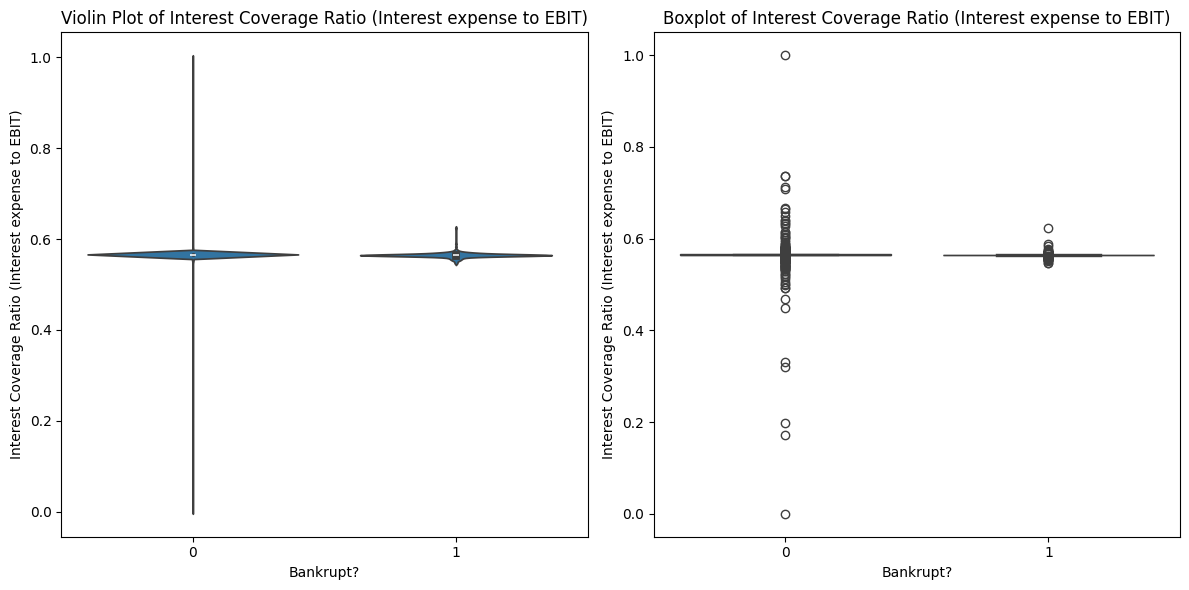

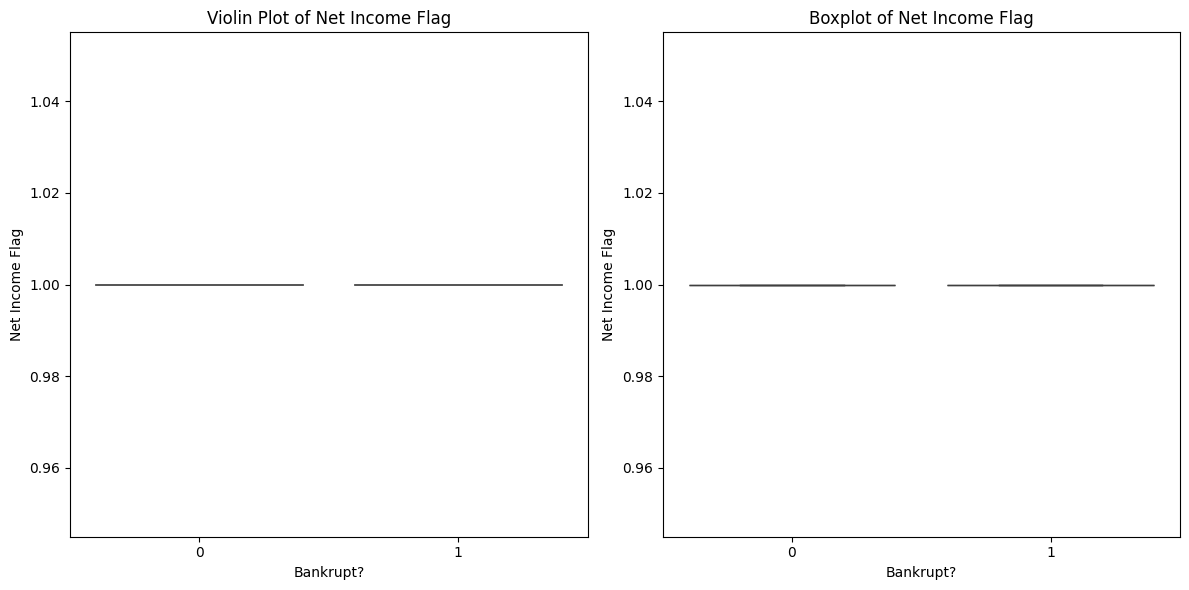

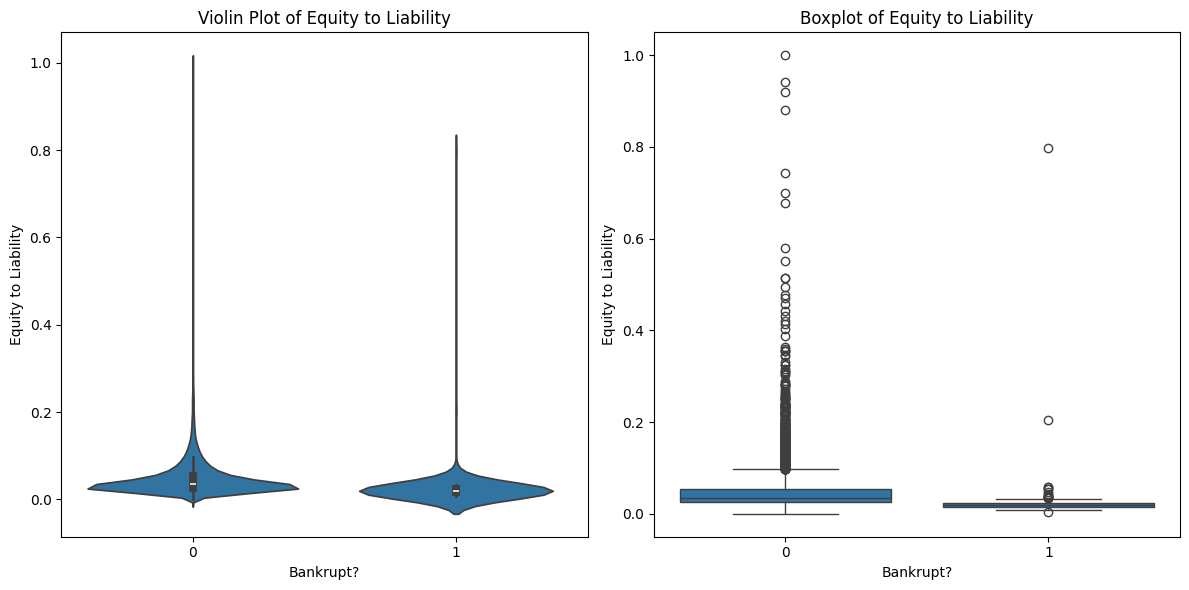

In [7]:
for col in columns:
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.violinplot(x='Bankrupt?', y=col, data=df)
    plt.title(f'Violin Plot of {col}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='Bankrupt?', y=col, data=df)
    plt.title(f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.show()

### The spread of most of the data seems normally distributed despite there being a lot of outliers, hinting at data being normalized 
### We need to treat our outliers

In [8]:
for column in df.columns:
    if column != 'Bankrupt?':
        Q1=df[column].quantile(0.25)
        Q3=df[column].quantile(0.75)
        IQR=Q3-Q1
        lower_bound=Q1-1.5*IQR
        upper_bound=Q3+1.5*IQR
        df[column] = np.where(df[column]<lower_bound,lower_bound,df[column])
        df[column] = np.where(df[column]>upper_bound,upper_bound,df[column])

In [ ]:
df.describe()

# Assumption 2 
### Removing Above Outliers has improved the way our features affect our response

# Moving onto relationship between features and reponse

### We are plotting a correlation matric between all the independant variables and the dependant variables

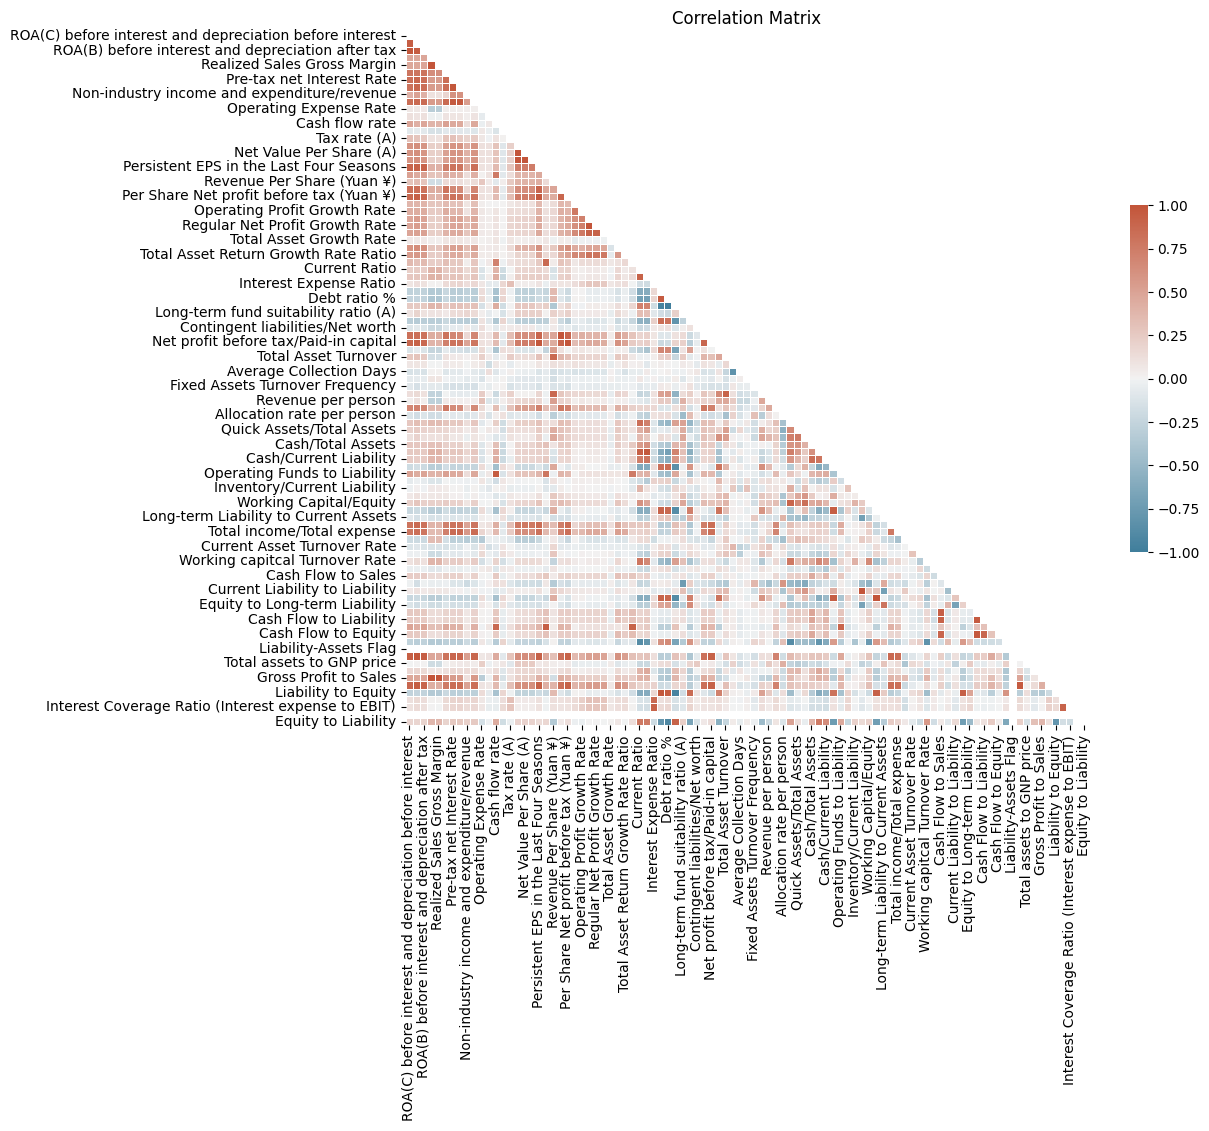

In [9]:
c_matrix = df.drop("Bankrupt?",axis=1).corr()
mask = np.triu(np.ones_like(c_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(c_matrix, mask=mask, cmap=cmap, center=0,
            linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

### Looking at categorical data

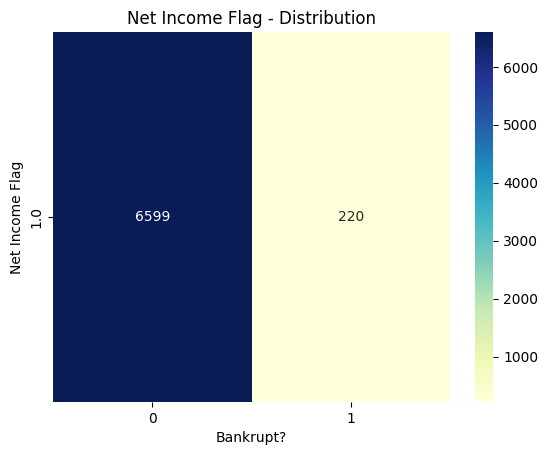

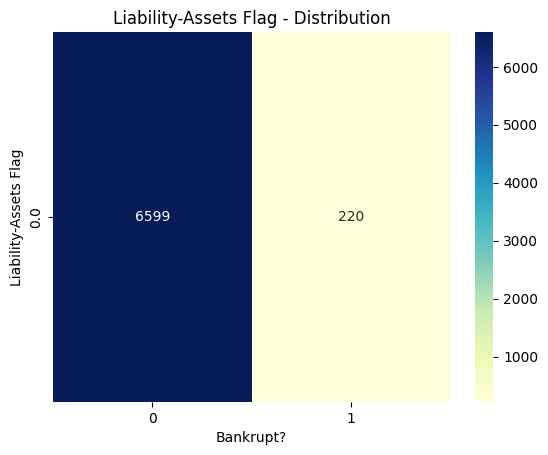

In [10]:
sns.heatmap(pd.crosstab(df['Net Income Flag'],df["Bankrupt?"]), annot=True, cmap="YlGnBu",fmt=".0f")
plt.title("Net Income Flag - Distribution")
plt.show()

sns.heatmap(pd.crosstab(df['Liability-Assets Flag'],df["Bankrupt?"]), annot=True, cmap="YlGnBu",fmt=".0f")
plt.title("Liability-Assets Flag - Distribution")
plt.show()

### All the values in Net Income Flag and Liability Asset Flag are 1, no point in retaining them .

In [11]:
df=df.drop(['Net Income Flag','Liability-Assets Flag'],axis = 1)

# In the bankruptcy data we have has 90+ features. Analysing and building models using 90+ features is a time and resource consuming process.

# Performing Hypothesis Testing to identify significant features 

### We are using One Sample t Test

In [ ]:
from scipy.stats import ttest_ind

significant_features = {}
for column in df.select_dtypes(include=[np.number]).columns:
    if column != 'Bankrupt?':
        bankrupt = df[df['Bankrupt?'] == 1][column]
        non_bankrupt = df[df['Bankrupt?'] == 0][column]
        t_stat, p_val = ttest_ind(bankrupt, non_bankrupt)
        if p_val < 0.05:
            significant_features[column] = p_val

In [13]:
print("The significant features are: ")
print("There are are a total of: ",len(significant_features))
for i in significant_features:
    print(i)

The significant features are: 
There are are a total of:  86
ROA(C) before interest and depreciation before interest
ROA(A) before interest and % after tax
ROA(B) before interest and depreciation after tax
Operating Gross Margin
Realized Sales Gross Margin
Operating Profit Rate
Pre-tax net Interest Rate
After-tax net Interest Rate
Non-industry income and expenditure/revenue
Continuous interest rate (after tax)
Research and development expense rate
Cash flow rate
Interest-bearing debt interest rate
Tax rate (A)
Net Value Per Share (B)
Net Value Per Share (A)
Net Value Per Share (C)
Persistent EPS in the Last Four Seasons
Cash Flow Per Share
Revenue Per Share (Yuan ¥)
Operating Profit Per Share (Yuan ¥)
Per Share Net profit before tax (Yuan ¥)
Realized Sales Gross Profit Growth Rate
Operating Profit Growth Rate
After-tax Net Profit Growth Rate
Regular Net Profit Growth Rate
Continuous Net Profit Growth Rate
Total Asset Growth Rate
Net Value Growth Rate
Total Asset Return Growth Rate Rati

### From the above list of features, we will sort our selected features and choosing the top10 and bottom10 impacting features
### Blindly choosing only introducing Top 10 features to our model will introduce a bias, hence we decide to work with the bottom 10 as well?

In [14]:
corr_coefficients = c_matrix.iloc[:-2, -1].sort_values(ascending=True)
corr_coefficients = corr_coefficients[:-1,]  #To remove the categorical features

In [16]:
corr_coefficients #printing the coeffs

Debt ratio %                     -0.911451
Liability to Equity              -0.787970
Total debt/Total net worth       -0.784027
Current Liability to Assets      -0.740212
Current Liability to Equity      -0.723989
                                    ...   
Cash/Current Liability            0.637850
Quick Ratio                       0.753875
Quick Assets/Current Liability    0.761582
Current Ratio                     0.771394
Net worth/Assets                  0.911451
Name: Equity to Liability, Length: 92, dtype: float64

In [17]:
top_10_columns = corr_coefficients.head(10).index.tolist()
bottom_10_columns = corr_coefficients.tail(10).index.tolist()

In [18]:
X = df.iloc[:, 1:] #All the independant data
Y = df.iloc[:, 0]  #All the dependant data

In [19]:
X_top_bottom = X[top_10_columns + bottom_10_columns] # Select only the top and bottom columns from X

In [31]:
X_top_bottom.columns

Index(['Debt ratio %', 'Liability to Equity', 'Total debt/Total net worth',
       'Current Liability to Assets', 'Current Liability to Equity',
       'Current Liabilities/Equity', 'Borrowing dependency',
       'Current Liability to Current Assets',
       'Inventory and accounts receivable/Net value',
       'Equity to Long-term Liability', 'Cash/Total Assets', 'Cash flow rate',
       'Operating Funds to Liability', 'Working Capital to Total Assets',
       'Working capitcal Turnover Rate', 'Cash/Current Liability',
       'Quick Ratio', 'Quick Assets/Current Liability', 'Current Ratio',
       'Net worth/Assets'],
      dtype='object')

### Splitting our created DF four ways to train our model

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X_top_bottom, Y, test_size=0.2, random_state=42)

### Predicting and Printing our evaluation metrics

In [21]:
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9626099706744868
Precision: 0.0
Recall: 0.0
F1-score: 0.0


C:\Users\dheem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Here because the Precision, Recall and F1-Score are 0, that means our model isn't able to predict values

### Hence we need to scale the data 
### Scaling the data using Standard Scaler

# Using Scaler

In [22]:
scaler = StandardScaler()

scaler.fit(X_top_bottom) # Fit the scaler to the x data

x_scaled = scaler.transform(X_top_bottom) # Transform the x data using the scaler

### Splitting for model, once again

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, Y, test_size=0.2, random_state=42)

###  Print the evaluation metrics and confusion matrix

In [24]:
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9626099706744868
Precision: 0.5
Recall: 0.13725490196078433
F1-score: 0.2153846153846154


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1313
           1       0.50      0.14      0.22        51

    accuracy                           0.96      1364
   macro avg       0.73      0.57      0.60      1364
weighted avg       0.95      0.96      0.95      1364



In [26]:
print(confusion_matrix(y_test,y_pred))

[[1306    7]
 [  44    7]]


### Visualize the confusion matrix

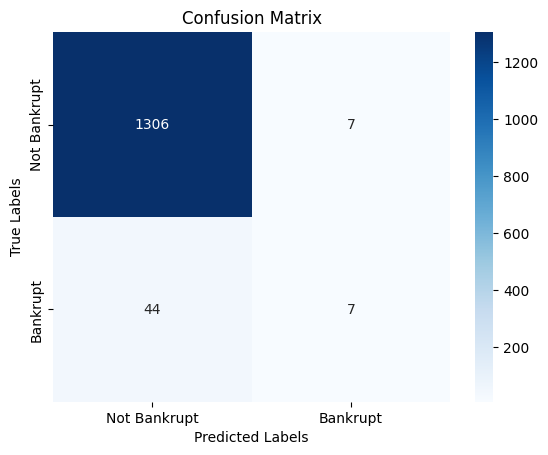

In [27]:
cm = confusion_matrix(y_test, y_pred)
tick_labels = ['Not Bankrupt', 'Bankrupt']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',xticklabels=tick_labels, yticklabels=tick_labels,)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Since our model has very high accuracy, low precission and f1 scores, we need to figure out another way to sample our data as per requirement

# Using SMOTE 

In [28]:
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [29]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(x_train_resampled, y_train_resampled)


LogisticRegression(max_iter=1000)

In [ ]:
y_pred_b = logistic_model.predict(x_test)

### Evaluate the model

In [ ]:
print(classification_report(y_test, y_pred_b))
print(f'Accuracy: {accuracy_score(y_test, y_pred_b)}')

# Calculate the confusion matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred_b)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_b)
precision = precision_score(y_test, y_pred_b)
recall = recall_score(y_test, y_pred_b)
f1 = f1_score(y_test, y_pred_b)

# Print the evaluation metrics and confusion matrix
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

In [ ]:
# Display the confusion matrix
print(cm)

In [ ]:
# Optionally, visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test,y_pred_b))

In [ ]:
Y.value_counts()

# Evaluation of model coeffecients

In [40]:
coeffecients = logistic_model.coef_[0]

In [41]:
feature_importances = pd.DataFrame({'Feature': X_top_bottom.columns, 'Coefficient': coeffecients})
feature_importances = feature_importances.sort_values(by='Coefficient', ascending=False)

print(feature_importances)

                                        Feature  Coefficient
17               Quick Assets/Current Liability     2.330434
2                    Total debt/Total net worth     1.638548
6                          Borrowing dependency     1.276802
15                       Cash/Current Liability     0.694515
4                   Current Liability to Equity     0.647164
5                    Current Liabilities/Equity     0.647164
14               Working capitcal Turnover Rate     0.577829
7           Current Liability to Current Assets     0.416493
0                                  Debt ratio %     0.340616
13              Working Capital to Total Assets     0.081007
12                 Operating Funds to Liability     0.062888
9                 Equity to Long-term Liability    -0.088467
3                   Current Liability to Assets    -0.326279
19                             Net worth/Assets    -0.340616
8   Inventory and accounts receivable/Net value    -0.521923
10                      

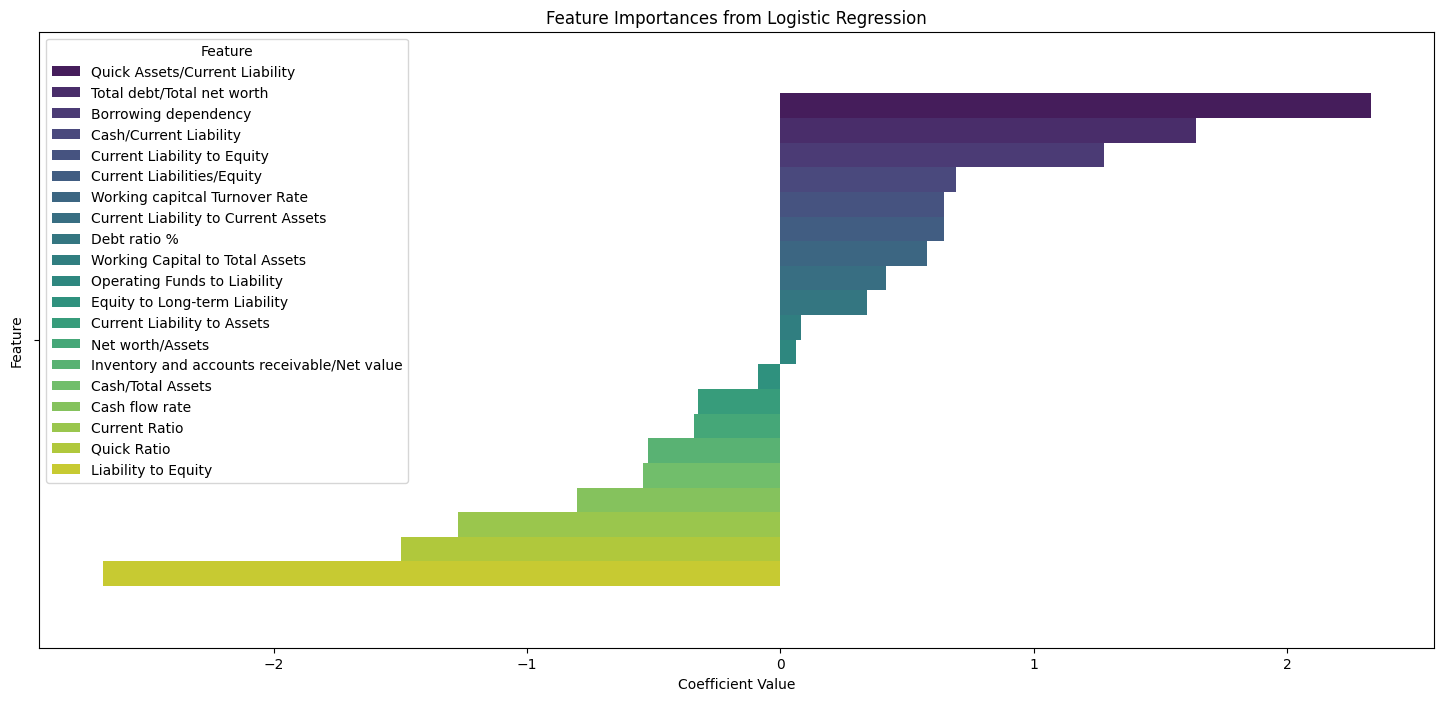

In [52]:
plt.figure(figsize=(18, 8))
sns.barplot(x='Coefficient', hue='Feature', data=feature_importances, palette='viridis',legend=True)
plt.title('Feature Importances from Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

<!-- The coefficients in a logistic regression model represent the impact of each feature on the log-odds of the dependent variable. A positive coefficient indicates that as the feature increases, the likelihood of the target variable being 1 (e.g., bankrupt in this context) increases. Conversely, a negative coefficient indicates that as the feature increases, the likelihood of the target variable being 1 decreases. -->

# The Inferences are presented in the github at the following link 
https://github.com/howdoyoustan/StatsCaseStudy